# Обучение регрессионных задач по проекту ML 2024

## House 16H

Установка необходимых библиотек.

In [1]:
#pip install lightgbm
!pip install catboost
#pip install xgboost
#pip install torch


[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Импорт используемых библиотек.

In [5]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn import linear_model
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from scipy.io import arff
from os import listdir, getcwd, chdir, mkdir
import xgboost
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
import numpy as np
from sklearn.utils import resample
from scipy import stats
from scipy.stats import t
from catboost import CatBoostRegressor
import math
import warnings
warnings.filterwarnings("ignore")
from collections import OrderedDict
from typing import Any, Dict, List, Optional, Union
try:
    import sklearn.tree as sklearn_tree
except ImportError:
    sklearn_tree = None

import torch
import torch.nn as nn
from torch import Tensor
try:
    from tqdm import tqdm
except ImportError:
    tqdm = None

Для простоты я написал несколько функций, их импортироуем тут.

In [6]:
def boostraping(model, x_test,
                y_test, n_iterations = 20):
  """forms list of rmse scores

  Keyword arguments:
  model -- fitted model
  x_test -- features of test data
  y_test -- labels of test data
  n_iterations -- number of boostraping procedures (default 20)
  """
  accuracy = []
  for i in range(n_iterations):
      X_bs, y_bs = resample(x_test, y_test, replace=True)
      # make predictions
      y_hat = model.predict(X_bs)
      # evaluate model
      score = mean_squared_error(y_bs, y_hat, squared = False)
      accuracy.append(score)
  return accuracy

def project_train_simple(x_train, x_test, y_train, y_test):
  """Train project models and generate rmse scores and fitted models

  Keyword arguments:
  x_train -- features of train data
  y_train -- labels of train data
  x_test -- features of test data
  y_test -- labels of test data
  """
  models = [
            CatBoostRegressor(), xgboost.XGBRegressor(),
            RandomForestRegressor(max_depth=2, random_state=0), KernelRidge(alpha=1.0)
            ]

  test_score = []
  train_score = []
  model = []
  best_parameters = []
  for i, k in enumerate(models):
    print('Training '+str(k.__class__.__name__))
    # Step 1: Fit model
    k.fit(x_train, y_train)
    model.append(k.__class__.__name__)
    # Step 2: Calculate rmse scores
    train_score.append(mean_squared_error(y_train, k.predict(x_train), squared = False))
    test_score.append(mean_squared_error(y_test, k.predict(x_test), squared = False))
    best_parameters.append(k)
  data = {'model name': model, 'train score[RMSE]': train_score, 'test_score[RMSE]': test_score}
  df = pd.DataFrame(data)
  return df, best_parameters

def one_sample_t_test(sample, population_mean, alpha=0.05, tail="two"):
    """Make t-test and check
    H0: mean value of sample == population_mean

    Keyword arguments:
    sample -- list of means of fetches
    population_mean -- mean of distribution
    alpha -- the threshold value for rejecting a H0 (default 0.05) 0.01 for 99%
    tail -- method of the p-value calculation (default = "two", "left", "right")
    """
    # Step 1: Calculate T-score
    sample_mean = np.mean(sample)
    sample_std = np.std(sample, ddof=1)
    sample_size = len(sample)

    t_score = (sample_mean - population_mean) / \
        (sample_std / np.sqrt(sample_size))

    # Step 2: Determine degrees of freedom
    df = sample_size - 1

    # Step 3: Identify the appropriate t-distribution
    # No need to explicitly specify degrees of freedom for one-sample t-test in scipy.stats.t

    # Step 4: Find the p-value
    if tail == "two":
        p_value = t.sf(np.abs(t_score), df) * 2  # for two-tailed test
    elif tail == "left":
        p_value = t.sf(t_score, df)  # for left-tailed test
    elif tail == "right":
        p_value = t.sf(-t_score, df)  # for right-tailed test
    else:
        raise ValueError(
            "Invalid tail argument. Use 'two', 'left', or 'right'.")

    # Step 5: Interpret the p-value
    print("P-value:", p_value)

    if p_value < alpha:
        print(
            "Reject the null hypothesis. There is a statistically significant difference.")
    else:
        print("Fail to reject the null hypothesis. There is no statistically significant difference.")
    return p_value


def project_train(x_train, x_test, y_train, y_test):
  """Train project models on gridsearchCV and generate rmse scores and fitted models

  Keyword arguments:
  x_train -- features of train data
  y_train -- labels of train data
  x_test -- features of test data
  y_test -- labels of test data
  """
  models = [
            CatBoostRegressor(), xgboost.XGBRegressor(),
            RandomForestRegressor(random_state=0), KernelRidge()
            ]
  grid = [
          {'iterations': [300],
           'learning_rate': [0.06],
          'depth': [4, 6, 10],
          'l2_leaf_reg': [1, 3, 5, 7]},

          {'learning_rate': [.03, 0.05, .07],
          'n_estimators': [500]},

          {'n_estimators': [100, 300],
          'max_depth': [None, 1, 2, 3]},

          {'alpha': [0.5, 2]}
          ]

  test_score = []
  train_score = []
  model = []
  best_parameters = []
  for i, k in enumerate(models):
    print('Training '+str(k.__class__.__name__))
    clf = GridSearchCV(k, grid[i])
    # Step 1: Fit model on gridsearchCV
    best_estimator = clf.fit(x_train, y_train)
    best_parameters.append(best_estimator)
    model.append(k.__class__.__name__)
    # Step 2: Calculate rmse scores
    train_score.append(mean_squared_error(y_train, best_estimator.predict(x_train), squared = False))
    test_score.append(mean_squared_error(y_test, best_estimator.predict(x_test), squared = False))

  data = {'model name': model, 'train score[RMSE]': train_score, 'test_score[RMSE]': test_score}
  df = pd.DataFrame(data)
  return df, best_parameters

def _check_bins(bins: List[Tensor]) -> None:
    if not bins:
        raise ValueError('The list of bins must not be empty')
    for i, feature_bins in enumerate(bins):
        if not isinstance(feature_bins, Tensor):
            raise ValueError(
                'bins must be a list of PyTorch tensors. '
                f'However, for {i=}: {type(bins[i])=}'
            )
        if feature_bins.ndim != 1:
            raise ValueError(
                'Each item of the bin list must have exactly one dimension.'
                f' However, for {i=}: {bins[i].ndim=}'
            )
        if len(feature_bins) < 2:
            raise ValueError(
                'All features must have at least two bin edges.'
                f' However, for {i=}: {len(bins[i])=}'
            )
        if not feature_bins.isfinite().all():
            raise ValueError(
                'Bin edges must not contain nan/inf/-inf.'
                f' However, this is not true for the {i}-th feature'
            )
        if (feature_bins[:-1] >= feature_bins[1:]).any():
            raise ValueError(
                'Bin edges must be sorted.'
                f' However, the for the {i}-th feature, the bin edges are not sorted'
            )
        if len(feature_bins) == 2:
            warnings.warn(
                f'The {i}-th feature has just two bin edges, which means only one bin.'
                ' Strictly speaking, using a single bin for the'
                ' piecewise-linear encoding should not break anything,'
                ' but it is the same as using sklearn.preprocessing.MinMaxScaler'
            )


def compute_bins(
    X: torch.Tensor,
    n_bins: int = 48,
    *,
    tree_kwargs: Optional[Dict[str, Any]] = None,
    y: Optional[Tensor] = None,
    regression: Optional[bool] = None,
    verbose: bool = False,
) -> List[Tensor]:
    """Compute bin edges for `PiecewiseLinearEmbeddings`.

    **Usage**

    Computing the quantile-based bins (Section 3.2.1 in the paper):

    >>> X_train = torch.randn(10000, 2)
    >>> bins = compute_bins(X_train)

    Computing the tree-based bins (Section 3.2.2 in the paper):

    >>> X_train = torch.randn(10000, 2)
    >>> y_train = torch.randn(len(X_train))
    >>> bins = compute_bins(
    ...     X_train,
    ...     y=y_train,
    ...     regression=True,
    ...     tree_kwargs={'min_samples_leaf': 64, 'min_impurity_decrease': 1e-4},
    ... )

    Args:
        X: the training features.
        n_bins: the number of bins.
        tree_kwargs: keyword arguments for `sklearn.tree.DecisionTreeRegressor`
            (if ``regression`` is `True`) or `sklearn.tree.DecisionTreeClassifier`
            (if ``regression`` is `False`).
            NOTE: requires ``scikit-learn>=1.0,>2`` to be installed.
        y: the training labels (must be provided if ``tree`` is not None).
        regression: whether the labels are regression labels
            (must be provided if ``tree`` is not None).
        verbose: if True and ``tree_kwargs`` is not None, than ``tqdm``
            (must be installed) will report the progress while fitting trees.
    Returns:
        A list of bin edges for all features. For one feature:

        - the maximum possible number of bin edges is ``n_bins + 1``.
        - the minumum possible number of bin edges is ``1``.
    """
    if not isinstance(X, Tensor):
        raise ValueError(f'X must be a PyTorch tensor, however: {type(X)=}')
    if X.ndim != 2:
        raise ValueError(f'X must have exactly two dimensions, however: {X.ndim=}')
    if X.shape[0] < 2:
        raise ValueError(f'X must have at least two rows, however: {X.shape[0]=}')
    if X.shape[1] < 1:
        raise ValueError(f'X must have at least one column, however: {X.shape[1]=}')
    if not X.isfinite().all():
        raise ValueError('X must not contain nan/inf/-inf.')
    if (X == X[0]).all(dim=0).any():
        raise ValueError(
            'All columns of X must have at least two distinct values.'
            ' However, X contains columns with just one distinct value.'
        )
    if n_bins <= 1 or n_bins >= len(X):
        raise ValueError(
            'n_bins must be more than 1, but less than len(X), however:'
            f' {n_bins=}, {len(X)=}'
        )

    if tree_kwargs is None:
        if y is not None or regression is not None or verbose:
            raise ValueError(
                'If tree_kwargs is None, then y must be None, regression must be None'
                ' and verbose must be False'
            )

        # NOTE[DIFF]
        # The original implementation in the official paper repository has an
        # unintentional divergence from what is written in the paper.
        # This package implements the algorithm described in the paper,
        # and it is recommended for future work
        # (this may affect the optimal number of bins
        #  reported in the official repository).
        #
        # Additional notes:
        # - this is the line where the divergence happens:
        #   (the thing is that limiting the number of quantiles by the number of
        #   distinct values is NOT the same as removing identical quantiles
        #   after computing them)
        #   https://github.com/yandex-research/tabular-dl-num-embeddings/blob/c1d9eb63c0685b51d7e1bc081cdce6ffdb8886a8/bin/train4.py#L612C30-L612C30
        # - for the tree-based bins, there is NO such divergence;
        bins = [
            q.unique()
            for q in torch.quantile(
                X, torch.linspace(0.0, 1.0, n_bins + 1).to(X), dim=0
            ).T
        ]
        _check_bins(bins)
        return bins
    else:
        if sklearn_tree is None:
            raise RuntimeError(
                'The scikit-learn package is missing.'
                ' See README.md for installation instructions'
            )
        if y is None or regression is None:
            raise ValueError(
                'If tree_kwargs is not None, then y and regression must not be None'
            )
        if y.ndim != 1:
            raise ValueError(f'y must have exactly one dimension, however: {y.ndim=}')
        if len(y) != len(X):
            raise ValueError(
                f'len(y) must be equal to len(X), however: {len(y)=}, {len(X)=}'
            )
        if y is None or regression is None:
            raise ValueError(
                'If tree_kwargs is not None, then y and regression must not be None'
            )
        if 'max_leaf_nodes' in tree_kwargs:
            raise ValueError(
                'tree_kwargs must not contain the key "max_leaf_nodes"'
                ' (it will be set to n_bins automatically).'
            )

        if verbose:
            if tqdm is None:
                raise ImportError('If verbose is True, tqdm must be installed')
            tqdm_ = tqdm
        else:
            tqdm_ = lambda x: x  # noqa: E731

        if X.device.type != 'cpu' or y.device.type != 'cpu':
            warnings.warn(
                'Computing tree-based bins involves the conversion of the input PyTorch'
                ' tensors to NumPy arrays. The provided PyTorch tensors are not'
                ' located on CPU, so the conversion has some overhead.',
                UserWarning,
            )
        X_numpy = X.cpu().numpy()
        y_numpy = y.cpu().numpy()
        bins = []
        for column in tqdm_(X_numpy.T):
            feature_bin_edges = [float(column.min()), float(column.max())]
            tree = (
                (
                    sklearn_tree.DecisionTreeRegressor
                    if regression
                    else sklearn_tree.DecisionTreeClassifier
                )(max_leaf_nodes=n_bins, **tree_kwargs)
                .fit(column.reshape(-1, 1), y_numpy)
                .tree_
            )
            for node_id in range(tree.node_count):
                # The following condition is True only for split nodes. Source:
                # https://scikit-learn.org/1.0/auto_examples/tree/plot_unveil_tree_structure.html#tree-structure
                if tree.children_left[node_id] != tree.children_right[node_id]:
                    feature_bin_edges.append(float(tree.threshold[node_id]))
            bins.append(torch.as_tensor(feature_bin_edges).unique())
        _check_bins(bins)
        return [x.to(device=X.device, dtype=X.dtype) for x in bins]

def emb_ple(x, bin):
    x_emb = np.zeros(len(bin)-1)
    for i in range(len(x_emb)):
        if (x < bin[i]) and (i > 0):
            x_emb[i] = 0
        elif  (x >= bin[i+1]) and (i < len(x_emb)):
            x_emb[i] = 1
        else:
             x_emb[i] = (x - bin[i])/(bin[i+1] - bin[i])
    return x_emb


def ple(bins, x):
    bin = bins[0].numpy() # for torch tensors
    #bin = bins[0]
    f1 = emb_ple(x[0, 0], bin)
    for k in range(len(x)-1):
        f2 = emb_ple(x[k+1, 0], bin)
        f1 = np.vstack([f1, f2])
    x_ple = f1
    for i in range(len(x[0])-1):
        bin = bins[i+1].numpy()
        #bin = bins[i+1]
        f1 = emb_ple(x[0, i+1], bin)
        for k in range(len(x)-1):
            f2 = emb_ple(x[k+1, i+1], bin)
            f1 = np.vstack([f1, f2])
        x_ple = np.concatenate([x_ple, f1], axis = 1)
    return x_ple

# x = np.array([[5, 1, 6, 3], [2, 5, 1, 3], [5, 1, 6, 3]])
# bin = np.array([[0, 2, 4, 8, 10], [0, 2, 4, 8, 10], [0, 2, 4, 8, 10], [0, 2, 4, 8, 10]])
# bins = compute_bins(torch.from_numpy(x_train))
# x_emb = ple(bins, x_train)
# print(x_emb)

Тут я загружаю данные и разделяю их.  
Для некоторых моделей следует использовать шкалирование, а на такие, как catboost шкалирование не влияет. Поэтому перед разделением проведено шкалирование.

In [10]:
# from scipy.io import arff
# #exp_path = 'C:\\Users\\peter\\Desktop\\files\\my_soft'
# #chdir(exp_path)
# data = arff.loadarff('house_16H.arff')
# dataset_h_16h = pd.DataFrame(data[0])
# #y = np.array(dataset_h_16h.pop('price'))
# #x = np.array(dataset_h_16h)
# y = dataset_h_16h.pop('price')
# x = dataset_h_16h
housing = fetch_california_housing()
x = housing.data
y = housing.target
x_scaled = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, random_state=0)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

### Стандартные модели

Обучаем модели из коробки

Обучение на всех моделях кроме LightGBM. Её обучаю отдельно из-за того, что она нестантартно запускается.

In [ ]:
df, models = project_train_simple(x_train, x_test, y_train, y_test)

Training CatBoostRegressor
Learning rate set to 0.064113
0:	learn: 51403.0959519	total: 10.3ms	remaining: 10.3s
1:	learn: 50240.0618707	total: 18.7ms	remaining: 9.31s
2:	learn: 49215.0408164	total: 25.9ms	remaining: 8.59s
3:	learn: 48235.8784230	total: 32.8ms	remaining: 8.18s
4:	learn: 47334.1346954	total: 40.1ms	remaining: 7.98s
5:	learn: 46465.7472004	total: 47.1ms	remaining: 7.79s
6:	learn: 45618.7104190	total: 54.1ms	remaining: 7.67s
7:	learn: 44901.8430243	total: 61.1ms	remaining: 7.57s
8:	learn: 44247.7335876	total: 69.7ms	remaining: 7.67s
9:	learn: 43631.4834933	total: 77ms	remaining: 7.62s
10:	learn: 43072.5367037	total: 84.4ms	remaining: 7.59s
11:	learn: 42565.4135476	total: 91.3ms	remaining: 7.52s
12:	learn: 42080.7129546	total: 98.4ms	remaining: 7.47s
13:	learn: 41623.8050038	total: 105ms	remaining: 7.41s
14:	learn: 41149.4751651	total: 112ms	remaining: 7.37s
15:	learn: 40763.1883045	total: 119ms	remaining: 7.31s
16:	learn: 40332.0361392	total: 126ms	remaining: 7.3s
17:	lear

Обучение LGBM

In [ ]:
train_dataset = lgb.Dataset(x_train, y_train)
test_dataset = lgb.Dataset(x_test, y_test)

booster = lgb.train({"objective": "regression"},
                    train_set=train_dataset, valid_sets=(test_dataset,),
                    num_boost_round=20)
df.loc[ len(df.index )] = ['LGBM',
                           (mean_squared_error(y_train, booster.predict(x_train), squared = False)),
                           mean_squared_error(y_test, booster.predict(x_test), squared = False)]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4079
[LightGBM] [Info] Number of data points in the train set: 17088, number of used features: 16
[LightGBM] [Info] Start training from score 49919.131086


Статистика по моделям из коробки по сравнению с значением метрики в статье.

In [ ]:
rmse_paper = 30935
p_values = []
for i, model in enumerate(models):
    rsme = np.array(boostraping(model, x_test, y_test))
    print(rsme.mean())
    p_value = one_sample_t_test(rsme, rmse_paper, tail="two")
    p_values.append(p_value)
rsme = boostraping(booster, x_test, y_test)
p_value = one_sample_t_test(rsme, rmse_paper, tail="two")
p_values.append(p_value)
df['p_value'] = p_values

30401.092371826147
P-value: 0.05287765340378612
Fail to reject the null hypothesis. There is no statistically significant difference.
33147.39937753636
P-value: 5.979081434274268e-07
Reject the null hypothesis. There is a statistically significant difference.
45293.976727325666
P-value: 2.688240815208454e-19
Reject the null hypothesis. There is a statistically significant difference.
67555.25122671794
P-value: 7.804347487927111e-29
Reject the null hypothesis. There is a statistically significant difference.
P-value: 1.8409108679051093e-12
Reject the null hypothesis. There is a statistically significant difference.


In [ ]:
df

model name  train score[RMSE]  test_score[RMSE]       p_value
0      CatBoostRegressor       17937.917599      30314.192564  5.287765e-02
1           XGBRegressor       12800.424776      32830.506508  5.979081e-07
2  RandomForestRegressor       44546.413105      45337.656218  2.688241e-19
3            KernelRidge       67539.750082      67855.086878  7.804347e-29
4                   LGBM       30058.524907      34787.542909  1.840911e-12

Пробная статистика c отрисовкой

In [ ]:
accuracy = []
n_iterations = 1000
for i in range(n_iterations):
    X_bs, y_bs = resample(x_test, y_test, replace=True)
    # make predictions
    y_hat = booster.predict(X_bs)
    # evaluate model
    score = mean_squared_error(y_bs, y_hat, squared = False)
    accuracy.append(score)

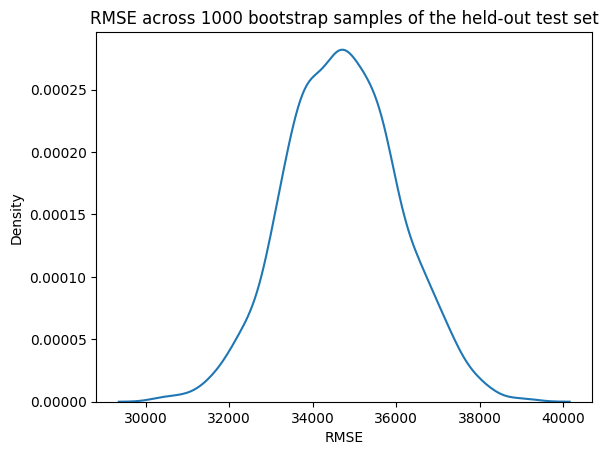

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot distribution of accuracy
sns.kdeplot(accuracy)
plt.title("RMSE across 1000 bootstrap samples of the held-out test set")
plt.xlabel("RMSE")
plt.show()

Заметно, что catboost из коробки дает результат практически равный полученному в статье(больше на 0.013), чем в статье.  
При этом хуже всего показал себя RandomForestRegressor - результат более чем вдвое хуже получененого в статье(0.85 против 0.43).  
Попробуем улучшить результат результат в следующем разделе. При этом все результаты статистически отличаются от полученного в статье

### Модели после GridsearchCV

Проведем обучение с использованием уже написанных функций.

In [ ]:
df2, best_params = project_train(x_train, x_test, y_train, y_test)


Выходные данные были обрезаны до нескольких последних строк (5000).
103:	learn: 22338.5555178	total: 5.25s	remaining: 9.9s
104:	learn: 22268.4688654	total: 5.31s	remaining: 9.86s
105:	learn: 22192.6284289	total: 5.35s	remaining: 9.8s
106:	learn: 22119.9763648	total: 5.4s	remaining: 9.74s
107:	learn: 22063.2279390	total: 5.46s	remaining: 9.7s
108:	learn: 22011.9638359	total: 5.5s	remaining: 9.64s
109:	learn: 21955.9905086	total: 5.55s	remaining: 9.59s
110:	learn: 21863.5559831	total: 5.6s	remaining: 9.54s
111:	learn: 21792.1231913	total: 5.65s	remaining: 9.48s
112:	learn: 21726.2866666	total: 5.71s	remaining: 9.45s
113:	learn: 21654.3751848	total: 5.77s	remaining: 9.41s
114:	learn: 21579.3186149	total: 5.82s	remaining: 9.36s
115:	learn: 21530.5322116	total: 5.87s	remaining: 9.3s
116:	learn: 21456.5716708	total: 5.92s	remaining: 9.26s
117:	learn: 21387.8468297	total: 5.97s	remaining: 9.21s
118:	learn: 21304.3970932	total: 6.01s	remaining: 9.15s
119:	learn: 21214.1848353	total: 6.07s	rema

Результат выводится в виде датафрейма для простоты работы с ним.

In [ ]:
df2

model name  train score[RMSE]  test_score[RMSE]
0      CatBoostRegressor       14836.140282      31129.409058
1           XGBRegressor       13394.768713      31295.837142
2  RandomForestRegressor       11667.588478      32688.358778
3            KernelRidge       67539.772100      67855.386185

Отдельно обучим LGBM

In [ ]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'max_depth': [-1, 2, 5],
    'n_estimators': [100, 300],
    'n_jobs': [-1]
    }
lgb_estimator = lgb.LGBMRegressor()
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)
booster = gsearch.fit(X=x_train, y=y_train)
#booster = lgb.train({"objective": "regression"},
#                    train_set=train_dataset, valid_sets=(test_dataset,),
#                    num_boost_round=20)
df2.loc[ len(df2.index )] = ['LGBM',
                           (mean_squared_error(y_train, booster.predict(x_train), squared = False)),
                           mean_squared_error(y_test, booster.predict(x_test), squared = False)]

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

Проверим получилось ли статистически значимо улучшить результат по сравнению по сравненимю с обучением на моделях из коробки.

In [ ]:
best_params.append(booster)
#best_params = best_params[0:5]
p_values = []
for i, model in enumerate(best_params):
    rsme = np.array(boostraping(model, x_test, y_test))
    print(rsme.mean())
    p_value = one_sample_t_test(rsme, df['test_score[RMSE]'][i], tail="two")
    p_values.append(p_value)
df2['p_value'] = p_values
df2

30790.76941928833
P-value: 0.0272355312367172
Reject the null hypothesis. There is a statistically significant difference.
31194.29311478009
P-value: 1.6035128892132884e-06
Reject the null hypothesis. There is a statistically significant difference.
32891.33763739749
P-value: 1.5877212418246846e-18
Reject the null hypothesis. There is a statistically significant difference.
68157.20442374973
P-value: 0.20989293448684043
Fail to reject the null hypothesis. There is no statistically significant difference.
31350.811568885645
P-value: 3.710695788269931e-10
Reject the null hypothesis. There is a statistically significant difference.


model name  train score[RMSE]  test_score[RMSE]       p_value
0      CatBoostRegressor       14836.140282      31129.409058  2.723553e-02
1           XGBRegressor       13394.768713      31295.837142  1.603513e-06
2  RandomForestRegressor       11667.588478      32688.358778  1.587721e-18
3            KernelRidge       67539.772100      67855.386185  2.098929e-01
4                   LGBM       12359.743961      31275.866486  3.710696e-10

Заметно, что удалось статистически значимо улучшить результаты для CatBoostRegressor, XGBRegressor, RandomForestRegressor и LGBM.

### Числовые эмбединги PLE-Q

Переведем данные с использованием эмбединга.

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
bins = compute_bins(torch.from_numpy(x_train))
x_train_emb = ple(bins, x_train)
x_test_emb = ple(bins, x_test)


In [ ]:
df4, models_simple_ple_q = project_train_simple(x_train, x_test, y_train, y_test)
train_dataset = lgb.Dataset(x_train, y_train)
test_dataset = lgb.Dataset(x_test, y_test)

booster = lgb.train({"objective": "regression"},
                    train_set=train_dataset, valid_sets=(test_dataset,),
                    num_boost_round=20)
df4.loc[ len(df4.index )] = ['LGBM',
                           (mean_squared_error(y_train, booster.predict(x_train), squared = False)),
                           mean_squared_error(y_test, booster.predict(x_test), squared = False)]

Training CatBoostRegressor
Learning rate set to 0.064113
0:	learn: 51403.0959519	total: 8.41ms	remaining: 8.4s
1:	learn: 50240.0618707	total: 15.2ms	remaining: 7.59s
2:	learn: 49215.0408164	total: 22.4ms	remaining: 7.43s
3:	learn: 48235.8784230	total: 29ms	remaining: 7.23s
4:	learn: 47334.1346954	total: 35.5ms	remaining: 7.06s
5:	learn: 46465.7472004	total: 42.3ms	remaining: 7.01s
6:	learn: 45618.7104190	total: 49.6ms	remaining: 7.04s
7:	learn: 44901.8430243	total: 56.5ms	remaining: 7.01s
8:	learn: 44247.7335876	total: 63.9ms	remaining: 7.03s
9:	learn: 43631.4834933	total: 70.8ms	remaining: 7.01s
10:	learn: 43072.5367037	total: 77.7ms	remaining: 6.98s
11:	learn: 42565.4135476	total: 87.2ms	remaining: 7.18s
12:	learn: 42080.7129546	total: 103ms	remaining: 7.83s
13:	learn: 41623.8050038	total: 115ms	remaining: 8.07s
14:	learn: 41149.4751651	total: 121ms	remaining: 7.97s
15:	learn: 40763.1883045	total: 128ms	remaining: 7.88s
16:	learn: 40332.0361392	total: 135ms	remaining: 7.81s
17:	learn

In [ ]:
df4

model name  train score[RMSE]  test_score[RMSE]
0      CatBoostRegressor       17937.917599      30314.192564
1           XGBRegressor       12800.424776      32830.506508
2  RandomForestRegressor       44546.413105      45337.656218
3            KernelRidge       67539.750082      67855.086878
4                   LGBM       30058.524907      34787.542909

Обучим модели

In [ ]:
df3, best_params_ple_q = project_train(x_train_emb, x_test_emb, y_train, y_test)
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'max_depth': [-1, 2, 5],
    'n_estimators': [100, 300],
    'n_jobs': [-1]
    }
lgb_estimator = lgb.LGBMRegressor()
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)
booster = gsearch.fit(X=x_train, y=y_train)
#booster = lgb.train({"objective": "regression"},
#                    train_set=train_dataset, valid_sets=(test_dataset,),
#                    num_boost_round=20)
df3.loc[ len(df3.index )] = ['LGBM',
                           (mean_squared_error(y_train, booster.predict(x_train), squared = False)),
                           mean_squared_error(y_test, booster.predict(x_test), squared = False)]

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [ ]:
df3

model name  train score[RMSE]  test_score[RMSE]
0      CatBoostRegressor       15579.808957      30831.691230
1           XGBRegressor       12342.424926      31551.277646
2  RandomForestRegressor       11667.709449      32676.443411
3            KernelRidge       36120.876188      37939.334798
4                   LGBM       12359.743961      31275.866486

Проверим статистическую значимость различия использования эмбедингов на классическом ML

In [19]:
def onetail(grid_models, emb_models, x_test, x_test_emb, y_test, alpha = 0.05):
    for i in range(len(grid_models)):
        rsme_grid = np.array(boostraping(grid_models[i], x_test, y_test))
        rsme_emb = np.array(boostraping(emb_models[i], x_test_emb, y_test))
        res = stats.levene(rsme_grid, rsme_emb)
        if (res.pvalue > alpha):
          t_test = stats.ttest_ind(rsme_grid, rsme_emb)
        else:
          t_test = stats.ttest_ind(rsme_grid, rsme_emb, equal_var = False)
        p_value = t_test.pvalue
        # Step 5: Interpret the p-value
        print("P-value:", p_value)

        if (p_value*0.5 < alpha) and (t_test.statistic>0):
          print(
            "Reject the null hypothesis. There is a significant stat improvement for the model "
            +str(grid_models[i].__class__.__name__)+'.')
        else:
          print("Fail to reject the null hypothesis. There is no statistically significant difference for model "
          +str(grid_models[i].__class__.__name__)+'.')

In [ ]:
best_params = best_params[0:4]
onetail(best_params, best_params_ple_q, x_test, x_test_emb, y_test)

P-value: 0.22298382586050663
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 0.1194497831156092
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 0.20992167038554713
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 1.0501311301562982e-42
Reject the null hypothesis. There is a significant stat improvement for the model GridSearchCV.


Теперь проверим на LGBM

In [ ]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'max_depth': [-1, 2, 5],
    'n_estimators': [100, 300],
    'n_jobs': [-1]
    }
lgb_estimator = lgb.LGBMRegressor()
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)
booster = gsearch.fit(X= x_train_emb, y=y_train)

NameError: name 'x_train_emb' is not defined

In [ ]:
print('LGBM', (mean_squared_error(y_train, booster.predict(x_train_emb), squared = False)),
      mean_squared_error(y_test, booster.predict(x_test_emb), squared = False))

LGBM 14772.29997619926 31238.185008039945


In [ ]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'max_depth': [-1, 2, 5],
    'n_estimators': [100, 300],
    'n_jobs': [-1]
    }
lgb_estimator = lgb.LGBMRegressor()
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)
booster_simple = gsearch.fit(X=x_train, y=y_train)


Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [ ]:
onetail([booster_simple], [booster], x_test, x_test_emb, y_test)

P-value: 0.17126932748337217
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.


### Числовые эмбединги PLE-T

In [ ]:
bins = compute_bins(
    torch.from_numpy(x_train),
    tree_kwargs={'min_samples_leaf': 64, 'min_impurity_decrease': 1e-4},
    y=torch.from_numpy(y_train),
    regression=True,
)
x_train_emb = ple(bins, x_train)
x_test_emb = ple(bins, x_test)

Обучение всех моделей кроме LGBM

In [ ]:
df3, best_params_ple_q = project_train(x_train_emb, x_test_emb, y_train, y_test)

Выходные данные были обрезаны до нескольких последних строк (5000).
103:	learn: 21912.2235687	total: 1m 47s	remaining: 3m 21s
104:	learn: 21814.5426684	total: 1m 48s	remaining: 3m 20s
105:	learn: 21752.7605832	total: 1m 48s	remaining: 3m 19s
106:	learn: 21675.4085224	total: 1m 49s	remaining: 3m 18s
107:	learn: 21599.9667369	total: 1m 51s	remaining: 3m 18s
108:	learn: 21554.7201637	total: 1m 52s	remaining: 3m 17s
109:	learn: 21481.9460287	total: 1m 53s	remaining: 3m 16s
110:	learn: 21441.4430007	total: 1m 54s	remaining: 3m 15s
111:	learn: 21390.2537520	total: 1m 55s	remaining: 3m 14s
112:	learn: 21332.0601285	total: 1m 56s	remaining: 3m 13s
113:	learn: 21251.1308082	total: 1m 57s	remaining: 3m 11s
114:	learn: 21201.9570620	total: 1m 58s	remaining: 3m 10s
115:	learn: 21106.4588695	total: 1m 59s	remaining: 3m 9s
116:	learn: 21013.4195583	total: 2m	remaining: 3m 8s
117:	learn: 20964.9069900	total: 2m 1s	remaining: 3m 7s
118:	learn: 20927.0385992	total: 2m 2s	remaining: 3m 6s
119:	learn: 20

In [ ]:
onetail(best_params, best_params_ple_q, x_test, x_test_emb, y_test)

P-value: 0.937984897541294
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 0.1883872676559872
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 0.7438387737820124
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 3.1694006625744245e-42
Reject the null hypothesis. There is a significant stat improvement for the model GridSearchCV.


Теперь необходимо пороверить улучшил ли этот эмбединг LGBM

In [ ]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'max_depth': [-1, 2, 5],
    'n_estimators': [100, 300],
    'n_jobs': [-1]
    }
lgb_estimator = lgb.LGBMRegressor()
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)
booster = gsearch.fit(X=x_train_emb, y=y_train)
print('LGBM', (mean_squared_error(y_train, booster.predict(x_train_emb), squared = False)),
      mean_squared_error(y_test, booster.predict(x_test_emb), squared = False))

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [ ]:
onetail([booster_simple], [booster], x_test, x_test_emb, y_test)

P-value: 0.7292770222096108
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.


#### Выводы

Получены значения близкие к значениям из статьи. При этом эмбединги помогли улучшить значения только для kernel linear regression. Статзначимость проверялась с помощью однохвостового t-теста, с границей p-value = 0.05.

In [11]:
from torch.nn.parameter import Parameter

def periodic_embedding(X, n_features):
  x = torch.from_numpy(X)
  k = 48
  sigma = 0.01
  weight = Parameter(torch.empty(n_features, k))
  x = 2 * math.pi * weight * x[..., None]
  x = torch.cat([torch.cos(x), torch.sin(x)], -1)
  x = x.detach().numpy()
  x_f = x[:, 0, :]
  for i in range(x.shape[1]-1):
    x_f = np.concatenate([x_f, x[:, i+1, :]], axis = 1)

  return x_f

In [12]:
x_train.shape[1]

8

In [13]:
x = periodic_embedding(x_train, x_train.shape[1])

In [ ]:
x.shape

In [ ]:
x_train.shape

## Periodic

In [14]:
x_train_emb = periodic_embedding(x_train, x_train.shape[1])
x_test_emb = periodic_embedding(x_test, x_test.shape[1])

In [15]:
df3, best_params_ple_q = project_train(x_train_emb, x_test_emb, y_train, y_test)

Training CatBoostRegressor
0:	learn: 1.1235537	total: 144ms	remaining: 43.2s
1:	learn: 1.0946376	total: 147ms	remaining: 21.9s
2:	learn: 1.0685750	total: 150ms	remaining: 14.8s
3:	learn: 1.0446898	total: 152ms	remaining: 11.3s
4:	learn: 1.0235509	total: 155ms	remaining: 9.14s
5:	learn: 1.0044408	total: 158ms	remaining: 7.73s
6:	learn: 0.9869912	total: 161ms	remaining: 6.72s
7:	learn: 0.9713988	total: 163ms	remaining: 5.96s
8:	learn: 0.9565157	total: 166ms	remaining: 5.38s
9:	learn: 0.9431809	total: 169ms	remaining: 4.9s
10:	learn: 0.9314686	total: 172ms	remaining: 4.52s
11:	learn: 0.9201383	total: 175ms	remaining: 4.2s
12:	learn: 0.9099358	total: 178ms	remaining: 3.92s
13:	learn: 0.9013483	total: 180ms	remaining: 3.68s
14:	learn: 0.8933724	total: 183ms	remaining: 3.47s
15:	learn: 0.8856955	total: 185ms	remaining: 3.29s
16:	learn: 0.8791460	total: 188ms	remaining: 3.13s
17:	learn: 0.8733920	total: 190ms	remaining: 2.98s
18:	learn: 0.8682348	total: 193ms	remaining: 2.85s
19:	learn: 0.863

220:	learn: 0.8124513	total: 721ms	remaining: 258ms
221:	learn: 0.8124016	total: 725ms	remaining: 255ms
222:	learn: 0.8123354	total: 729ms	remaining: 252ms
223:	learn: 0.8122033	total: 731ms	remaining: 248ms
224:	learn: 0.8121692	total: 734ms	remaining: 245ms
225:	learn: 0.8121432	total: 737ms	remaining: 241ms
226:	learn: 0.8121057	total: 740ms	remaining: 238ms
227:	learn: 0.8120631	total: 742ms	remaining: 234ms
228:	learn: 0.8120287	total: 745ms	remaining: 231ms
229:	learn: 0.8119412	total: 748ms	remaining: 228ms
230:	learn: 0.8118954	total: 751ms	remaining: 224ms
231:	learn: 0.8118500	total: 753ms	remaining: 221ms
232:	learn: 0.8118217	total: 756ms	remaining: 217ms
233:	learn: 0.8117733	total: 759ms	remaining: 214ms
234:	learn: 0.8116953	total: 762ms	remaining: 211ms
235:	learn: 0.8116448	total: 764ms	remaining: 207ms
236:	learn: 0.8115957	total: 768ms	remaining: 204ms
237:	learn: 0.8115300	total: 770ms	remaining: 201ms
238:	learn: 0.8114911	total: 773ms	remaining: 197ms
239:	learn: 

139:	learn: 0.8135301	total: 391ms	remaining: 447ms
140:	learn: 0.8134707	total: 394ms	remaining: 444ms
141:	learn: 0.8134376	total: 397ms	remaining: 441ms
142:	learn: 0.8133874	total: 400ms	remaining: 439ms
143:	learn: 0.8133458	total: 403ms	remaining: 437ms
144:	learn: 0.8133010	total: 406ms	remaining: 434ms
145:	learn: 0.8132605	total: 409ms	remaining: 432ms
146:	learn: 0.8132377	total: 412ms	remaining: 429ms
147:	learn: 0.8132151	total: 414ms	remaining: 426ms
148:	learn: 0.8131449	total: 417ms	remaining: 423ms
149:	learn: 0.8131252	total: 421ms	remaining: 421ms
150:	learn: 0.8131040	total: 425ms	remaining: 419ms
151:	learn: 0.8130727	total: 428ms	remaining: 416ms
152:	learn: 0.8130532	total: 430ms	remaining: 413ms
153:	learn: 0.8129860	total: 433ms	remaining: 410ms
154:	learn: 0.8129357	total: 436ms	remaining: 408ms
155:	learn: 0.8129177	total: 439ms	remaining: 405ms
156:	learn: 0.8128990	total: 441ms	remaining: 402ms
157:	learn: 0.8128478	total: 444ms	remaining: 399ms
158:	learn: 

0:	learn: 1.1216245	total: 2.61ms	remaining: 781ms
1:	learn: 1.0928264	total: 5.28ms	remaining: 787ms
2:	learn: 1.0672624	total: 7.62ms	remaining: 754ms
3:	learn: 1.0427325	total: 9.87ms	remaining: 730ms
4:	learn: 1.0214841	total: 12.7ms	remaining: 752ms
5:	learn: 1.0020689	total: 15.6ms	remaining: 765ms
6:	learn: 0.9845551	total: 18.9ms	remaining: 793ms
7:	learn: 0.9684010	total: 21.5ms	remaining: 786ms
8:	learn: 0.9533013	total: 24ms	remaining: 775ms
9:	learn: 0.9395825	total: 26.5ms	remaining: 769ms
10:	learn: 0.9277140	total: 28.9ms	remaining: 759ms
11:	learn: 0.9167408	total: 31.4ms	remaining: 754ms
12:	learn: 0.9060791	total: 33.7ms	remaining: 745ms
13:	learn: 0.8968202	total: 36.1ms	remaining: 737ms
14:	learn: 0.8888313	total: 38.5ms	remaining: 732ms
15:	learn: 0.8816449	total: 40.9ms	remaining: 726ms
16:	learn: 0.8754012	total: 43.5ms	remaining: 724ms
17:	learn: 0.8695067	total: 46.6ms	remaining: 729ms
18:	learn: 0.8641606	total: 50.3ms	remaining: 744ms
19:	learn: 0.8590630	tot

247:	learn: 0.8044773	total: 575ms	remaining: 121ms
248:	learn: 0.8044443	total: 577ms	remaining: 118ms
249:	learn: 0.8043817	total: 579ms	remaining: 116ms
250:	learn: 0.8043346	total: 582ms	remaining: 114ms
251:	learn: 0.8042823	total: 584ms	remaining: 111ms
252:	learn: 0.8041878	total: 586ms	remaining: 109ms
253:	learn: 0.8041199	total: 589ms	remaining: 107ms
254:	learn: 0.8040305	total: 592ms	remaining: 104ms
255:	learn: 0.8039791	total: 595ms	remaining: 102ms
256:	learn: 0.8039062	total: 598ms	remaining: 100ms
257:	learn: 0.8038660	total: 600ms	remaining: 97.7ms
258:	learn: 0.8038346	total: 603ms	remaining: 95.4ms
259:	learn: 0.8037714	total: 605ms	remaining: 93.1ms
260:	learn: 0.8037148	total: 607ms	remaining: 90.7ms
261:	learn: 0.8036678	total: 609ms	remaining: 88.3ms
262:	learn: 0.8036415	total: 611ms	remaining: 85.9ms
263:	learn: 0.8035820	total: 613ms	remaining: 83.6ms
264:	learn: 0.8035420	total: 615ms	remaining: 81.3ms
265:	learn: 0.8034766	total: 618ms	remaining: 78.9ms
266

169:	learn: 0.8187941	total: 385ms	remaining: 295ms
170:	learn: 0.8187562	total: 388ms	remaining: 292ms
171:	learn: 0.8186966	total: 390ms	remaining: 290ms
172:	learn: 0.8186386	total: 393ms	remaining: 288ms
173:	learn: 0.8186064	total: 395ms	remaining: 286ms
174:	learn: 0.8185529	total: 397ms	remaining: 284ms
175:	learn: 0.8184737	total: 400ms	remaining: 282ms
176:	learn: 0.8184037	total: 402ms	remaining: 279ms
177:	learn: 0.8183628	total: 405ms	remaining: 277ms
178:	learn: 0.8182965	total: 407ms	remaining: 275ms
179:	learn: 0.8182429	total: 409ms	remaining: 273ms
180:	learn: 0.8182016	total: 411ms	remaining: 270ms
181:	learn: 0.8181432	total: 413ms	remaining: 268ms
182:	learn: 0.8180826	total: 415ms	remaining: 265ms
183:	learn: 0.8180302	total: 417ms	remaining: 263ms
184:	learn: 0.8179741	total: 419ms	remaining: 261ms
185:	learn: 0.8179183	total: 422ms	remaining: 258ms
186:	learn: 0.8178563	total: 424ms	remaining: 256ms
187:	learn: 0.8177828	total: 426ms	remaining: 254ms
188:	learn: 

74:	learn: 0.8211851	total: 204ms	remaining: 613ms
75:	learn: 0.8211325	total: 207ms	remaining: 610ms
76:	learn: 0.8210672	total: 210ms	remaining: 608ms
77:	learn: 0.8210096	total: 213ms	remaining: 606ms
78:	learn: 0.8209216	total: 216ms	remaining: 603ms
79:	learn: 0.8208868	total: 219ms	remaining: 601ms
80:	learn: 0.8208092	total: 222ms	remaining: 600ms
81:	learn: 0.8207223	total: 225ms	remaining: 599ms
82:	learn: 0.8206689	total: 229ms	remaining: 598ms
83:	learn: 0.8206153	total: 231ms	remaining: 595ms
84:	learn: 0.8205630	total: 234ms	remaining: 592ms
85:	learn: 0.8205010	total: 237ms	remaining: 589ms
86:	learn: 0.8204149	total: 239ms	remaining: 585ms
87:	learn: 0.8203326	total: 242ms	remaining: 583ms
88:	learn: 0.8202950	total: 245ms	remaining: 581ms
89:	learn: 0.8202430	total: 248ms	remaining: 578ms
90:	learn: 0.8201878	total: 251ms	remaining: 576ms
91:	learn: 0.8201349	total: 254ms	remaining: 574ms
92:	learn: 0.8200430	total: 256ms	remaining: 571ms
93:	learn: 0.8199825	total: 259

296:	learn: 0.8098684	total: 785ms	remaining: 7.93ms
297:	learn: 0.8098292	total: 788ms	remaining: 5.29ms
298:	learn: 0.8097705	total: 791ms	remaining: 2.64ms
299:	learn: 0.8097033	total: 793ms	remaining: 0us
0:	learn: 1.1236397	total: 3.14ms	remaining: 940ms
1:	learn: 1.0947764	total: 5.62ms	remaining: 838ms
2:	learn: 1.0687655	total: 7.73ms	remaining: 765ms
3:	learn: 1.0449322	total: 10.1ms	remaining: 745ms
4:	learn: 1.0238328	total: 12.2ms	remaining: 722ms
5:	learn: 1.0047276	total: 14.7ms	remaining: 722ms
6:	learn: 0.9873111	total: 17.2ms	remaining: 721ms
7:	learn: 0.9717314	total: 19.7ms	remaining: 718ms
8:	learn: 0.9568431	total: 21.9ms	remaining: 709ms
9:	learn: 0.9434977	total: 24.4ms	remaining: 708ms
10:	learn: 0.9318105	total: 27ms	remaining: 708ms
11:	learn: 0.9204747	total: 29.9ms	remaining: 717ms
12:	learn: 0.9102625	total: 32.4ms	remaining: 715ms
13:	learn: 0.9016591	total: 34.8ms	remaining: 711ms
14:	learn: 0.8936882	total: 37.5ms	remaining: 712ms
15:	learn: 0.8859971	to

165:	learn: 0.8157492	total: 387ms	remaining: 313ms
166:	learn: 0.8157018	total: 390ms	remaining: 310ms
167:	learn: 0.8156196	total: 392ms	remaining: 308ms
168:	learn: 0.8155664	total: 394ms	remaining: 305ms
169:	learn: 0.8154996	total: 396ms	remaining: 303ms
170:	learn: 0.8154367	total: 399ms	remaining: 301ms
171:	learn: 0.8153747	total: 402ms	remaining: 299ms
172:	learn: 0.8153257	total: 405ms	remaining: 297ms
173:	learn: 0.8153030	total: 407ms	remaining: 295ms
174:	learn: 0.8152329	total: 410ms	remaining: 293ms
175:	learn: 0.8151951	total: 412ms	remaining: 291ms
176:	learn: 0.8151492	total: 414ms	remaining: 288ms
177:	learn: 0.8150985	total: 417ms	remaining: 286ms
178:	learn: 0.8150371	total: 419ms	remaining: 283ms
179:	learn: 0.8150032	total: 421ms	remaining: 281ms
180:	learn: 0.8149409	total: 423ms	remaining: 278ms
181:	learn: 0.8148921	total: 425ms	remaining: 276ms
182:	learn: 0.8148388	total: 428ms	remaining: 273ms
183:	learn: 0.8147850	total: 430ms	remaining: 271ms
184:	learn: 

70:	learn: 0.8167325	total: 194ms	remaining: 627ms
71:	learn: 0.8166813	total: 197ms	remaining: 625ms
72:	learn: 0.8166355	total: 200ms	remaining: 623ms
73:	learn: 0.8165753	total: 203ms	remaining: 621ms
74:	learn: 0.8165190	total: 206ms	remaining: 619ms
75:	learn: 0.8164706	total: 210ms	remaining: 619ms
76:	learn: 0.8164193	total: 213ms	remaining: 617ms
77:	learn: 0.8163751	total: 217ms	remaining: 616ms
78:	learn: 0.8163444	total: 220ms	remaining: 615ms
79:	learn: 0.8163207	total: 223ms	remaining: 613ms
80:	learn: 0.8162791	total: 226ms	remaining: 610ms
81:	learn: 0.8162344	total: 228ms	remaining: 607ms
82:	learn: 0.8161635	total: 231ms	remaining: 604ms
83:	learn: 0.8160893	total: 234ms	remaining: 602ms
84:	learn: 0.8160448	total: 237ms	remaining: 599ms
85:	learn: 0.8159666	total: 240ms	remaining: 596ms
86:	learn: 0.8159041	total: 242ms	remaining: 593ms
87:	learn: 0.8158887	total: 245ms	remaining: 589ms
88:	learn: 0.8158586	total: 247ms	remaining: 586ms
89:	learn: 0.8157886	total: 250

290:	learn: 0.8069494	total: 774ms	remaining: 23.9ms
291:	learn: 0.8068803	total: 776ms	remaining: 21.3ms
292:	learn: 0.8068077	total: 778ms	remaining: 18.6ms
293:	learn: 0.8067526	total: 780ms	remaining: 15.9ms
294:	learn: 0.8067294	total: 782ms	remaining: 13.3ms
295:	learn: 0.8067183	total: 785ms	remaining: 10.6ms
296:	learn: 0.8066613	total: 787ms	remaining: 7.95ms
297:	learn: 0.8066078	total: 790ms	remaining: 5.3ms
298:	learn: 0.8065791	total: 793ms	remaining: 2.65ms
299:	learn: 0.8065407	total: 795ms	remaining: 0us
0:	learn: 1.1217075	total: 3.1ms	remaining: 929ms
1:	learn: 1.0929414	total: 5.88ms	remaining: 877ms
2:	learn: 1.0674593	total: 8.51ms	remaining: 842ms
3:	learn: 1.0429825	total: 11.2ms	remaining: 826ms
4:	learn: 1.0217978	total: 13.7ms	remaining: 810ms
5:	learn: 1.0023872	total: 16.4ms	remaining: 806ms
6:	learn: 0.9855350	total: 19.1ms	remaining: 801ms
7:	learn: 0.9693908	total: 22ms	remaining: 802ms
8:	learn: 0.9542116	total: 24.7ms	remaining: 800ms
9:	learn: 0.940485

212:	learn: 0.8071113	total: 584ms	remaining: 238ms
213:	learn: 0.8070790	total: 587ms	remaining: 236ms
214:	learn: 0.8070510	total: 589ms	remaining: 233ms
215:	learn: 0.8070047	total: 592ms	remaining: 230ms
216:	learn: 0.8069699	total: 594ms	remaining: 227ms
217:	learn: 0.8069148	total: 597ms	remaining: 224ms
218:	learn: 0.8068725	total: 600ms	remaining: 222ms
219:	learn: 0.8068184	total: 602ms	remaining: 219ms
220:	learn: 0.8067802	total: 606ms	remaining: 216ms
221:	learn: 0.8066959	total: 609ms	remaining: 214ms
222:	learn: 0.8066098	total: 611ms	remaining: 211ms
223:	learn: 0.8065837	total: 614ms	remaining: 208ms
224:	learn: 0.8065264	total: 617ms	remaining: 206ms
225:	learn: 0.8064628	total: 619ms	remaining: 203ms
226:	learn: 0.8064225	total: 622ms	remaining: 200ms
227:	learn: 0.8063825	total: 624ms	remaining: 197ms
228:	learn: 0.8063230	total: 626ms	remaining: 194ms
229:	learn: 0.8062730	total: 629ms	remaining: 191ms
230:	learn: 0.8062302	total: 632ms	remaining: 189ms
231:	learn: 

85:	learn: 0.8228456	total: 204ms	remaining: 508ms
86:	learn: 0.8227773	total: 206ms	remaining: 505ms
87:	learn: 0.8227384	total: 209ms	remaining: 503ms
88:	learn: 0.8227111	total: 211ms	remaining: 499ms
89:	learn: 0.8226290	total: 213ms	remaining: 496ms
90:	learn: 0.8225815	total: 215ms	remaining: 494ms
91:	learn: 0.8225642	total: 217ms	remaining: 491ms
92:	learn: 0.8225206	total: 220ms	remaining: 489ms
93:	learn: 0.8224637	total: 223ms	remaining: 488ms
94:	learn: 0.8224065	total: 225ms	remaining: 486ms
95:	learn: 0.8223430	total: 227ms	remaining: 483ms
96:	learn: 0.8222837	total: 230ms	remaining: 482ms
97:	learn: 0.8222413	total: 233ms	remaining: 479ms
98:	learn: 0.8222035	total: 235ms	remaining: 477ms
99:	learn: 0.8221680	total: 237ms	remaining: 474ms
100:	learn: 0.8220779	total: 239ms	remaining: 471ms
101:	learn: 0.8219833	total: 241ms	remaining: 468ms
102:	learn: 0.8219534	total: 243ms	remaining: 464ms
103:	learn: 0.8219484	total: 245ms	remaining: 462ms
104:	learn: 0.8219253	total

259:	learn: 0.8149106	total: 591ms	remaining: 90.9ms
260:	learn: 0.8147592	total: 594ms	remaining: 88.7ms
261:	learn: 0.8147191	total: 596ms	remaining: 86.5ms
262:	learn: 0.8146812	total: 599ms	remaining: 84.3ms
263:	learn: 0.8146437	total: 601ms	remaining: 82ms
264:	learn: 0.8145963	total: 604ms	remaining: 79.7ms
265:	learn: 0.8145456	total: 606ms	remaining: 77.5ms
266:	learn: 0.8144489	total: 614ms	remaining: 75.9ms
267:	learn: 0.8144011	total: 619ms	remaining: 73.9ms
268:	learn: 0.8143479	total: 622ms	remaining: 71.7ms
269:	learn: 0.8143142	total: 625ms	remaining: 69.4ms
270:	learn: 0.8142940	total: 627ms	remaining: 67.1ms
271:	learn: 0.8142493	total: 629ms	remaining: 64.8ms
272:	learn: 0.8141816	total: 631ms	remaining: 62.4ms
273:	learn: 0.8141385	total: 633ms	remaining: 60.1ms
274:	learn: 0.8140909	total: 636ms	remaining: 57.8ms
275:	learn: 0.8139988	total: 639ms	remaining: 55.5ms
276:	learn: 0.8139590	total: 641ms	remaining: 53.2ms
277:	learn: 0.8139352	total: 644ms	remaining: 50

172:	learn: 0.8166352	total: 401ms	remaining: 294ms
173:	learn: 0.8165977	total: 403ms	remaining: 292ms
174:	learn: 0.8165602	total: 405ms	remaining: 290ms
175:	learn: 0.8165042	total: 408ms	remaining: 287ms
176:	learn: 0.8164552	total: 410ms	remaining: 285ms
177:	learn: 0.8163941	total: 412ms	remaining: 283ms
178:	learn: 0.8163431	total: 415ms	remaining: 280ms
179:	learn: 0.8162947	total: 417ms	remaining: 278ms
180:	learn: 0.8162718	total: 420ms	remaining: 276ms
181:	learn: 0.8162372	total: 422ms	remaining: 274ms
182:	learn: 0.8162123	total: 425ms	remaining: 271ms
183:	learn: 0.8161892	total: 427ms	remaining: 269ms
184:	learn: 0.8161261	total: 429ms	remaining: 267ms
185:	learn: 0.8160681	total: 432ms	remaining: 265ms
186:	learn: 0.8160233	total: 434ms	remaining: 262ms
187:	learn: 0.8159807	total: 436ms	remaining: 260ms
188:	learn: 0.8159416	total: 438ms	remaining: 257ms
189:	learn: 0.8159071	total: 440ms	remaining: 255ms
190:	learn: 0.8158700	total: 442ms	remaining: 252ms
191:	learn: 

83:	learn: 0.8188840	total: 201ms	remaining: 517ms
84:	learn: 0.8188356	total: 204ms	remaining: 517ms
85:	learn: 0.8188089	total: 207ms	remaining: 514ms
86:	learn: 0.8187490	total: 209ms	remaining: 512ms
87:	learn: 0.8187395	total: 211ms	remaining: 509ms
88:	learn: 0.8187078	total: 213ms	remaining: 506ms
89:	learn: 0.8186532	total: 216ms	remaining: 503ms
90:	learn: 0.8186209	total: 218ms	remaining: 501ms
91:	learn: 0.8186078	total: 221ms	remaining: 499ms
92:	learn: 0.8185637	total: 223ms	remaining: 496ms
93:	learn: 0.8185125	total: 225ms	remaining: 494ms
94:	learn: 0.8184577	total: 228ms	remaining: 491ms
95:	learn: 0.8184293	total: 230ms	remaining: 489ms
96:	learn: 0.8184058	total: 232ms	remaining: 486ms
97:	learn: 0.8183649	total: 235ms	remaining: 484ms
98:	learn: 0.8183217	total: 237ms	remaining: 482ms
99:	learn: 0.8182108	total: 239ms	remaining: 479ms
100:	learn: 0.8181637	total: 242ms	remaining: 476ms
101:	learn: 0.8180993	total: 244ms	remaining: 473ms
102:	learn: 0.8180822	total: 

256:	learn: 0.8119473	total: 586ms	remaining: 98ms
257:	learn: 0.8119179	total: 588ms	remaining: 95.8ms
258:	learn: 0.8118912	total: 591ms	remaining: 93.5ms
259:	learn: 0.8118492	total: 593ms	remaining: 91.2ms
260:	learn: 0.8118228	total: 595ms	remaining: 89ms
261:	learn: 0.8117847	total: 598ms	remaining: 86.7ms
262:	learn: 0.8117410	total: 600ms	remaining: 84.4ms
263:	learn: 0.8117261	total: 603ms	remaining: 82.3ms
264:	learn: 0.8116600	total: 606ms	remaining: 80.1ms
265:	learn: 0.8116297	total: 609ms	remaining: 77.8ms
266:	learn: 0.8115404	total: 611ms	remaining: 75.5ms
267:	learn: 0.8114941	total: 614ms	remaining: 73.3ms
268:	learn: 0.8114507	total: 617ms	remaining: 71.1ms
269:	learn: 0.8114246	total: 619ms	remaining: 68.7ms
270:	learn: 0.8113713	total: 621ms	remaining: 66.4ms
271:	learn: 0.8113245	total: 623ms	remaining: 64.1ms
272:	learn: 0.8112706	total: 625ms	remaining: 61.8ms
273:	learn: 0.8112073	total: 627ms	remaining: 59.5ms
274:	learn: 0.8111754	total: 632ms	remaining: 57.4

145:	learn: 0.8139511	total: 392ms	remaining: 413ms
146:	learn: 0.8139416	total: 395ms	remaining: 411ms
147:	learn: 0.8139193	total: 398ms	remaining: 409ms
148:	learn: 0.8138714	total: 401ms	remaining: 406ms
149:	learn: 0.8138482	total: 403ms	remaining: 403ms
150:	learn: 0.8137592	total: 406ms	remaining: 401ms
151:	learn: 0.8137457	total: 409ms	remaining: 398ms
152:	learn: 0.8137270	total: 412ms	remaining: 396ms
153:	learn: 0.8136599	total: 415ms	remaining: 393ms
154:	learn: 0.8136254	total: 418ms	remaining: 391ms
155:	learn: 0.8136010	total: 421ms	remaining: 388ms
156:	learn: 0.8135851	total: 423ms	remaining: 385ms
157:	learn: 0.8135533	total: 426ms	remaining: 382ms
158:	learn: 0.8134731	total: 428ms	remaining: 380ms
159:	learn: 0.8134252	total: 431ms	remaining: 377ms
160:	learn: 0.8133734	total: 434ms	remaining: 374ms
161:	learn: 0.8133292	total: 436ms	remaining: 372ms
162:	learn: 0.8132715	total: 439ms	remaining: 369ms
163:	learn: 0.8132464	total: 441ms	remaining: 366ms
164:	learn: 

71:	learn: 0.8139069	total: 184ms	remaining: 581ms
72:	learn: 0.8138054	total: 186ms	remaining: 580ms
73:	learn: 0.8137584	total: 189ms	remaining: 577ms
74:	learn: 0.8136805	total: 192ms	remaining: 577ms
75:	learn: 0.8136146	total: 195ms	remaining: 575ms
76:	learn: 0.8135365	total: 198ms	remaining: 572ms
77:	learn: 0.8134876	total: 201ms	remaining: 571ms
78:	learn: 0.8134462	total: 203ms	remaining: 568ms
79:	learn: 0.8133999	total: 207ms	remaining: 568ms
80:	learn: 0.8133644	total: 210ms	remaining: 567ms
81:	learn: 0.8132943	total: 212ms	remaining: 565ms
82:	learn: 0.8132598	total: 215ms	remaining: 563ms
83:	learn: 0.8132255	total: 218ms	remaining: 560ms
84:	learn: 0.8131923	total: 220ms	remaining: 557ms
85:	learn: 0.8131147	total: 223ms	remaining: 554ms
86:	learn: 0.8130770	total: 225ms	remaining: 552ms
87:	learn: 0.8130476	total: 228ms	remaining: 549ms
88:	learn: 0.8130188	total: 231ms	remaining: 547ms
89:	learn: 0.8129403	total: 233ms	remaining: 544ms
90:	learn: 0.8128924	total: 236

291:	learn: 0.8039950	total: 763ms	remaining: 20.9ms
292:	learn: 0.8039470	total: 766ms	remaining: 18.3ms
293:	learn: 0.8039169	total: 769ms	remaining: 15.7ms
294:	learn: 0.8038640	total: 772ms	remaining: 13.1ms
295:	learn: 0.8037825	total: 774ms	remaining: 10.5ms
296:	learn: 0.8036947	total: 777ms	remaining: 7.85ms
297:	learn: 0.8036686	total: 780ms	remaining: 5.23ms
298:	learn: 0.8036267	total: 783ms	remaining: 2.62ms
299:	learn: 0.8035481	total: 786ms	remaining: 0us
0:	learn: 1.1288624	total: 2.63ms	remaining: 788ms
1:	learn: 1.1007571	total: 5.49ms	remaining: 818ms
2:	learn: 1.0747086	total: 8.04ms	remaining: 796ms
3:	learn: 1.0505998	total: 10.3ms	remaining: 766ms
4:	learn: 1.0296046	total: 12.8ms	remaining: 755ms
5:	learn: 1.0103979	total: 15.9ms	remaining: 779ms
6:	learn: 0.9927997	total: 18.6ms	remaining: 781ms
7:	learn: 0.9767232	total: 21.3ms	remaining: 778ms
8:	learn: 0.9616005	total: 24.5ms	remaining: 792ms
9:	learn: 0.9481772	total: 27ms	remaining: 782ms
10:	learn: 0.93652

167:	learn: 0.8193958	total: 392ms	remaining: 308ms
168:	learn: 0.8193444	total: 395ms	remaining: 306ms
169:	learn: 0.8193115	total: 397ms	remaining: 304ms
170:	learn: 0.8192886	total: 400ms	remaining: 302ms
171:	learn: 0.8192396	total: 402ms	remaining: 299ms
172:	learn: 0.8191908	total: 404ms	remaining: 297ms
173:	learn: 0.8191579	total: 406ms	remaining: 294ms
174:	learn: 0.8191103	total: 420ms	remaining: 300ms
175:	learn: 0.8190279	total: 422ms	remaining: 298ms
176:	learn: 0.8189693	total: 426ms	remaining: 296ms
177:	learn: 0.8189403	total: 429ms	remaining: 294ms
178:	learn: 0.8189036	total: 431ms	remaining: 291ms
179:	learn: 0.8188590	total: 433ms	remaining: 289ms
180:	learn: 0.8188214	total: 436ms	remaining: 286ms
181:	learn: 0.8187846	total: 438ms	remaining: 284ms
182:	learn: 0.8187475	total: 440ms	remaining: 281ms
183:	learn: 0.8187113	total: 442ms	remaining: 278ms
184:	learn: 0.8186700	total: 444ms	remaining: 276ms
185:	learn: 0.8186294	total: 446ms	remaining: 273ms
186:	learn: 

81:	learn: 0.8211100	total: 195ms	remaining: 519ms
82:	learn: 0.8210713	total: 198ms	remaining: 518ms
83:	learn: 0.8209985	total: 200ms	remaining: 515ms
84:	learn: 0.8209462	total: 203ms	remaining: 513ms
85:	learn: 0.8208901	total: 205ms	remaining: 511ms
86:	learn: 0.8208051	total: 209ms	remaining: 511ms
87:	learn: 0.8207406	total: 212ms	remaining: 510ms
88:	learn: 0.8206784	total: 214ms	remaining: 507ms
89:	learn: 0.8206218	total: 217ms	remaining: 507ms
90:	learn: 0.8205570	total: 220ms	remaining: 505ms
91:	learn: 0.8205062	total: 222ms	remaining: 503ms
92:	learn: 0.8204821	total: 225ms	remaining: 500ms
93:	learn: 0.8204221	total: 227ms	remaining: 497ms
94:	learn: 0.8203539	total: 229ms	remaining: 495ms
95:	learn: 0.8203217	total: 231ms	remaining: 492ms
96:	learn: 0.8202623	total: 234ms	remaining: 489ms
97:	learn: 0.8202130	total: 236ms	remaining: 487ms
98:	learn: 0.8201815	total: 239ms	remaining: 486ms
99:	learn: 0.8201532	total: 242ms	remaining: 484ms
100:	learn: 0.8201113	total: 24

0:	learn: 1.1238096	total: 3.9ms	remaining: 1.17s
1:	learn: 1.0950512	total: 6.97ms	remaining: 1.04s
2:	learn: 1.0691424	total: 10.1ms	remaining: 1s
3:	learn: 1.0454114	total: 13.2ms	remaining: 975ms
4:	learn: 1.0243907	total: 16.1ms	remaining: 950ms
5:	learn: 1.0052957	total: 18.8ms	remaining: 920ms
6:	learn: 0.9879440	total: 21.7ms	remaining: 907ms
7:	learn: 0.9723899	total: 24.5ms	remaining: 894ms
8:	learn: 0.9574919	total: 27.4ms	remaining: 886ms
9:	learn: 0.9441259	total: 30.1ms	remaining: 873ms
10:	learn: 0.9324837	total: 32.9ms	remaining: 865ms
11:	learn: 0.9211381	total: 36.6ms	remaining: 878ms
12:	learn: 0.9109075	total: 39.3ms	remaining: 867ms
13:	learn: 0.9022732	total: 42.5ms	remaining: 867ms
14:	learn: 0.8943124	total: 45.1ms	remaining: 858ms
15:	learn: 0.8865938	total: 47.7ms	remaining: 848ms
16:	learn: 0.8799917	total: 50.4ms	remaining: 839ms
17:	learn: 0.8742421	total: 53.3ms	remaining: 834ms
18:	learn: 0.8690775	total: 56ms	remaining: 829ms
19:	learn: 0.8640712	total: 

205:	learn: 0.8143602	total: 585ms	remaining: 267ms
206:	learn: 0.8143358	total: 588ms	remaining: 264ms
207:	learn: 0.8143035	total: 591ms	remaining: 261ms
208:	learn: 0.8142786	total: 593ms	remaining: 258ms
209:	learn: 0.8142408	total: 596ms	remaining: 255ms
210:	learn: 0.8142221	total: 599ms	remaining: 253ms
211:	learn: 0.8141984	total: 602ms	remaining: 250ms
212:	learn: 0.8141795	total: 605ms	remaining: 247ms
213:	learn: 0.8141422	total: 608ms	remaining: 244ms
214:	learn: 0.8140963	total: 612ms	remaining: 242ms
215:	learn: 0.8140659	total: 615ms	remaining: 239ms
216:	learn: 0.8139906	total: 618ms	remaining: 236ms
217:	learn: 0.8139518	total: 621ms	remaining: 234ms
218:	learn: 0.8139122	total: 623ms	remaining: 231ms
219:	learn: 0.8138672	total: 626ms	remaining: 227ms
220:	learn: 0.8138341	total: 628ms	remaining: 225ms
221:	learn: 0.8138022	total: 632ms	remaining: 222ms
222:	learn: 0.8137730	total: 634ms	remaining: 219ms
223:	learn: 0.8137115	total: 636ms	remaining: 216ms
224:	learn: 

71:	learn: 0.8168775	total: 196ms	remaining: 622ms
72:	learn: 0.8168304	total: 199ms	remaining: 619ms
73:	learn: 0.8167739	total: 202ms	remaining: 617ms
74:	learn: 0.8167176	total: 204ms	remaining: 613ms
75:	learn: 0.8166499	total: 207ms	remaining: 610ms
76:	learn: 0.8165961	total: 209ms	remaining: 607ms
77:	learn: 0.8165544	total: 212ms	remaining: 604ms
78:	learn: 0.8165208	total: 215ms	remaining: 602ms
79:	learn: 0.8164844	total: 219ms	remaining: 603ms
80:	learn: 0.8164445	total: 222ms	remaining: 600ms
81:	learn: 0.8163948	total: 225ms	remaining: 598ms
82:	learn: 0.8163333	total: 228ms	remaining: 595ms
83:	learn: 0.8162628	total: 230ms	remaining: 591ms
84:	learn: 0.8162170	total: 232ms	remaining: 588ms
85:	learn: 0.8161388	total: 235ms	remaining: 584ms
86:	learn: 0.8160737	total: 237ms	remaining: 580ms
87:	learn: 0.8160582	total: 240ms	remaining: 578ms
88:	learn: 0.8160305	total: 243ms	remaining: 575ms
89:	learn: 0.8159620	total: 245ms	remaining: 572ms
90:	learn: 0.8159274	total: 248

291:	learn: 0.8081228	total: 777ms	remaining: 21.3ms
292:	learn: 0.8080886	total: 780ms	remaining: 18.6ms
293:	learn: 0.8080725	total: 784ms	remaining: 16ms
294:	learn: 0.8080383	total: 786ms	remaining: 13.3ms
295:	learn: 0.8079804	total: 789ms	remaining: 10.7ms
296:	learn: 0.8079549	total: 792ms	remaining: 8ms
297:	learn: 0.8078950	total: 794ms	remaining: 5.33ms
298:	learn: 0.8078723	total: 797ms	remaining: 2.67ms
299:	learn: 0.8078621	total: 800ms	remaining: 0us
0:	learn: 1.1218719	total: 3.1ms	remaining: 926ms
1:	learn: 1.0931694	total: 5.92ms	remaining: 882ms
2:	learn: 1.0678469	total: 8.74ms	remaining: 865ms
3:	learn: 1.0434748	total: 11.4ms	remaining: 847ms
4:	learn: 1.0224157	total: 14.3ms	remaining: 842ms
5:	learn: 1.0031430	total: 16.8ms	remaining: 824ms
6:	learn: 0.9856521	total: 19.4ms	remaining: 813ms
7:	learn: 0.9695807	total: 22.3ms	remaining: 815ms
8:	learn: 0.9544372	total: 25.7ms	remaining: 831ms
9:	learn: 0.9407149	total: 28.6ms	remaining: 828ms
10:	learn: 0.9288712	t

222:	learn: 0.8073926	total: 590ms	remaining: 204ms
223:	learn: 0.8073730	total: 592ms	remaining: 201ms
224:	learn: 0.8073226	total: 595ms	remaining: 198ms
225:	learn: 0.8072717	total: 598ms	remaining: 196ms
226:	learn: 0.8072235	total: 601ms	remaining: 193ms
227:	learn: 0.8071899	total: 603ms	remaining: 190ms
228:	learn: 0.8071710	total: 605ms	remaining: 188ms
229:	learn: 0.8071325	total: 608ms	remaining: 185ms
230:	learn: 0.8071018	total: 611ms	remaining: 183ms
231:	learn: 0.8070777	total: 615ms	remaining: 180ms
232:	learn: 0.8070451	total: 618ms	remaining: 178ms
233:	learn: 0.8070101	total: 621ms	remaining: 175ms
234:	learn: 0.8069718	total: 623ms	remaining: 172ms
235:	learn: 0.8069386	total: 626ms	remaining: 170ms
236:	learn: 0.8069021	total: 628ms	remaining: 167ms
237:	learn: 0.8068763	total: 631ms	remaining: 164ms
238:	learn: 0.8068421	total: 633ms	remaining: 162ms
239:	learn: 0.8067852	total: 636ms	remaining: 159ms
240:	learn: 0.8067381	total: 638ms	remaining: 156ms
241:	learn: 

85:	learn: 0.8229270	total: 193ms	remaining: 480ms
86:	learn: 0.8228704	total: 196ms	remaining: 479ms
87:	learn: 0.8228338	total: 198ms	remaining: 476ms
88:	learn: 0.8228077	total: 200ms	remaining: 474ms
89:	learn: 0.8227352	total: 202ms	remaining: 472ms
90:	learn: 0.8226897	total: 204ms	remaining: 469ms
91:	learn: 0.8226373	total: 206ms	remaining: 467ms
92:	learn: 0.8226003	total: 208ms	remaining: 464ms
93:	learn: 0.8225397	total: 211ms	remaining: 462ms
94:	learn: 0.8225091	total: 214ms	remaining: 461ms
95:	learn: 0.8224473	total: 216ms	remaining: 459ms
96:	learn: 0.8223829	total: 218ms	remaining: 457ms
97:	learn: 0.8223464	total: 220ms	remaining: 454ms
98:	learn: 0.8223097	total: 223ms	remaining: 452ms
99:	learn: 0.8222509	total: 225ms	remaining: 450ms
100:	learn: 0.8221676	total: 227ms	remaining: 448ms
101:	learn: 0.8220814	total: 229ms	remaining: 445ms
102:	learn: 0.8220465	total: 232ms	remaining: 443ms
103:	learn: 0.8220289	total: 234ms	remaining: 441ms
104:	learn: 0.8220150	total

258:	learn: 0.8157344	total: 577ms	remaining: 91.4ms
259:	learn: 0.8156860	total: 580ms	remaining: 89.2ms
260:	learn: 0.8156145	total: 582ms	remaining: 87ms
261:	learn: 0.8155709	total: 584ms	remaining: 84.7ms
262:	learn: 0.8155261	total: 586ms	remaining: 82.5ms
263:	learn: 0.8154532	total: 589ms	remaining: 80.3ms
264:	learn: 0.8154142	total: 591ms	remaining: 78.1ms
265:	learn: 0.8153686	total: 594ms	remaining: 75.9ms
266:	learn: 0.8152761	total: 598ms	remaining: 73.9ms
267:	learn: 0.8152284	total: 601ms	remaining: 71.7ms
268:	learn: 0.8151729	total: 604ms	remaining: 69.6ms
269:	learn: 0.8151610	total: 607ms	remaining: 67.4ms
270:	learn: 0.8151342	total: 609ms	remaining: 65.2ms
271:	learn: 0.8151169	total: 612ms	remaining: 63ms
272:	learn: 0.8150689	total: 614ms	remaining: 60.8ms
273:	learn: 0.8150277	total: 617ms	remaining: 58.5ms
274:	learn: 0.8149899	total: 620ms	remaining: 56.4ms
275:	learn: 0.8149382	total: 623ms	remaining: 54.1ms
276:	learn: 0.8148935	total: 625ms	remaining: 51.9

167:	learn: 0.8174448	total: 397ms	remaining: 312ms
168:	learn: 0.8173758	total: 400ms	remaining: 310ms
169:	learn: 0.8173192	total: 403ms	remaining: 308ms
170:	learn: 0.8172927	total: 405ms	remaining: 306ms
171:	learn: 0.8172718	total: 408ms	remaining: 303ms
172:	learn: 0.8172444	total: 410ms	remaining: 301ms
173:	learn: 0.8172102	total: 412ms	remaining: 299ms
174:	learn: 0.8171741	total: 415ms	remaining: 297ms
175:	learn: 0.8171231	total: 418ms	remaining: 294ms
176:	learn: 0.8170805	total: 420ms	remaining: 292ms
177:	learn: 0.8170184	total: 423ms	remaining: 290ms
178:	learn: 0.8169694	total: 425ms	remaining: 287ms
179:	learn: 0.8169240	total: 427ms	remaining: 285ms
180:	learn: 0.8168955	total: 429ms	remaining: 282ms
181:	learn: 0.8168708	total: 432ms	remaining: 280ms
182:	learn: 0.8168500	total: 434ms	remaining: 278ms
183:	learn: 0.8168097	total: 436ms	remaining: 275ms
184:	learn: 0.8167709	total: 439ms	remaining: 273ms
185:	learn: 0.8167166	total: 441ms	remaining: 270ms
186:	learn: 

60:	learn: 0.8187891	total: 201ms	remaining: 788ms
61:	learn: 0.8186910	total: 204ms	remaining: 785ms
62:	learn: 0.8185842	total: 208ms	remaining: 781ms
63:	learn: 0.8184421	total: 211ms	remaining: 777ms
64:	learn: 0.8183164	total: 215ms	remaining: 777ms
65:	learn: 0.8181913	total: 219ms	remaining: 776ms
66:	learn: 0.8180887	total: 223ms	remaining: 775ms
67:	learn: 0.8179691	total: 226ms	remaining: 771ms
68:	learn: 0.8178905	total: 229ms	remaining: 767ms
69:	learn: 0.8178081	total: 232ms	remaining: 764ms
70:	learn: 0.8176986	total: 236ms	remaining: 760ms
71:	learn: 0.8175894	total: 239ms	remaining: 756ms
72:	learn: 0.8175055	total: 241ms	remaining: 751ms
73:	learn: 0.8173940	total: 244ms	remaining: 746ms
74:	learn: 0.8172545	total: 247ms	remaining: 741ms
75:	learn: 0.8171701	total: 250ms	remaining: 736ms
76:	learn: 0.8170976	total: 253ms	remaining: 732ms
77:	learn: 0.8169952	total: 256ms	remaining: 728ms
78:	learn: 0.8169090	total: 259ms	remaining: 725ms
79:	learn: 0.8168324	total: 263

235:	learn: 0.8037620	total: 786ms	remaining: 213ms
236:	learn: 0.8036890	total: 789ms	remaining: 210ms
237:	learn: 0.8035534	total: 793ms	remaining: 207ms
238:	learn: 0.8034001	total: 797ms	remaining: 203ms
239:	learn: 0.8033067	total: 802ms	remaining: 200ms
240:	learn: 0.8032406	total: 806ms	remaining: 197ms
241:	learn: 0.8031598	total: 810ms	remaining: 194ms
242:	learn: 0.8030321	total: 814ms	remaining: 191ms
243:	learn: 0.8029430	total: 817ms	remaining: 188ms
244:	learn: 0.8027500	total: 821ms	remaining: 184ms
245:	learn: 0.8026287	total: 824ms	remaining: 181ms
246:	learn: 0.8024658	total: 828ms	remaining: 178ms
247:	learn: 0.8023806	total: 831ms	remaining: 174ms
248:	learn: 0.8022049	total: 835ms	remaining: 171ms
249:	learn: 0.8021022	total: 838ms	remaining: 168ms
250:	learn: 0.8019641	total: 842ms	remaining: 164ms
251:	learn: 0.8017991	total: 846ms	remaining: 161ms
252:	learn: 0.8017023	total: 850ms	remaining: 158ms
253:	learn: 0.8015779	total: 853ms	remaining: 155ms
254:	learn: 

118:	learn: 0.8108138	total: 414ms	remaining: 630ms
119:	learn: 0.8107193	total: 418ms	remaining: 627ms
120:	learn: 0.8106426	total: 421ms	remaining: 623ms
121:	learn: 0.8105527	total: 425ms	remaining: 619ms
122:	learn: 0.8104855	total: 428ms	remaining: 616ms
123:	learn: 0.8104144	total: 431ms	remaining: 611ms
124:	learn: 0.8103457	total: 434ms	remaining: 608ms
125:	learn: 0.8102435	total: 438ms	remaining: 605ms
126:	learn: 0.8101917	total: 441ms	remaining: 601ms
127:	learn: 0.8101529	total: 445ms	remaining: 598ms
128:	learn: 0.8100935	total: 448ms	remaining: 594ms
129:	learn: 0.8100228	total: 452ms	remaining: 590ms
130:	learn: 0.8099116	total: 455ms	remaining: 586ms
131:	learn: 0.8098544	total: 458ms	remaining: 583ms
132:	learn: 0.8098007	total: 461ms	remaining: 579ms
133:	learn: 0.8097587	total: 464ms	remaining: 575ms
134:	learn: 0.8096709	total: 467ms	remaining: 571ms
135:	learn: 0.8095943	total: 471ms	remaining: 567ms
136:	learn: 0.8095432	total: 474ms	remaining: 564ms
137:	learn: 

0:	learn: 1.1207113	total: 4.86ms	remaining: 1.45s
1:	learn: 1.0920403	total: 8.79ms	remaining: 1.31s
2:	learn: 1.0653258	total: 12.6ms	remaining: 1.25s
3:	learn: 1.0407537	total: 16.3ms	remaining: 1.21s
4:	learn: 1.0192672	total: 19.7ms	remaining: 1.16s
5:	learn: 0.9989760	total: 22.9ms	remaining: 1.12s
6:	learn: 0.9807736	total: 26.2ms	remaining: 1.09s
7:	learn: 0.9647610	total: 29.6ms	remaining: 1.08s
8:	learn: 0.9495364	total: 33.2ms	remaining: 1.07s
9:	learn: 0.9358153	total: 37.6ms	remaining: 1.09s
10:	learn: 0.9234174	total: 41.2ms	remaining: 1.08s
11:	learn: 0.9121775	total: 45ms	remaining: 1.08s
12:	learn: 0.9021831	total: 48.5ms	remaining: 1.07s
13:	learn: 0.8932956	total: 51.8ms	remaining: 1.06s
14:	learn: 0.8851543	total: 54.9ms	remaining: 1.04s
15:	learn: 0.8776506	total: 58.7ms	remaining: 1.04s
16:	learn: 0.8712245	total: 62ms	remaining: 1.03s
17:	learn: 0.8653518	total: 65.8ms	remaining: 1.03s
18:	learn: 0.8602287	total: 70ms	remaining: 1.03s
19:	learn: 0.8552506	total: 

191:	learn: 0.8010891	total: 604ms	remaining: 340ms
192:	learn: 0.8009943	total: 607ms	remaining: 337ms
193:	learn: 0.8008840	total: 611ms	remaining: 334ms
194:	learn: 0.8007725	total: 614ms	remaining: 330ms
195:	learn: 0.8006984	total: 617ms	remaining: 327ms
196:	learn: 0.8006282	total: 620ms	remaining: 324ms
197:	learn: 0.8005376	total: 623ms	remaining: 321ms
198:	learn: 0.8004233	total: 627ms	remaining: 318ms
199:	learn: 0.8003068	total: 630ms	remaining: 315ms
200:	learn: 0.8002072	total: 633ms	remaining: 312ms
201:	learn: 0.8000755	total: 636ms	remaining: 309ms
202:	learn: 0.7999790	total: 639ms	remaining: 306ms
203:	learn: 0.7998827	total: 643ms	remaining: 302ms
204:	learn: 0.7997871	total: 646ms	remaining: 299ms
205:	learn: 0.7996965	total: 649ms	remaining: 296ms
206:	learn: 0.7995968	total: 652ms	remaining: 293ms
207:	learn: 0.7994739	total: 654ms	remaining: 289ms
208:	learn: 0.7993920	total: 657ms	remaining: 286ms
209:	learn: 0.7992819	total: 660ms	remaining: 283ms
210:	learn: 

61:	learn: 0.8223918	total: 202ms	remaining: 774ms
62:	learn: 0.8222078	total: 205ms	remaining: 772ms
63:	learn: 0.8221189	total: 208ms	remaining: 768ms
64:	learn: 0.8220201	total: 212ms	remaining: 765ms
65:	learn: 0.8219462	total: 215ms	remaining: 762ms
66:	learn: 0.8218829	total: 218ms	remaining: 759ms
67:	learn: 0.8217982	total: 222ms	remaining: 758ms
68:	learn: 0.8217119	total: 225ms	remaining: 754ms
69:	learn: 0.8216035	total: 229ms	remaining: 751ms
70:	learn: 0.8215032	total: 233ms	remaining: 750ms
71:	learn: 0.8213720	total: 236ms	remaining: 747ms
72:	learn: 0.8212804	total: 239ms	remaining: 744ms
73:	learn: 0.8211738	total: 242ms	remaining: 740ms
74:	learn: 0.8211034	total: 246ms	remaining: 737ms
75:	learn: 0.8209875	total: 249ms	remaining: 733ms
76:	learn: 0.8209217	total: 252ms	remaining: 729ms
77:	learn: 0.8208086	total: 255ms	remaining: 727ms
78:	learn: 0.8207293	total: 259ms	remaining: 723ms
79:	learn: 0.8206386	total: 262ms	remaining: 721ms
80:	learn: 0.8205366	total: 266

247:	learn: 0.8052336	total: 786ms	remaining: 165ms
248:	learn: 0.8051052	total: 789ms	remaining: 162ms
249:	learn: 0.8050486	total: 792ms	remaining: 158ms
250:	learn: 0.8049659	total: 796ms	remaining: 155ms
251:	learn: 0.8048892	total: 799ms	remaining: 152ms
252:	learn: 0.8047416	total: 803ms	remaining: 149ms
253:	learn: 0.8045943	total: 807ms	remaining: 146ms
254:	learn: 0.8045198	total: 810ms	remaining: 143ms
255:	learn: 0.8044283	total: 813ms	remaining: 140ms
256:	learn: 0.8043025	total: 816ms	remaining: 137ms
257:	learn: 0.8042368	total: 819ms	remaining: 133ms
258:	learn: 0.8041365	total: 822ms	remaining: 130ms
259:	learn: 0.8040010	total: 825ms	remaining: 127ms
260:	learn: 0.8038591	total: 829ms	remaining: 124ms
261:	learn: 0.8037847	total: 832ms	remaining: 121ms
262:	learn: 0.8036795	total: 835ms	remaining: 118ms
263:	learn: 0.8035031	total: 839ms	remaining: 114ms
264:	learn: 0.8034022	total: 842ms	remaining: 111ms
265:	learn: 0.8032521	total: 845ms	remaining: 108ms
266:	learn: 

117:	learn: 0.8149747	total: 406ms	remaining: 626ms
118:	learn: 0.8148913	total: 410ms	remaining: 623ms
119:	learn: 0.8148534	total: 413ms	remaining: 620ms
120:	learn: 0.8147938	total: 416ms	remaining: 616ms
121:	learn: 0.8147329	total: 420ms	remaining: 613ms
122:	learn: 0.8146362	total: 424ms	remaining: 610ms
123:	learn: 0.8145772	total: 428ms	remaining: 607ms
124:	learn: 0.8144944	total: 431ms	remaining: 604ms
125:	learn: 0.8143915	total: 435ms	remaining: 601ms
126:	learn: 0.8142919	total: 439ms	remaining: 598ms
127:	learn: 0.8142053	total: 443ms	remaining: 595ms
128:	learn: 0.8141606	total: 447ms	remaining: 593ms
129:	learn: 0.8141448	total: 451ms	remaining: 590ms
130:	learn: 0.8141009	total: 454ms	remaining: 586ms
131:	learn: 0.8140025	total: 458ms	remaining: 583ms
132:	learn: 0.8138705	total: 461ms	remaining: 579ms
133:	learn: 0.8138500	total: 464ms	remaining: 575ms
134:	learn: 0.8137688	total: 468ms	remaining: 572ms
135:	learn: 0.8137406	total: 471ms	remaining: 568ms
136:	learn: 

294:	learn: 0.7987126	total: 988ms	remaining: 16.7ms
295:	learn: 0.7986097	total: 991ms	remaining: 13.4ms
296:	learn: 0.7985246	total: 995ms	remaining: 10ms
297:	learn: 0.7984585	total: 998ms	remaining: 6.7ms
298:	learn: 0.7984210	total: 1s	remaining: 3.35ms
299:	learn: 0.7982959	total: 1.01s	remaining: 0us
0:	learn: 1.1223521	total: 3.98ms	remaining: 1.19s
1:	learn: 1.0938278	total: 7.86ms	remaining: 1.17s
2:	learn: 1.0675385	total: 11.6ms	remaining: 1.15s
3:	learn: 1.0439276	total: 15.2ms	remaining: 1.13s
4:	learn: 1.0226802	total: 18.8ms	remaining: 1.11s
5:	learn: 1.0024938	total: 22.5ms	remaining: 1.1s
6:	learn: 0.9843848	total: 26.4ms	remaining: 1.11s
7:	learn: 0.9684487	total: 30.6ms	remaining: 1.12s
8:	learn: 0.9542772	total: 34.3ms	remaining: 1.11s
9:	learn: 0.9405358	total: 38.3ms	remaining: 1.11s
10:	learn: 0.9282696	total: 41.9ms	remaining: 1.1s
11:	learn: 0.9175997	total: 45.6ms	remaining: 1.09s
12:	learn: 0.9074862	total: 49.1ms	remaining: 1.08s
13:	learn: 0.8986258	total:

170:	learn: 0.8106820	total: 601ms	remaining: 453ms
171:	learn: 0.8106421	total: 605ms	remaining: 450ms
172:	learn: 0.8104939	total: 608ms	remaining: 446ms
173:	learn: 0.8104309	total: 611ms	remaining: 443ms
174:	learn: 0.8103306	total: 615ms	remaining: 439ms
175:	learn: 0.8102126	total: 618ms	remaining: 436ms
176:	learn: 0.8100971	total: 621ms	remaining: 432ms
177:	learn: 0.8100315	total: 625ms	remaining: 428ms
178:	learn: 0.8099532	total: 628ms	remaining: 424ms
179:	learn: 0.8098705	total: 632ms	remaining: 421ms
180:	learn: 0.8097980	total: 635ms	remaining: 417ms
181:	learn: 0.8097189	total: 638ms	remaining: 414ms
182:	learn: 0.8096412	total: 641ms	remaining: 410ms
183:	learn: 0.8095422	total: 644ms	remaining: 406ms
184:	learn: 0.8094408	total: 647ms	remaining: 402ms
185:	learn: 0.8093714	total: 650ms	remaining: 398ms
186:	learn: 0.8093344	total: 653ms	remaining: 394ms
187:	learn: 0.8092616	total: 656ms	remaining: 391ms
188:	learn: 0.8091721	total: 659ms	remaining: 387ms
189:	learn: 

59:	learn: 0.8163380	total: 198ms	remaining: 792ms
60:	learn: 0.8161933	total: 201ms	remaining: 789ms
61:	learn: 0.8160492	total: 205ms	remaining: 786ms
62:	learn: 0.8159485	total: 208ms	remaining: 781ms
63:	learn: 0.8158285	total: 211ms	remaining: 776ms
64:	learn: 0.8157178	total: 214ms	remaining: 773ms
65:	learn: 0.8156115	total: 217ms	remaining: 771ms
66:	learn: 0.8155562	total: 221ms	remaining: 767ms
67:	learn: 0.8153946	total: 224ms	remaining: 765ms
68:	learn: 0.8153230	total: 227ms	remaining: 760ms
69:	learn: 0.8152176	total: 231ms	remaining: 758ms
70:	learn: 0.8150575	total: 234ms	remaining: 753ms
71:	learn: 0.8149921	total: 236ms	remaining: 749ms
72:	learn: 0.8148992	total: 239ms	remaining: 744ms
73:	learn: 0.8148404	total: 242ms	remaining: 739ms
74:	learn: 0.8147494	total: 245ms	remaining: 735ms
75:	learn: 0.8146754	total: 248ms	remaining: 731ms
76:	learn: 0.8146461	total: 251ms	remaining: 728ms
77:	learn: 0.8145594	total: 255ms	remaining: 726ms
78:	learn: 0.8144745	total: 258

253:	learn: 0.8014503	total: 786ms	remaining: 142ms
254:	learn: 0.8013551	total: 789ms	remaining: 139ms
255:	learn: 0.8012833	total: 793ms	remaining: 136ms
256:	learn: 0.8012187	total: 797ms	remaining: 133ms
257:	learn: 0.8011514	total: 800ms	remaining: 130ms
258:	learn: 0.8010894	total: 804ms	remaining: 127ms
259:	learn: 0.8010207	total: 807ms	remaining: 124ms
260:	learn: 0.8008980	total: 809ms	remaining: 121ms
261:	learn: 0.8007881	total: 812ms	remaining: 118ms
262:	learn: 0.8007074	total: 815ms	remaining: 115ms
263:	learn: 0.8006620	total: 818ms	remaining: 112ms
264:	learn: 0.8005644	total: 821ms	remaining: 108ms
265:	learn: 0.8004936	total: 825ms	remaining: 105ms
266:	learn: 0.8004150	total: 828ms	remaining: 102ms
267:	learn: 0.8003448	total: 831ms	remaining: 99.2ms
268:	learn: 0.8002656	total: 834ms	remaining: 96.1ms
269:	learn: 0.8001026	total: 837ms	remaining: 93ms
270:	learn: 0.8000696	total: 840ms	remaining: 89.9ms
271:	learn: 0.8000290	total: 842ms	remaining: 86.7ms
272:	lear

125:	learn: 0.8074619	total: 399ms	remaining: 551ms
126:	learn: 0.8073650	total: 402ms	remaining: 548ms
127:	learn: 0.8073184	total: 405ms	remaining: 544ms
128:	learn: 0.8072589	total: 408ms	remaining: 541ms
129:	learn: 0.8072251	total: 412ms	remaining: 539ms
130:	learn: 0.8071406	total: 416ms	remaining: 537ms
131:	learn: 0.8070630	total: 419ms	remaining: 534ms
132:	learn: 0.8070018	total: 423ms	remaining: 531ms
133:	learn: 0.8069710	total: 426ms	remaining: 528ms
134:	learn: 0.8069032	total: 429ms	remaining: 524ms
135:	learn: 0.8068745	total: 432ms	remaining: 521ms
136:	learn: 0.8068468	total: 434ms	remaining: 517ms
137:	learn: 0.8067752	total: 437ms	remaining: 513ms
138:	learn: 0.8067205	total: 440ms	remaining: 510ms
139:	learn: 0.8065952	total: 443ms	remaining: 507ms
140:	learn: 0.8064844	total: 447ms	remaining: 504ms
141:	learn: 0.8064347	total: 450ms	remaining: 500ms
142:	learn: 0.8064035	total: 453ms	remaining: 497ms
143:	learn: 0.8063352	total: 456ms	remaining: 494ms
144:	learn: 

0:	learn: 1.1279061	total: 4.43ms	remaining: 1.32s
1:	learn: 1.0996953	total: 8.69ms	remaining: 1.29s
2:	learn: 1.0733669	total: 11.7ms	remaining: 1.16s
3:	learn: 1.0492185	total: 15.9ms	remaining: 1.18s
4:	learn: 1.0276547	total: 19.2ms	remaining: 1.13s
5:	learn: 1.0072797	total: 22.5ms	remaining: 1.1s
6:	learn: 0.9892641	total: 25.9ms	remaining: 1.08s
7:	learn: 0.9734571	total: 29.3ms	remaining: 1.07s
8:	learn: 0.9586703	total: 32.6ms	remaining: 1.05s
9:	learn: 0.9450747	total: 36.5ms	remaining: 1.06s
10:	learn: 0.9330499	total: 40.5ms	remaining: 1.06s
11:	learn: 0.9218561	total: 43.8ms	remaining: 1.05s
12:	learn: 0.9116667	total: 47.6ms	remaining: 1.05s
13:	learn: 0.9030938	total: 51ms	remaining: 1.04s
14:	learn: 0.8949893	total: 54.3ms	remaining: 1.03s
15:	learn: 0.8877620	total: 57.3ms	remaining: 1.02s
16:	learn: 0.8808417	total: 60.5ms	remaining: 1.01s
17:	learn: 0.8749848	total: 63.9ms	remaining: 1s
18:	learn: 0.8700275	total: 67.6ms	remaining: 1s
19:	learn: 0.8652473	total: 71.

174:	learn: 0.8140109	total: 591ms	remaining: 422ms
175:	learn: 0.8139585	total: 594ms	remaining: 418ms
176:	learn: 0.8138755	total: 597ms	remaining: 415ms
177:	learn: 0.8137671	total: 600ms	remaining: 412ms
178:	learn: 0.8136382	total: 605ms	remaining: 409ms
179:	learn: 0.8135652	total: 608ms	remaining: 406ms
180:	learn: 0.8134751	total: 612ms	remaining: 402ms
181:	learn: 0.8134275	total: 615ms	remaining: 399ms
182:	learn: 0.8133347	total: 618ms	remaining: 395ms
183:	learn: 0.8132777	total: 621ms	remaining: 391ms
184:	learn: 0.8131874	total: 624ms	remaining: 388ms
185:	learn: 0.8130747	total: 627ms	remaining: 384ms
186:	learn: 0.8130193	total: 630ms	remaining: 381ms
187:	learn: 0.8129422	total: 633ms	remaining: 377ms
188:	learn: 0.8128683	total: 637ms	remaining: 374ms
189:	learn: 0.8127665	total: 640ms	remaining: 371ms
190:	learn: 0.8127055	total: 644ms	remaining: 367ms
191:	learn: 0.8126405	total: 647ms	remaining: 364ms
192:	learn: 0.8125648	total: 650ms	remaining: 360ms
193:	learn: 

57:	learn: 0.8209758	total: 199ms	remaining: 831ms
58:	learn: 0.8208239	total: 202ms	remaining: 827ms
59:	learn: 0.8206916	total: 206ms	remaining: 823ms
60:	learn: 0.8205147	total: 209ms	remaining: 819ms
61:	learn: 0.8204045	total: 213ms	remaining: 818ms
62:	learn: 0.8203258	total: 217ms	remaining: 817ms
63:	learn: 0.8202208	total: 221ms	remaining: 815ms
64:	learn: 0.8201371	total: 224ms	remaining: 811ms
65:	learn: 0.8200362	total: 227ms	remaining: 806ms
66:	learn: 0.8199179	total: 230ms	remaining: 801ms
67:	learn: 0.8198338	total: 233ms	remaining: 796ms
68:	learn: 0.8196977	total: 237ms	remaining: 792ms
69:	learn: 0.8195968	total: 239ms	remaining: 787ms
70:	learn: 0.8194625	total: 243ms	remaining: 782ms
71:	learn: 0.8193690	total: 246ms	remaining: 780ms
72:	learn: 0.8192866	total: 249ms	remaining: 776ms
73:	learn: 0.8191670	total: 253ms	remaining: 772ms
74:	learn: 0.8190956	total: 256ms	remaining: 768ms
75:	learn: 0.8190187	total: 259ms	remaining: 764ms
76:	learn: 0.8188558	total: 262

244:	learn: 0.8060122	total: 782ms	remaining: 175ms
245:	learn: 0.8058943	total: 785ms	remaining: 172ms
246:	learn: 0.8057837	total: 789ms	remaining: 169ms
247:	learn: 0.8057426	total: 792ms	remaining: 166ms
248:	learn: 0.8056086	total: 795ms	remaining: 163ms
249:	learn: 0.8055344	total: 798ms	remaining: 160ms
250:	learn: 0.8054643	total: 801ms	remaining: 156ms
251:	learn: 0.8053654	total: 804ms	remaining: 153ms
252:	learn: 0.8052756	total: 807ms	remaining: 150ms
253:	learn: 0.8052183	total: 811ms	remaining: 147ms
254:	learn: 0.8051310	total: 814ms	remaining: 144ms
255:	learn: 0.8050200	total: 817ms	remaining: 140ms
256:	learn: 0.8049034	total: 820ms	remaining: 137ms
257:	learn: 0.8048280	total: 824ms	remaining: 134ms
258:	learn: 0.8047468	total: 827ms	remaining: 131ms
259:	learn: 0.8046500	total: 829ms	remaining: 128ms
260:	learn: 0.8045261	total: 832ms	remaining: 124ms
261:	learn: 0.8044163	total: 835ms	remaining: 121ms
262:	learn: 0.8043620	total: 838ms	remaining: 118ms
263:	learn: 

119:	learn: 0.8145221	total: 390ms	remaining: 585ms
120:	learn: 0.8144631	total: 394ms	remaining: 582ms
121:	learn: 0.8144061	total: 397ms	remaining: 579ms
122:	learn: 0.8143364	total: 400ms	remaining: 575ms
123:	learn: 0.8142981	total: 403ms	remaining: 572ms
124:	learn: 0.8142606	total: 407ms	remaining: 570ms
125:	learn: 0.8142135	total: 410ms	remaining: 566ms
126:	learn: 0.8141744	total: 413ms	remaining: 563ms
127:	learn: 0.8141180	total: 417ms	remaining: 561ms
128:	learn: 0.8140239	total: 421ms	remaining: 557ms
129:	learn: 0.8139486	total: 424ms	remaining: 555ms
130:	learn: 0.8139024	total: 427ms	remaining: 551ms
131:	learn: 0.8138586	total: 430ms	remaining: 548ms
132:	learn: 0.8138295	total: 433ms	remaining: 544ms
133:	learn: 0.8137390	total: 436ms	remaining: 540ms
134:	learn: 0.8136828	total: 440ms	remaining: 537ms
135:	learn: 0.8136412	total: 443ms	remaining: 534ms
136:	learn: 0.8136096	total: 446ms	remaining: 530ms
137:	learn: 0.8135409	total: 450ms	remaining: 529ms
138:	learn: 

0:	learn: 1.1211296	total: 4.13ms	remaining: 1.24s
1:	learn: 1.0928779	total: 8.05ms	remaining: 1.2s
2:	learn: 1.0668693	total: 11.3ms	remaining: 1.12s
3:	learn: 1.0432586	total: 14.6ms	remaining: 1.08s
4:	learn: 1.0220127	total: 17.9ms	remaining: 1.05s
5:	learn: 1.0018021	total: 21.2ms	remaining: 1.04s
6:	learn: 0.9839805	total: 24.8ms	remaining: 1.04s
7:	learn: 0.9681111	total: 28.2ms	remaining: 1.03s
8:	learn: 0.9532984	total: 32.3ms	remaining: 1.04s
9:	learn: 0.9398147	total: 35.8ms	remaining: 1.04s
10:	learn: 0.9280338	total: 39.6ms	remaining: 1.04s
11:	learn: 0.9173167	total: 42.9ms	remaining: 1.03s
12:	learn: 0.9070440	total: 45.9ms	remaining: 1.01s
13:	learn: 0.8981201	total: 49.3ms	remaining: 1.01s
14:	learn: 0.8899162	total: 52.7ms	remaining: 1s
15:	learn: 0.8825406	total: 56.2ms	remaining: 997ms
16:	learn: 0.8758242	total: 59.5ms	remaining: 990ms
17:	learn: 0.8699592	total: 63.6ms	remaining: 996ms
18:	learn: 0.8649647	total: 67.1ms	remaining: 993ms
19:	learn: 0.8600920	total

189:	learn: 0.8072121	total: 596ms	remaining: 345ms
190:	learn: 0.8071653	total: 599ms	remaining: 342ms
191:	learn: 0.8070994	total: 602ms	remaining: 339ms
192:	learn: 0.8070572	total: 606ms	remaining: 336ms
193:	learn: 0.8069741	total: 609ms	remaining: 333ms
194:	learn: 0.8068887	total: 612ms	remaining: 330ms
195:	learn: 0.8068023	total: 615ms	remaining: 326ms
196:	learn: 0.8067130	total: 618ms	remaining: 323ms
197:	learn: 0.8066281	total: 622ms	remaining: 320ms
198:	learn: 0.8065561	total: 624ms	remaining: 317ms
199:	learn: 0.8064625	total: 628ms	remaining: 314ms
200:	learn: 0.8063577	total: 631ms	remaining: 311ms
201:	learn: 0.8062267	total: 634ms	remaining: 307ms
202:	learn: 0.8061286	total: 637ms	remaining: 304ms
203:	learn: 0.8060514	total: 640ms	remaining: 301ms
204:	learn: 0.8059513	total: 643ms	remaining: 298ms
205:	learn: 0.8058589	total: 646ms	remaining: 295ms
206:	learn: 0.8057776	total: 649ms	remaining: 291ms
207:	learn: 0.8057032	total: 652ms	remaining: 288ms
208:	learn: 

54:	learn: 0.8135112	total: 211ms	remaining: 940ms
55:	learn: 0.8133656	total: 215ms	remaining: 936ms
56:	learn: 0.8132344	total: 218ms	remaining: 931ms
57:	learn: 0.8130555	total: 222ms	remaining: 927ms
58:	learn: 0.8129351	total: 226ms	remaining: 923ms
59:	learn: 0.8128261	total: 230ms	remaining: 920ms
60:	learn: 0.8127010	total: 235ms	remaining: 919ms
61:	learn: 0.8126197	total: 239ms	remaining: 916ms
62:	learn: 0.8124893	total: 242ms	remaining: 912ms
63:	learn: 0.8123837	total: 246ms	remaining: 907ms
64:	learn: 0.8123236	total: 250ms	remaining: 902ms
65:	learn: 0.8122391	total: 253ms	remaining: 897ms
66:	learn: 0.8121747	total: 257ms	remaining: 893ms
67:	learn: 0.8120140	total: 260ms	remaining: 888ms
68:	learn: 0.8119093	total: 264ms	remaining: 884ms
69:	learn: 0.8118265	total: 268ms	remaining: 882ms
70:	learn: 0.8117108	total: 272ms	remaining: 877ms
71:	learn: 0.8116392	total: 276ms	remaining: 874ms
72:	learn: 0.8115230	total: 280ms	remaining: 869ms
73:	learn: 0.8114285	total: 283

263:	learn: 0.7985531	total: 993ms	remaining: 135ms
264:	learn: 0.7984697	total: 997ms	remaining: 132ms
265:	learn: 0.7984108	total: 1s	remaining: 128ms
266:	learn: 0.7983497	total: 1s	remaining: 124ms
267:	learn: 0.7982908	total: 1.01s	remaining: 120ms
268:	learn: 0.7982212	total: 1.01s	remaining: 117ms
269:	learn: 0.7981972	total: 1.02s	remaining: 113ms
270:	learn: 0.7981329	total: 1.02s	remaining: 109ms
271:	learn: 0.7980024	total: 1.02s	remaining: 105ms
272:	learn: 0.7979052	total: 1.03s	remaining: 102ms
273:	learn: 0.7978703	total: 1.03s	remaining: 97.9ms
274:	learn: 0.7978182	total: 1.04s	remaining: 94.2ms
275:	learn: 0.7977513	total: 1.04s	remaining: 90.4ms
276:	learn: 0.7977257	total: 1.04s	remaining: 86.6ms
277:	learn: 0.7976593	total: 1.05s	remaining: 82.8ms
278:	learn: 0.7975711	total: 1.05s	remaining: 79.1ms
279:	learn: 0.7975178	total: 1.05s	remaining: 75.3ms
280:	learn: 0.7974570	total: 1.06s	remaining: 71.5ms
281:	learn: 0.7973971	total: 1.06s	remaining: 67.8ms
282:	lear

181:	learn: 0.8141275	total: 587ms	remaining: 381ms
182:	learn: 0.8140975	total: 591ms	remaining: 378ms
183:	learn: 0.8140284	total: 595ms	remaining: 375ms
184:	learn: 0.8139778	total: 598ms	remaining: 372ms
185:	learn: 0.8139027	total: 602ms	remaining: 369ms
186:	learn: 0.8138466	total: 605ms	remaining: 366ms
187:	learn: 0.8137888	total: 609ms	remaining: 363ms
188:	learn: 0.8137181	total: 612ms	remaining: 359ms
189:	learn: 0.8136023	total: 615ms	remaining: 356ms
190:	learn: 0.8135127	total: 618ms	remaining: 353ms
191:	learn: 0.8134357	total: 621ms	remaining: 349ms
192:	learn: 0.8133028	total: 625ms	remaining: 346ms
193:	learn: 0.8131857	total: 628ms	remaining: 343ms
194:	learn: 0.8130830	total: 632ms	remaining: 340ms
195:	learn: 0.8130461	total: 636ms	remaining: 337ms
196:	learn: 0.8129610	total: 639ms	remaining: 334ms
197:	learn: 0.8128802	total: 643ms	remaining: 331ms
198:	learn: 0.8128683	total: 646ms	remaining: 328ms
199:	learn: 0.8128130	total: 649ms	remaining: 325ms
200:	learn: 

58:	learn: 0.8205654	total: 200ms	remaining: 817ms
59:	learn: 0.8204458	total: 203ms	remaining: 813ms
60:	learn: 0.8202865	total: 207ms	remaining: 809ms
61:	learn: 0.8201163	total: 210ms	remaining: 806ms
62:	learn: 0.8199465	total: 213ms	remaining: 803ms
63:	learn: 0.8198512	total: 218ms	remaining: 803ms
64:	learn: 0.8197458	total: 221ms	remaining: 800ms
65:	learn: 0.8196372	total: 225ms	remaining: 796ms
66:	learn: 0.8195511	total: 228ms	remaining: 792ms
67:	learn: 0.8194665	total: 231ms	remaining: 787ms
68:	learn: 0.8193621	total: 233ms	remaining: 781ms
69:	learn: 0.8192803	total: 236ms	remaining: 776ms
70:	learn: 0.8191929	total: 239ms	remaining: 772ms
71:	learn: 0.8190841	total: 242ms	remaining: 768ms
72:	learn: 0.8190200	total: 246ms	remaining: 765ms
73:	learn: 0.8189426	total: 250ms	remaining: 763ms
74:	learn: 0.8188887	total: 253ms	remaining: 758ms
75:	learn: 0.8188155	total: 256ms	remaining: 755ms
76:	learn: 0.8187491	total: 259ms	remaining: 751ms
77:	learn: 0.8186678	total: 262

243:	learn: 0.8069677	total: 786ms	remaining: 180ms
244:	learn: 0.8069118	total: 789ms	remaining: 177ms
245:	learn: 0.8068047	total: 792ms	remaining: 174ms
246:	learn: 0.8067288	total: 796ms	remaining: 171ms
247:	learn: 0.8066563	total: 799ms	remaining: 168ms
248:	learn: 0.8064964	total: 803ms	remaining: 164ms
249:	learn: 0.8064399	total: 806ms	remaining: 161ms
250:	learn: 0.8064211	total: 809ms	remaining: 158ms
251:	learn: 0.8063576	total: 812ms	remaining: 155ms
252:	learn: 0.8062624	total: 816ms	remaining: 152ms
253:	learn: 0.8062041	total: 819ms	remaining: 148ms
254:	learn: 0.8061629	total: 823ms	remaining: 145ms
255:	learn: 0.8060699	total: 826ms	remaining: 142ms
256:	learn: 0.8059608	total: 829ms	remaining: 139ms
257:	learn: 0.8058731	total: 832ms	remaining: 135ms
258:	learn: 0.8057970	total: 835ms	remaining: 132ms
259:	learn: 0.8057052	total: 838ms	remaining: 129ms
260:	learn: 0.8055243	total: 841ms	remaining: 126ms
261:	learn: 0.8054055	total: 845ms	remaining: 122ms
262:	learn: 

127:	learn: 0.8144953	total: 405ms	remaining: 544ms
128:	learn: 0.8144021	total: 408ms	remaining: 541ms
129:	learn: 0.8143540	total: 411ms	remaining: 538ms
130:	learn: 0.8143110	total: 414ms	remaining: 534ms
131:	learn: 0.8142643	total: 417ms	remaining: 531ms
132:	learn: 0.8142248	total: 421ms	remaining: 528ms
133:	learn: 0.8141357	total: 424ms	remaining: 525ms
134:	learn: 0.8140616	total: 428ms	remaining: 523ms
135:	learn: 0.8140012	total: 431ms	remaining: 519ms
136:	learn: 0.8139726	total: 434ms	remaining: 516ms
137:	learn: 0.8139222	total: 437ms	remaining: 513ms
138:	learn: 0.8138529	total: 440ms	remaining: 510ms
139:	learn: 0.8137883	total: 443ms	remaining: 506ms
140:	learn: 0.8137072	total: 446ms	remaining: 503ms
141:	learn: 0.8136633	total: 449ms	remaining: 499ms
142:	learn: 0.8136075	total: 452ms	remaining: 496ms
143:	learn: 0.8135483	total: 455ms	remaining: 493ms
144:	learn: 0.8135017	total: 458ms	remaining: 490ms
145:	learn: 0.8134343	total: 462ms	remaining: 487ms
146:	learn: 

0:	learn: 1.1212389	total: 3.79ms	remaining: 1.13s
1:	learn: 1.0931143	total: 8.35ms	remaining: 1.24s
2:	learn: 1.0672394	total: 12.1ms	remaining: 1.19s
3:	learn: 1.0437218	total: 16.1ms	remaining: 1.19s
4:	learn: 1.0225270	total: 19.6ms	remaining: 1.16s
5:	learn: 1.0023337	total: 23ms	remaining: 1.13s
6:	learn: 0.9845309	total: 26.2ms	remaining: 1.1s
7:	learn: 0.9686536	total: 29.6ms	remaining: 1.08s
8:	learn: 0.9544593	total: 32.9ms	remaining: 1.06s
9:	learn: 0.9406432	total: 36.5ms	remaining: 1.06s
10:	learn: 0.9284281	total: 40.7ms	remaining: 1.07s
11:	learn: 0.9176405	total: 44.1ms	remaining: 1.06s
12:	learn: 0.9074004	total: 47.6ms	remaining: 1.05s
13:	learn: 0.8986067	total: 50.9ms	remaining: 1.04s
14:	learn: 0.8903785	total: 54.4ms	remaining: 1.03s
15:	learn: 0.8829263	total: 57.7ms	remaining: 1.02s
16:	learn: 0.8763479	total: 61.1ms	remaining: 1.02s
17:	learn: 0.8703878	total: 64.9ms	remaining: 1.02s
18:	learn: 0.8653234	total: 68.6ms	remaining: 1.01s
19:	learn: 0.8603689	tota

188:	learn: 0.8078712	total: 593ms	remaining: 348ms
189:	learn: 0.8077872	total: 596ms	remaining: 345ms
190:	learn: 0.8077030	total: 599ms	remaining: 342ms
191:	learn: 0.8076641	total: 603ms	remaining: 339ms
192:	learn: 0.8076003	total: 606ms	remaining: 336ms
193:	learn: 0.8075378	total: 610ms	remaining: 333ms
194:	learn: 0.8074552	total: 614ms	remaining: 331ms
195:	learn: 0.8073751	total: 617ms	remaining: 327ms
196:	learn: 0.8072811	total: 620ms	remaining: 324ms
197:	learn: 0.8071991	total: 623ms	remaining: 321ms
198:	learn: 0.8071201	total: 625ms	remaining: 317ms
199:	learn: 0.8070342	total: 628ms	remaining: 314ms
200:	learn: 0.8069544	total: 631ms	remaining: 311ms
201:	learn: 0.8068736	total: 635ms	remaining: 308ms
202:	learn: 0.8067791	total: 638ms	remaining: 305ms
203:	learn: 0.8066765	total: 641ms	remaining: 302ms
204:	learn: 0.8065801	total: 644ms	remaining: 299ms
205:	learn: 0.8065025	total: 648ms	remaining: 295ms
206:	learn: 0.8064029	total: 650ms	remaining: 292ms
207:	learn: 

65:	learn: 0.8122568	total: 210ms	remaining: 745ms
66:	learn: 0.8121923	total: 213ms	remaining: 741ms
67:	learn: 0.8120365	total: 216ms	remaining: 737ms
68:	learn: 0.8119369	total: 219ms	remaining: 734ms
69:	learn: 0.8118013	total: 223ms	remaining: 732ms
70:	learn: 0.8116666	total: 228ms	remaining: 736ms
71:	learn: 0.8115954	total: 241ms	remaining: 764ms
72:	learn: 0.8114809	total: 246ms	remaining: 766ms
73:	learn: 0.8113854	total: 250ms	remaining: 763ms
74:	learn: 0.8112928	total: 253ms	remaining: 759ms
75:	learn: 0.8111892	total: 257ms	remaining: 756ms
76:	learn: 0.8111101	total: 261ms	remaining: 755ms
77:	learn: 0.8110307	total: 264ms	remaining: 750ms
78:	learn: 0.8109487	total: 266ms	remaining: 745ms
79:	learn: 0.8108425	total: 270ms	remaining: 741ms
80:	learn: 0.8107789	total: 273ms	remaining: 738ms
81:	learn: 0.8107049	total: 276ms	remaining: 733ms
82:	learn: 0.8106577	total: 278ms	remaining: 728ms
83:	learn: 0.8105858	total: 281ms	remaining: 723ms
84:	learn: 0.8105283	total: 284

253:	learn: 0.7997239	total: 798ms	remaining: 144ms
254:	learn: 0.7996862	total: 801ms	remaining: 141ms
255:	learn: 0.7996216	total: 804ms	remaining: 138ms
256:	learn: 0.7995485	total: 807ms	remaining: 135ms
257:	learn: 0.7994882	total: 810ms	remaining: 132ms
258:	learn: 0.7994136	total: 813ms	remaining: 129ms
259:	learn: 0.7993382	total: 816ms	remaining: 126ms
260:	learn: 0.7993175	total: 819ms	remaining: 122ms
261:	learn: 0.7992596	total: 822ms	remaining: 119ms
262:	learn: 0.7992012	total: 826ms	remaining: 116ms
263:	learn: 0.7991387	total: 829ms	remaining: 113ms
264:	learn: 0.7990653	total: 832ms	remaining: 110ms
265:	learn: 0.7989762	total: 836ms	remaining: 107ms
266:	learn: 0.7989211	total: 838ms	remaining: 104ms
267:	learn: 0.7988700	total: 842ms	remaining: 100ms
268:	learn: 0.7987969	total: 844ms	remaining: 97.3ms
269:	learn: 0.7987340	total: 847ms	remaining: 94.1ms
270:	learn: 0.7986518	total: 850ms	remaining: 90.9ms
271:	learn: 0.7985881	total: 853ms	remaining: 87.8ms
272:	lea

172:	learn: 0.8151655	total: 598ms	remaining: 439ms
173:	learn: 0.8151054	total: 602ms	remaining: 436ms
174:	learn: 0.8150172	total: 605ms	remaining: 432ms
175:	learn: 0.8149831	total: 609ms	remaining: 429ms
176:	learn: 0.8148909	total: 612ms	remaining: 425ms
177:	learn: 0.8148397	total: 615ms	remaining: 422ms
178:	learn: 0.8147341	total: 619ms	remaining: 418ms
179:	learn: 0.8146761	total: 621ms	remaining: 414ms
180:	learn: 0.8146212	total: 625ms	remaining: 411ms
181:	learn: 0.8145408	total: 628ms	remaining: 407ms
182:	learn: 0.8144841	total: 631ms	remaining: 403ms
183:	learn: 0.8144183	total: 635ms	remaining: 400ms
184:	learn: 0.8143538	total: 638ms	remaining: 396ms
185:	learn: 0.8142812	total: 641ms	remaining: 393ms
186:	learn: 0.8142328	total: 644ms	remaining: 389ms
187:	learn: 0.8141859	total: 647ms	remaining: 385ms
188:	learn: 0.8141145	total: 650ms	remaining: 382ms
189:	learn: 0.8139955	total: 652ms	remaining: 378ms
190:	learn: 0.8139579	total: 655ms	remaining: 374ms
191:	learn: 

63:	learn: 0.8204173	total: 211ms	remaining: 779ms
64:	learn: 0.8203390	total: 215ms	remaining: 776ms
65:	learn: 0.8202358	total: 218ms	remaining: 774ms
66:	learn: 0.8201604	total: 222ms	remaining: 773ms
67:	learn: 0.8200125	total: 226ms	remaining: 771ms
68:	learn: 0.8198730	total: 230ms	remaining: 770ms
69:	learn: 0.8197442	total: 233ms	remaining: 766ms
70:	learn: 0.8196176	total: 236ms	remaining: 762ms
71:	learn: 0.8195383	total: 239ms	remaining: 758ms
72:	learn: 0.8194570	total: 242ms	remaining: 754ms
73:	learn: 0.8193488	total: 245ms	remaining: 750ms
74:	learn: 0.8192707	total: 249ms	remaining: 747ms
75:	learn: 0.8191759	total: 253ms	remaining: 746ms
76:	learn: 0.8190859	total: 256ms	remaining: 742ms
77:	learn: 0.8189761	total: 259ms	remaining: 739ms
78:	learn: 0.8189061	total: 263ms	remaining: 734ms
79:	learn: 0.8188206	total: 266ms	remaining: 731ms
80:	learn: 0.8187454	total: 269ms	remaining: 727ms
81:	learn: 0.8186877	total: 272ms	remaining: 722ms
82:	learn: 0.8186298	total: 275

253:	learn: 0.8077663	total: 793ms	remaining: 144ms
254:	learn: 0.8076999	total: 796ms	remaining: 140ms
255:	learn: 0.8076000	total: 799ms	remaining: 137ms
256:	learn: 0.8075433	total: 802ms	remaining: 134ms
257:	learn: 0.8074463	total: 805ms	remaining: 131ms
258:	learn: 0.8073618	total: 809ms	remaining: 128ms
259:	learn: 0.8073108	total: 812ms	remaining: 125ms
260:	learn: 0.8071478	total: 817ms	remaining: 122ms
261:	learn: 0.8070349	total: 820ms	remaining: 119ms
262:	learn: 0.8069929	total: 825ms	remaining: 116ms
263:	learn: 0.8069089	total: 829ms	remaining: 113ms
264:	learn: 0.8068041	total: 832ms	remaining: 110ms
265:	learn: 0.8066983	total: 836ms	remaining: 107ms
266:	learn: 0.8066431	total: 839ms	remaining: 104ms
267:	learn: 0.8065654	total: 843ms	remaining: 101ms
268:	learn: 0.8064741	total: 846ms	remaining: 97.5ms
269:	learn: 0.8064326	total: 850ms	remaining: 94.4ms
270:	learn: 0.8063721	total: 854ms	remaining: 91.4ms
271:	learn: 0.8063000	total: 858ms	remaining: 88.3ms
272:	lea

113:	learn: 0.8039935	total: 1.74s	remaining: 2.84s
114:	learn: 0.8038055	total: 1.76s	remaining: 2.83s
115:	learn: 0.8037313	total: 1.77s	remaining: 2.81s
116:	learn: 0.8035616	total: 1.79s	remaining: 2.8s
117:	learn: 0.8034404	total: 1.8s	remaining: 2.79s
118:	learn: 0.8032629	total: 1.82s	remaining: 2.77s
119:	learn: 0.8031584	total: 1.84s	remaining: 2.76s
120:	learn: 0.8029877	total: 1.85s	remaining: 2.74s
121:	learn: 0.8027403	total: 1.87s	remaining: 2.73s
122:	learn: 0.8025830	total: 1.88s	remaining: 2.71s
123:	learn: 0.8024708	total: 1.9s	remaining: 2.69s
124:	learn: 0.8023044	total: 1.91s	remaining: 2.68s
125:	learn: 0.8021565	total: 1.93s	remaining: 2.66s
126:	learn: 0.8020500	total: 1.94s	remaining: 2.65s
127:	learn: 0.8018879	total: 1.96s	remaining: 2.63s
128:	learn: 0.8017656	total: 1.97s	remaining: 2.62s
129:	learn: 0.8016520	total: 1.99s	remaining: 2.6s
130:	learn: 0.8015048	total: 2s	remaining: 2.59s
131:	learn: 0.8014016	total: 2.02s	remaining: 2.57s
132:	learn: 0.80132

281:	learn: 0.7728112	total: 4.3s	remaining: 274ms
282:	learn: 0.7726582	total: 4.31s	remaining: 259ms
283:	learn: 0.7725346	total: 4.33s	remaining: 244ms
284:	learn: 0.7723261	total: 4.34s	remaining: 229ms
285:	learn: 0.7721089	total: 4.36s	remaining: 213ms
286:	learn: 0.7718695	total: 4.37s	remaining: 198ms
287:	learn: 0.7716716	total: 4.39s	remaining: 183ms
288:	learn: 0.7714912	total: 4.4s	remaining: 167ms
289:	learn: 0.7712813	total: 4.42s	remaining: 152ms
290:	learn: 0.7711637	total: 4.43s	remaining: 137ms
291:	learn: 0.7710336	total: 4.45s	remaining: 122ms
292:	learn: 0.7708189	total: 4.46s	remaining: 107ms
293:	learn: 0.7705904	total: 4.47s	remaining: 91.3ms
294:	learn: 0.7704033	total: 4.49s	remaining: 76.1ms
295:	learn: 0.7702222	total: 4.5s	remaining: 60.9ms
296:	learn: 0.7700032	total: 4.52s	remaining: 45.7ms
297:	learn: 0.7698360	total: 4.54s	remaining: 30.4ms
298:	learn: 0.7696412	total: 4.55s	remaining: 15.2ms
299:	learn: 0.7694844	total: 4.57s	remaining: 0us
0:	learn: 1

150:	learn: 0.7950704	total: 2.32s	remaining: 2.29s
151:	learn: 0.7948916	total: 2.34s	remaining: 2.28s
152:	learn: 0.7948325	total: 2.36s	remaining: 2.26s
153:	learn: 0.7947047	total: 2.37s	remaining: 2.25s
154:	learn: 0.7945446	total: 2.39s	remaining: 2.23s
155:	learn: 0.7944035	total: 2.4s	remaining: 2.22s
156:	learn: 0.7942165	total: 2.42s	remaining: 2.2s
157:	learn: 0.7940677	total: 2.43s	remaining: 2.19s
158:	learn: 0.7938856	total: 2.45s	remaining: 2.17s
159:	learn: 0.7937727	total: 2.46s	remaining: 2.16s
160:	learn: 0.7935728	total: 2.48s	remaining: 2.14s
161:	learn: 0.7934174	total: 2.5s	remaining: 2.13s
162:	learn: 0.7932389	total: 2.51s	remaining: 2.11s
163:	learn: 0.7930572	total: 2.53s	remaining: 2.1s
164:	learn: 0.7928910	total: 2.54s	remaining: 2.08s
165:	learn: 0.7927293	total: 2.56s	remaining: 2.07s
166:	learn: 0.7924923	total: 2.58s	remaining: 2.05s
167:	learn: 0.7923836	total: 2.59s	remaining: 2.04s
168:	learn: 0.7922131	total: 2.61s	remaining: 2.02s
169:	learn: 0.79

13:	learn: 0.8905002	total: 226ms	remaining: 4.62s
14:	learn: 0.8823649	total: 245ms	remaining: 4.65s
15:	learn: 0.8747286	total: 259ms	remaining: 4.59s
16:	learn: 0.8679485	total: 274ms	remaining: 4.56s
17:	learn: 0.8618985	total: 289ms	remaining: 4.53s
18:	learn: 0.8565185	total: 305ms	remaining: 4.51s
19:	learn: 0.8517491	total: 320ms	remaining: 4.47s
20:	learn: 0.8474310	total: 336ms	remaining: 4.46s
21:	learn: 0.8436573	total: 351ms	remaining: 4.44s
22:	learn: 0.8400862	total: 366ms	remaining: 4.41s
23:	learn: 0.8370381	total: 383ms	remaining: 4.4s
24:	learn: 0.8342496	total: 398ms	remaining: 4.38s
25:	learn: 0.8317205	total: 414ms	remaining: 4.37s
26:	learn: 0.8294223	total: 428ms	remaining: 4.33s
27:	learn: 0.8273568	total: 446ms	remaining: 4.33s
28:	learn: 0.8255398	total: 460ms	remaining: 4.3s
29:	learn: 0.8237713	total: 477ms	remaining: 4.29s
30:	learn: 0.8222591	total: 491ms	remaining: 4.26s
31:	learn: 0.8209729	total: 508ms	remaining: 4.25s
32:	learn: 0.8197750	total: 522ms

184:	learn: 0.7868866	total: 2.81s	remaining: 1.75s
185:	learn: 0.7867145	total: 2.83s	remaining: 1.73s
186:	learn: 0.7865593	total: 2.84s	remaining: 1.72s
187:	learn: 0.7863977	total: 2.86s	remaining: 1.7s
188:	learn: 0.7862341	total: 2.87s	remaining: 1.69s
189:	learn: 0.7860401	total: 2.89s	remaining: 1.67s
190:	learn: 0.7858303	total: 2.9s	remaining: 1.66s
191:	learn: 0.7855799	total: 2.92s	remaining: 1.64s
192:	learn: 0.7854268	total: 2.93s	remaining: 1.63s
193:	learn: 0.7852232	total: 2.95s	remaining: 1.61s
194:	learn: 0.7850277	total: 2.96s	remaining: 1.59s
195:	learn: 0.7848377	total: 2.98s	remaining: 1.58s
196:	learn: 0.7844370	total: 2.99s	remaining: 1.56s
197:	learn: 0.7842115	total: 3.01s	remaining: 1.55s
198:	learn: 0.7840295	total: 3.02s	remaining: 1.53s
199:	learn: 0.7838096	total: 3.04s	remaining: 1.52s
200:	learn: 0.7836440	total: 3.05s	remaining: 1.5s
201:	learn: 0.7834357	total: 3.07s	remaining: 1.49s
202:	learn: 0.7832504	total: 3.08s	remaining: 1.47s
203:	learn: 0.7

54:	learn: 0.8178724	total: 859ms	remaining: 3.83s
55:	learn: 0.8176645	total: 876ms	remaining: 3.81s
56:	learn: 0.8174412	total: 891ms	remaining: 3.8s
57:	learn: 0.8172416	total: 907ms	remaining: 3.79s
58:	learn: 0.8169299	total: 922ms	remaining: 3.77s
59:	learn: 0.8167040	total: 939ms	remaining: 3.75s
60:	learn: 0.8164572	total: 953ms	remaining: 3.73s
61:	learn: 0.8162493	total: 969ms	remaining: 3.72s
62:	learn: 0.8160020	total: 985ms	remaining: 3.7s
63:	learn: 0.8158727	total: 1s	remaining: 3.69s
64:	learn: 0.8156525	total: 1.01s	remaining: 3.67s
65:	learn: 0.8153975	total: 1.03s	remaining: 3.65s
66:	learn: 0.8152501	total: 1.05s	remaining: 3.64s
67:	learn: 0.8151237	total: 1.06s	remaining: 3.62s
68:	learn: 0.8148583	total: 1.08s	remaining: 3.61s
69:	learn: 0.8146649	total: 1.09s	remaining: 3.6s
70:	learn: 0.8144944	total: 1.11s	remaining: 3.58s
71:	learn: 0.8143046	total: 1.13s	remaining: 3.57s
72:	learn: 0.8140911	total: 1.14s	remaining: 3.55s
73:	learn: 0.8139284	total: 1.16s	rem

219:	learn: 0.7881231	total: 3.4s	remaining: 1.24s
220:	learn: 0.7879903	total: 3.42s	remaining: 1.22s
221:	learn: 0.7878541	total: 3.43s	remaining: 1.21s
222:	learn: 0.7876325	total: 3.45s	remaining: 1.19s
223:	learn: 0.7873696	total: 3.46s	remaining: 1.18s
224:	learn: 0.7871412	total: 3.48s	remaining: 1.16s
225:	learn: 0.7870039	total: 3.5s	remaining: 1.14s
226:	learn: 0.7867856	total: 3.51s	remaining: 1.13s
227:	learn: 0.7865620	total: 3.53s	remaining: 1.11s
228:	learn: 0.7863519	total: 3.54s	remaining: 1.1s
229:	learn: 0.7862277	total: 3.56s	remaining: 1.08s
230:	learn: 0.7859988	total: 3.57s	remaining: 1.07s
231:	learn: 0.7858473	total: 3.59s	remaining: 1.05s
232:	learn: 0.7856006	total: 3.6s	remaining: 1.04s
233:	learn: 0.7853669	total: 3.62s	remaining: 1.02s
234:	learn: 0.7852159	total: 3.63s	remaining: 1s
235:	learn: 0.7849813	total: 3.65s	remaining: 990ms
236:	learn: 0.7847795	total: 3.67s	remaining: 975ms
237:	learn: 0.7845625	total: 3.68s	remaining: 959ms
238:	learn: 0.78433

80:	learn: 0.8100141	total: 1.29s	remaining: 3.5s
81:	learn: 0.8098183	total: 1.31s	remaining: 3.48s
82:	learn: 0.8096459	total: 1.32s	remaining: 3.47s
83:	learn: 0.8095524	total: 1.34s	remaining: 3.45s
84:	learn: 0.8093771	total: 1.35s	remaining: 3.43s
85:	learn: 0.8091437	total: 1.37s	remaining: 3.41s
86:	learn: 0.8090420	total: 1.39s	remaining: 3.39s
87:	learn: 0.8089297	total: 1.4s	remaining: 3.38s
88:	learn: 0.8087269	total: 1.42s	remaining: 3.36s
89:	learn: 0.8085802	total: 1.43s	remaining: 3.34s
90:	learn: 0.8084022	total: 1.45s	remaining: 3.32s
91:	learn: 0.8082877	total: 1.46s	remaining: 3.3s
92:	learn: 0.8081713	total: 1.47s	remaining: 3.28s
93:	learn: 0.8080304	total: 1.49s	remaining: 3.27s
94:	learn: 0.8079224	total: 1.5s	remaining: 3.25s
95:	learn: 0.8077779	total: 1.52s	remaining: 3.23s
96:	learn: 0.8076089	total: 1.54s	remaining: 3.21s
97:	learn: 0.8074483	total: 1.55s	remaining: 3.2s
98:	learn: 0.8073432	total: 1.57s	remaining: 3.18s
99:	learn: 0.8071619	total: 1.58s	re

248:	learn: 0.7802451	total: 3.87s	remaining: 793ms
249:	learn: 0.7800661	total: 3.89s	remaining: 777ms
250:	learn: 0.7798330	total: 3.9s	remaining: 762ms
251:	learn: 0.7795900	total: 3.92s	remaining: 746ms
252:	learn: 0.7793504	total: 3.93s	remaining: 731ms
253:	learn: 0.7792099	total: 3.95s	remaining: 715ms
254:	learn: 0.7789823	total: 3.96s	remaining: 699ms
255:	learn: 0.7787480	total: 3.98s	remaining: 684ms
256:	learn: 0.7785889	total: 3.99s	remaining: 668ms
257:	learn: 0.7782020	total: 4.01s	remaining: 652ms
258:	learn: 0.7780182	total: 4.02s	remaining: 637ms
259:	learn: 0.7777654	total: 4.04s	remaining: 621ms
260:	learn: 0.7775801	total: 4.05s	remaining: 606ms
261:	learn: 0.7773579	total: 4.07s	remaining: 590ms
262:	learn: 0.7771662	total: 4.08s	remaining: 574ms
263:	learn: 0.7769265	total: 4.1s	remaining: 559ms
264:	learn: 0.7767069	total: 4.11s	remaining: 543ms
265:	learn: 0.7765208	total: 4.13s	remaining: 528ms
266:	learn: 0.7763175	total: 4.14s	remaining: 512ms
267:	learn: 0.

122:	learn: 0.8041747	total: 1.96s	remaining: 2.82s
123:	learn: 0.8040482	total: 1.97s	remaining: 2.8s
124:	learn: 0.8039433	total: 1.99s	remaining: 2.78s
125:	learn: 0.8038292	total: 2s	remaining: 2.77s
126:	learn: 0.8037068	total: 2.02s	remaining: 2.75s
127:	learn: 0.8035732	total: 2.03s	remaining: 2.73s
128:	learn: 0.8034573	total: 2.05s	remaining: 2.72s
129:	learn: 0.8033112	total: 2.06s	remaining: 2.7s
130:	learn: 0.8031520	total: 2.08s	remaining: 2.68s
131:	learn: 0.8029582	total: 2.09s	remaining: 2.66s
132:	learn: 0.8028212	total: 2.11s	remaining: 2.65s
133:	learn: 0.8027521	total: 2.12s	remaining: 2.63s
134:	learn: 0.8026655	total: 2.14s	remaining: 2.61s
135:	learn: 0.8024993	total: 2.15s	remaining: 2.6s
136:	learn: 0.8024147	total: 2.17s	remaining: 2.58s
137:	learn: 0.8022714	total: 2.19s	remaining: 2.56s
138:	learn: 0.8020619	total: 2.2s	remaining: 2.55s
139:	learn: 0.8018746	total: 2.22s	remaining: 2.53s
140:	learn: 0.8017698	total: 2.23s	remaining: 2.52s
141:	learn: 0.80160

282:	learn: 0.7793216	total: 4.46s	remaining: 268ms
283:	learn: 0.7791900	total: 4.47s	remaining: 252ms
284:	learn: 0.7790091	total: 4.49s	remaining: 236ms
285:	learn: 0.7788874	total: 4.51s	remaining: 221ms
286:	learn: 0.7787661	total: 4.53s	remaining: 205ms
287:	learn: 0.7785857	total: 4.54s	remaining: 189ms
288:	learn: 0.7784384	total: 4.56s	remaining: 174ms
289:	learn: 0.7783015	total: 4.58s	remaining: 158ms
290:	learn: 0.7781766	total: 4.59s	remaining: 142ms
291:	learn: 0.7780627	total: 4.61s	remaining: 126ms
292:	learn: 0.7779050	total: 4.63s	remaining: 111ms
293:	learn: 0.7776865	total: 4.65s	remaining: 94.8ms
294:	learn: 0.7775360	total: 4.66s	remaining: 79.1ms
295:	learn: 0.7774493	total: 4.68s	remaining: 63.3ms
296:	learn: 0.7773102	total: 4.7s	remaining: 47.5ms
297:	learn: 0.7772097	total: 4.72s	remaining: 31.7ms
298:	learn: 0.7771431	total: 4.74s	remaining: 15.8ms
299:	learn: 0.7769718	total: 4.75s	remaining: 0us
0:	learn: 1.1206768	total: 16.3ms	remaining: 4.87s
1:	learn: 

145:	learn: 0.7980767	total: 2.31s	remaining: 2.44s
146:	learn: 0.7979959	total: 2.33s	remaining: 2.43s
147:	learn: 0.7978809	total: 2.35s	remaining: 2.41s
148:	learn: 0.7977617	total: 2.37s	remaining: 2.4s
149:	learn: 0.7975577	total: 2.38s	remaining: 2.38s
150:	learn: 0.7974910	total: 2.4s	remaining: 2.37s
151:	learn: 0.7973122	total: 2.42s	remaining: 2.36s
152:	learn: 0.7971937	total: 2.44s	remaining: 2.34s
153:	learn: 0.7970726	total: 2.46s	remaining: 2.33s
154:	learn: 0.7969555	total: 2.47s	remaining: 2.31s
155:	learn: 0.7968047	total: 2.49s	remaining: 2.3s
156:	learn: 0.7966339	total: 2.5s	remaining: 2.28s
157:	learn: 0.7965698	total: 2.52s	remaining: 2.27s
158:	learn: 0.7964318	total: 2.54s	remaining: 2.25s
159:	learn: 0.7963330	total: 2.55s	remaining: 2.23s
160:	learn: 0.7961799	total: 2.57s	remaining: 2.22s
161:	learn: 0.7960549	total: 2.58s	remaining: 2.2s
162:	learn: 0.7959016	total: 2.6s	remaining: 2.18s
163:	learn: 0.7957891	total: 2.61s	remaining: 2.17s
164:	learn: 0.7956

12:	learn: 0.9013125	total: 233ms	remaining: 5.15s
13:	learn: 0.8919251	total: 252ms	remaining: 5.15s
14:	learn: 0.8838290	total: 269ms	remaining: 5.11s
15:	learn: 0.8762404	total: 287ms	remaining: 5.09s
16:	learn: 0.8694410	total: 304ms	remaining: 5.06s
17:	learn: 0.8633055	total: 321ms	remaining: 5.03s
18:	learn: 0.8582386	total: 338ms	remaining: 5s
19:	learn: 0.8533930	total: 357ms	remaining: 4.99s
20:	learn: 0.8490229	total: 373ms	remaining: 4.96s
21:	learn: 0.8452039	total: 392ms	remaining: 4.95s
22:	learn: 0.8416168	total: 408ms	remaining: 4.92s
23:	learn: 0.8384660	total: 426ms	remaining: 4.9s
24:	learn: 0.8354459	total: 445ms	remaining: 4.89s
25:	learn: 0.8328169	total: 464ms	remaining: 4.89s
26:	learn: 0.8303947	total: 482ms	remaining: 4.88s
27:	learn: 0.8282570	total: 500ms	remaining: 4.86s
28:	learn: 0.8263935	total: 518ms	remaining: 4.84s
29:	learn: 0.8246228	total: 535ms	remaining: 4.82s
30:	learn: 0.8230862	total: 554ms	remaining: 4.81s
31:	learn: 0.8216810	total: 571ms	r

177:	learn: 0.7903566	total: 2.8s	remaining: 1.92s
178:	learn: 0.7902161	total: 2.81s	remaining: 1.9s
179:	learn: 0.7900538	total: 2.83s	remaining: 1.89s
180:	learn: 0.7899205	total: 2.85s	remaining: 1.87s
181:	learn: 0.7897907	total: 2.86s	remaining: 1.85s
182:	learn: 0.7896665	total: 2.88s	remaining: 1.84s
183:	learn: 0.7895451	total: 2.89s	remaining: 1.82s
184:	learn: 0.7893913	total: 2.91s	remaining: 1.81s
185:	learn: 0.7892411	total: 2.92s	remaining: 1.79s
186:	learn: 0.7890217	total: 2.94s	remaining: 1.77s
187:	learn: 0.7888709	total: 2.95s	remaining: 1.76s
188:	learn: 0.7887294	total: 2.97s	remaining: 1.74s
189:	learn: 0.7885684	total: 2.98s	remaining: 1.73s
190:	learn: 0.7884070	total: 3s	remaining: 1.71s
191:	learn: 0.7882712	total: 3.01s	remaining: 1.69s
192:	learn: 0.7881465	total: 3.03s	remaining: 1.68s
193:	learn: 0.7879467	total: 3.04s	remaining: 1.66s
194:	learn: 0.7878439	total: 3.06s	remaining: 1.65s
195:	learn: 0.7876755	total: 3.08s	remaining: 1.63s
196:	learn: 0.787

40:	learn: 0.8236827	total: 651ms	remaining: 4.11s
41:	learn: 0.8231856	total: 668ms	remaining: 4.1s
42:	learn: 0.8226605	total: 685ms	remaining: 4.09s
43:	learn: 0.8221626	total: 701ms	remaining: 4.08s
44:	learn: 0.8216727	total: 716ms	remaining: 4.06s
45:	learn: 0.8212142	total: 732ms	remaining: 4.04s
46:	learn: 0.8208480	total: 748ms	remaining: 4.03s
47:	learn: 0.8204962	total: 762ms	remaining: 4s
48:	learn: 0.8200839	total: 778ms	remaining: 3.99s
49:	learn: 0.8197481	total: 793ms	remaining: 3.96s
50:	learn: 0.8195030	total: 809ms	remaining: 3.95s
51:	learn: 0.8191952	total: 823ms	remaining: 3.93s
52:	learn: 0.8189719	total: 840ms	remaining: 3.91s
53:	learn: 0.8186444	total: 855ms	remaining: 3.89s
54:	learn: 0.8183752	total: 872ms	remaining: 3.88s
55:	learn: 0.8181682	total: 888ms	remaining: 3.87s
56:	learn: 0.8179436	total: 905ms	remaining: 3.86s
57:	learn: 0.8177395	total: 920ms	remaining: 3.84s
58:	learn: 0.8174456	total: 936ms	remaining: 3.82s
59:	learn: 0.8172307	total: 951ms	r

208:	learn: 0.7948946	total: 3.22s	remaining: 1.4s
209:	learn: 0.7947182	total: 3.24s	remaining: 1.39s
210:	learn: 0.7945380	total: 3.25s	remaining: 1.37s
211:	learn: 0.7943870	total: 3.27s	remaining: 1.36s
212:	learn: 0.7943024	total: 3.29s	remaining: 1.34s
213:	learn: 0.7941447	total: 3.3s	remaining: 1.33s
214:	learn: 0.7940071	total: 3.31s	remaining: 1.31s
215:	learn: 0.7938763	total: 3.33s	remaining: 1.29s
216:	learn: 0.7937158	total: 3.35s	remaining: 1.28s
217:	learn: 0.7935524	total: 3.36s	remaining: 1.26s
218:	learn: 0.7933161	total: 3.38s	remaining: 1.25s
219:	learn: 0.7931286	total: 3.39s	remaining: 1.23s
220:	learn: 0.7929699	total: 3.4s	remaining: 1.22s
221:	learn: 0.7928383	total: 3.42s	remaining: 1.2s
222:	learn: 0.7926423	total: 3.44s	remaining: 1.19s
223:	learn: 0.7924600	total: 3.45s	remaining: 1.17s
224:	learn: 0.7922765	total: 3.47s	remaining: 1.16s
225:	learn: 0.7922032	total: 3.48s	remaining: 1.14s
226:	learn: 0.7920299	total: 3.5s	remaining: 1.12s
227:	learn: 0.791

76:	learn: 0.8115864	total: 1.28s	remaining: 3.72s
77:	learn: 0.8113425	total: 1.3s	remaining: 3.7s
78:	learn: 0.8111536	total: 1.32s	remaining: 3.69s
79:	learn: 0.8109888	total: 1.33s	remaining: 3.66s
80:	learn: 0.8107270	total: 1.35s	remaining: 3.65s
81:	learn: 0.8105478	total: 1.36s	remaining: 3.62s
82:	learn: 0.8103898	total: 1.38s	remaining: 3.6s
83:	learn: 0.8102971	total: 1.39s	remaining: 3.58s
84:	learn: 0.8101400	total: 1.41s	remaining: 3.57s
85:	learn: 0.8099623	total: 1.43s	remaining: 3.55s
86:	learn: 0.8098659	total: 1.44s	remaining: 3.53s
87:	learn: 0.8097142	total: 1.46s	remaining: 3.51s
88:	learn: 0.8095233	total: 1.47s	remaining: 3.49s
89:	learn: 0.8093897	total: 1.49s	remaining: 3.47s
90:	learn: 0.8092375	total: 1.51s	remaining: 3.46s
91:	learn: 0.8091002	total: 1.52s	remaining: 3.44s
92:	learn: 0.8090230	total: 1.54s	remaining: 3.42s
93:	learn: 0.8088719	total: 1.55s	remaining: 3.4s
94:	learn: 0.8087424	total: 1.57s	remaining: 3.38s
95:	learn: 0.8086053	total: 1.58s	r

246:	learn: 0.7860546	total: 3.98s	remaining: 854ms
247:	learn: 0.7858707	total: 4s	remaining: 838ms
248:	learn: 0.7857134	total: 4.01s	remaining: 822ms
249:	learn: 0.7855490	total: 4.03s	remaining: 805ms
250:	learn: 0.7853655	total: 4.04s	remaining: 789ms
251:	learn: 0.7852304	total: 4.06s	remaining: 773ms
252:	learn: 0.7850543	total: 4.07s	remaining: 757ms
253:	learn: 0.7848982	total: 4.09s	remaining: 740ms
254:	learn: 0.7846817	total: 4.1s	remaining: 724ms
255:	learn: 0.7844623	total: 4.12s	remaining: 708ms
256:	learn: 0.7843209	total: 4.13s	remaining: 692ms
257:	learn: 0.7840425	total: 4.15s	remaining: 675ms
258:	learn: 0.7838135	total: 4.16s	remaining: 659ms
259:	learn: 0.7836936	total: 4.18s	remaining: 643ms
260:	learn: 0.7835819	total: 4.2s	remaining: 627ms
261:	learn: 0.7834301	total: 4.21s	remaining: 611ms
262:	learn: 0.7832544	total: 4.22s	remaining: 595ms
263:	learn: 0.7831207	total: 4.24s	remaining: 578ms
264:	learn: 0.7829780	total: 4.25s	remaining: 562ms
265:	learn: 0.782

110:	learn: 0.8069458	total: 1.73s	remaining: 2.94s
111:	learn: 0.8068322	total: 1.74s	remaining: 2.93s
112:	learn: 0.8067153	total: 1.76s	remaining: 2.91s
113:	learn: 0.8065762	total: 1.77s	remaining: 2.9s
114:	learn: 0.8064248	total: 1.79s	remaining: 2.88s
115:	learn: 0.8063427	total: 1.81s	remaining: 2.87s
116:	learn: 0.8062297	total: 1.82s	remaining: 2.85s
117:	learn: 0.8060903	total: 1.84s	remaining: 2.83s
118:	learn: 0.8059689	total: 1.85s	remaining: 2.82s
119:	learn: 0.8058509	total: 1.87s	remaining: 2.8s
120:	learn: 0.8057673	total: 1.88s	remaining: 2.78s
121:	learn: 0.8056275	total: 1.9s	remaining: 2.77s
122:	learn: 0.8054931	total: 1.91s	remaining: 2.75s
123:	learn: 0.8054076	total: 1.93s	remaining: 2.73s
124:	learn: 0.8052195	total: 1.94s	remaining: 2.72s
125:	learn: 0.8051013	total: 1.96s	remaining: 2.71s
126:	learn: 0.8049218	total: 1.97s	remaining: 2.69s
127:	learn: 0.8048290	total: 1.99s	remaining: 2.67s
128:	learn: 0.8047217	total: 2s	remaining: 2.66s
129:	learn: 0.8046

273:	learn: 0.7853927	total: 4.28s	remaining: 407ms
274:	learn: 0.7852028	total: 4.31s	remaining: 392ms
275:	learn: 0.7850290	total: 4.33s	remaining: 377ms
276:	learn: 0.7849310	total: 4.35s	remaining: 361ms
277:	learn: 0.7847563	total: 4.37s	remaining: 346ms
278:	learn: 0.7846231	total: 4.38s	remaining: 330ms
279:	learn: 0.7844906	total: 4.4s	remaining: 314ms
280:	learn: 0.7843263	total: 4.41s	remaining: 298ms
281:	learn: 0.7842412	total: 4.43s	remaining: 283ms
282:	learn: 0.7840722	total: 4.44s	remaining: 267ms
283:	learn: 0.7839529	total: 4.46s	remaining: 251ms
284:	learn: 0.7838136	total: 4.47s	remaining: 235ms
285:	learn: 0.7836627	total: 4.49s	remaining: 220ms
286:	learn: 0.7835463	total: 4.51s	remaining: 204ms
287:	learn: 0.7835326	total: 4.52s	remaining: 188ms
288:	learn: 0.7834038	total: 4.54s	remaining: 173ms
289:	learn: 0.7833030	total: 4.55s	remaining: 157ms
290:	learn: 0.7832253	total: 4.57s	remaining: 141ms
291:	learn: 0.7831162	total: 4.58s	remaining: 126ms
292:	learn: 0

134:	learn: 0.8011565	total: 2.11s	remaining: 2.58s
135:	learn: 0.8009926	total: 2.13s	remaining: 2.57s
136:	learn: 0.8008284	total: 2.14s	remaining: 2.55s
137:	learn: 0.8007074	total: 2.16s	remaining: 2.53s
138:	learn: 0.8005971	total: 2.17s	remaining: 2.52s
139:	learn: 0.8004291	total: 2.19s	remaining: 2.5s
140:	learn: 0.8003214	total: 2.2s	remaining: 2.48s
141:	learn: 0.8001952	total: 2.22s	remaining: 2.47s
142:	learn: 0.8001049	total: 2.23s	remaining: 2.45s
143:	learn: 0.7999378	total: 2.25s	remaining: 2.44s
144:	learn: 0.7997452	total: 2.26s	remaining: 2.42s
145:	learn: 0.7996936	total: 2.28s	remaining: 2.4s
146:	learn: 0.7995878	total: 2.29s	remaining: 2.39s
147:	learn: 0.7994495	total: 2.31s	remaining: 2.37s
148:	learn: 0.7993406	total: 2.33s	remaining: 2.36s
149:	learn: 0.7991904	total: 2.34s	remaining: 2.34s
150:	learn: 0.7991357	total: 2.36s	remaining: 2.33s
151:	learn: 0.7989976	total: 2.37s	remaining: 2.31s
152:	learn: 0.7988870	total: 2.39s	remaining: 2.29s
153:	learn: 0.7

296:	learn: 0.7803413	total: 4.62s	remaining: 46.7ms
297:	learn: 0.7802297	total: 4.64s	remaining: 31.1ms
298:	learn: 0.7800950	total: 4.65s	remaining: 15.6ms
299:	learn: 0.7799996	total: 4.67s	remaining: 0us
0:	learn: 1.1208662	total: 19.2ms	remaining: 5.74s
1:	learn: 1.0913678	total: 35.6ms	remaining: 5.3s
2:	learn: 1.0652691	total: 52.2ms	remaining: 5.17s
3:	learn: 1.0413264	total: 67.9ms	remaining: 5.03s
4:	learn: 1.0190897	total: 86.4ms	remaining: 5.1s
5:	learn: 0.9988056	total: 102ms	remaining: 4.98s
6:	learn: 0.9803746	total: 118ms	remaining: 4.95s
7:	learn: 0.9641071	total: 135ms	remaining: 4.92s
8:	learn: 0.9492615	total: 152ms	remaining: 4.91s
9:	learn: 0.9359433	total: 167ms	remaining: 4.83s
10:	learn: 0.9238294	total: 184ms	remaining: 4.82s
11:	learn: 0.9128443	total: 199ms	remaining: 4.77s
12:	learn: 0.9029235	total: 215ms	remaining: 4.75s
13:	learn: 0.8934826	total: 230ms	remaining: 4.7s
14:	learn: 0.8855470	total: 249ms	remaining: 4.72s
15:	learn: 0.8779189	total: 263ms	

161:	learn: 0.7947317	total: 2.53s	remaining: 2.15s
162:	learn: 0.7945672	total: 2.54s	remaining: 2.14s
163:	learn: 0.7944140	total: 2.56s	remaining: 2.12s
164:	learn: 0.7942859	total: 2.57s	remaining: 2.11s
165:	learn: 0.7941388	total: 2.59s	remaining: 2.09s
166:	learn: 0.7939985	total: 2.6s	remaining: 2.07s
167:	learn: 0.7938215	total: 2.62s	remaining: 2.06s
168:	learn: 0.7936885	total: 2.63s	remaining: 2.04s
169:	learn: 0.7936396	total: 2.65s	remaining: 2.03s
170:	learn: 0.7935150	total: 2.66s	remaining: 2.01s
171:	learn: 0.7933736	total: 2.68s	remaining: 1.99s
172:	learn: 0.7932719	total: 2.69s	remaining: 1.98s
173:	learn: 0.7931534	total: 2.71s	remaining: 1.96s
174:	learn: 0.7930447	total: 2.72s	remaining: 1.95s
175:	learn: 0.7929457	total: 2.74s	remaining: 1.93s
176:	learn: 0.7928105	total: 2.76s	remaining: 1.92s
177:	learn: 0.7926919	total: 2.77s	remaining: 1.9s
178:	learn: 0.7925943	total: 2.79s	remaining: 1.89s
179:	learn: 0.7924760	total: 2.8s	remaining: 1.87s
180:	learn: 0.7

27:	learn: 0.8391415	total: 448ms	remaining: 4.35s
28:	learn: 0.8372499	total: 464ms	remaining: 4.33s
29:	learn: 0.8355479	total: 480ms	remaining: 4.32s
30:	learn: 0.8339222	total: 495ms	remaining: 4.29s
31:	learn: 0.8324812	total: 511ms	remaining: 4.28s
32:	learn: 0.8312560	total: 526ms	remaining: 4.25s
33:	learn: 0.8300582	total: 541ms	remaining: 4.23s
34:	learn: 0.8290138	total: 556ms	remaining: 4.21s
35:	learn: 0.8280543	total: 573ms	remaining: 4.2s
36:	learn: 0.8271393	total: 587ms	remaining: 4.17s
37:	learn: 0.8264640	total: 603ms	remaining: 4.16s
38:	learn: 0.8258814	total: 618ms	remaining: 4.13s
39:	learn: 0.8251688	total: 632ms	remaining: 4.11s
40:	learn: 0.8245446	total: 648ms	remaining: 4.09s
41:	learn: 0.8240358	total: 664ms	remaining: 4.08s
42:	learn: 0.8234990	total: 680ms	remaining: 4.07s
43:	learn: 0.8229864	total: 695ms	remaining: 4.04s
44:	learn: 0.8225493	total: 711ms	remaining: 4.03s
45:	learn: 0.8220688	total: 726ms	remaining: 4.01s
46:	learn: 0.8216904	total: 742m

194:	learn: 0.7997385	total: 3.05s	remaining: 1.64s
195:	learn: 0.7996631	total: 3.07s	remaining: 1.63s
196:	learn: 0.7995848	total: 3.08s	remaining: 1.61s
197:	learn: 0.7994438	total: 3.1s	remaining: 1.59s
198:	learn: 0.7992626	total: 3.11s	remaining: 1.58s
199:	learn: 0.7990279	total: 3.13s	remaining: 1.56s
200:	learn: 0.7988796	total: 3.14s	remaining: 1.55s
201:	learn: 0.7987425	total: 3.16s	remaining: 1.53s
202:	learn: 0.7986137	total: 3.17s	remaining: 1.52s
203:	learn: 0.7984749	total: 3.19s	remaining: 1.5s
204:	learn: 0.7983818	total: 3.2s	remaining: 1.49s
205:	learn: 0.7982783	total: 3.22s	remaining: 1.47s
206:	learn: 0.7982090	total: 3.23s	remaining: 1.45s
207:	learn: 0.7980903	total: 3.25s	remaining: 1.44s
208:	learn: 0.7979120	total: 3.27s	remaining: 1.42s
209:	learn: 0.7978365	total: 3.28s	remaining: 1.41s
210:	learn: 0.7977514	total: 3.3s	remaining: 1.39s
211:	learn: 0.7975755	total: 3.31s	remaining: 1.37s
212:	learn: 0.7973964	total: 3.33s	remaining: 1.36s
213:	learn: 0.79

55:	learn: 0.8161464	total: 879ms	remaining: 3.83s
56:	learn: 0.8159740	total: 895ms	remaining: 3.82s
57:	learn: 0.8157974	total: 911ms	remaining: 3.8s
58:	learn: 0.8155739	total: 927ms	remaining: 3.79s
59:	learn: 0.8153564	total: 943ms	remaining: 3.77s
60:	learn: 0.8151430	total: 958ms	remaining: 3.75s
61:	learn: 0.8149939	total: 974ms	remaining: 3.74s
62:	learn: 0.8148279	total: 989ms	remaining: 3.72s
63:	learn: 0.8146374	total: 1s	remaining: 3.7s
64:	learn: 0.8144495	total: 1.02s	remaining: 3.69s
65:	learn: 0.8142669	total: 1.03s	remaining: 3.67s
66:	learn: 0.8141032	total: 1.05s	remaining: 3.66s
67:	learn: 0.8139585	total: 1.06s	remaining: 3.63s
68:	learn: 0.8137568	total: 1.08s	remaining: 3.62s
69:	learn: 0.8136111	total: 1.1s	remaining: 3.6s
70:	learn: 0.8134122	total: 1.11s	remaining: 3.59s
71:	learn: 0.8132291	total: 1.13s	remaining: 3.57s
72:	learn: 0.8130823	total: 1.15s	remaining: 3.56s
73:	learn: 0.8129186	total: 1.16s	remaining: 3.54s
74:	learn: 0.8127022	total: 1.18s	rema

221:	learn: 0.7932624	total: 3.44s	remaining: 1.21s
222:	learn: 0.7930772	total: 3.46s	remaining: 1.19s
223:	learn: 0.7929309	total: 3.47s	remaining: 1.18s
224:	learn: 0.7927982	total: 3.49s	remaining: 1.16s
225:	learn: 0.7926529	total: 3.5s	remaining: 1.15s
226:	learn: 0.7924771	total: 3.52s	remaining: 1.13s
227:	learn: 0.7923584	total: 3.54s	remaining: 1.12s
228:	learn: 0.7922606	total: 3.55s	remaining: 1.1s
229:	learn: 0.7921515	total: 3.57s	remaining: 1.09s
230:	learn: 0.7919738	total: 3.58s	remaining: 1.07s
231:	learn: 0.7918038	total: 3.6s	remaining: 1.05s
232:	learn: 0.7916862	total: 3.62s	remaining: 1.04s
233:	learn: 0.7915198	total: 3.63s	remaining: 1.02s
234:	learn: 0.7913356	total: 3.65s	remaining: 1.01s
235:	learn: 0.7912417	total: 3.66s	remaining: 994ms
236:	learn: 0.7911471	total: 3.68s	remaining: 979ms
237:	learn: 0.7910616	total: 3.7s	remaining: 964ms
238:	learn: 0.7908854	total: 3.71s	remaining: 948ms
239:	learn: 0.7907118	total: 3.73s	remaining: 933ms
240:	learn: 0.79

93:	learn: 0.8096010	total: 1.49s	remaining: 3.26s
94:	learn: 0.8094636	total: 1.5s	remaining: 3.25s
95:	learn: 0.8093244	total: 1.52s	remaining: 3.23s
96:	learn: 0.8091800	total: 1.53s	remaining: 3.21s
97:	learn: 0.8090648	total: 1.55s	remaining: 3.2s
98:	learn: 0.8089454	total: 1.57s	remaining: 3.18s
99:	learn: 0.8088202	total: 1.58s	remaining: 3.17s
100:	learn: 0.8087294	total: 1.6s	remaining: 3.15s
101:	learn: 0.8086035	total: 1.61s	remaining: 3.13s
102:	learn: 0.8084922	total: 1.63s	remaining: 3.11s
103:	learn: 0.8083554	total: 1.64s	remaining: 3.1s
104:	learn: 0.8081810	total: 1.66s	remaining: 3.08s
105:	learn: 0.8080780	total: 1.67s	remaining: 3.06s
106:	learn: 0.8079427	total: 1.69s	remaining: 3.04s
107:	learn: 0.8078327	total: 1.7s	remaining: 3.03s
108:	learn: 0.8077333	total: 1.72s	remaining: 3.01s
109:	learn: 0.8075828	total: 1.74s	remaining: 3s
110:	learn: 0.8074909	total: 1.75s	remaining: 2.98s
111:	learn: 0.8073867	total: 1.77s	remaining: 2.96s
112:	learn: 0.8072154	total

258:	learn: 0.7904633	total: 4.03s	remaining: 638ms
259:	learn: 0.7903228	total: 4.04s	remaining: 622ms
260:	learn: 0.7902002	total: 4.06s	remaining: 607ms
261:	learn: 0.7900736	total: 4.08s	remaining: 591ms
262:	learn: 0.7899453	total: 4.09s	remaining: 576ms
263:	learn: 0.7898459	total: 4.11s	remaining: 560ms
264:	learn: 0.7896731	total: 4.12s	remaining: 545ms
265:	learn: 0.7895120	total: 4.14s	remaining: 529ms
266:	learn: 0.7894055	total: 4.15s	remaining: 513ms
267:	learn: 0.7892686	total: 4.17s	remaining: 498ms
268:	learn: 0.7890686	total: 4.18s	remaining: 482ms
269:	learn: 0.7889320	total: 4.2s	remaining: 467ms
270:	learn: 0.7888365	total: 4.21s	remaining: 451ms
271:	learn: 0.7887195	total: 4.23s	remaining: 435ms
272:	learn: 0.7885459	total: 4.25s	remaining: 420ms
273:	learn: 0.7884295	total: 4.26s	remaining: 404ms
274:	learn: 0.7882423	total: 4.28s	remaining: 389ms
275:	learn: 0.7881041	total: 4.29s	remaining: 373ms
276:	learn: 0.7879305	total: 4.31s	remaining: 358ms
277:	learn: 0

125:	learn: 0.8033372	total: 1.96s	remaining: 2.71s
126:	learn: 0.8031954	total: 1.98s	remaining: 2.69s
127:	learn: 0.8030479	total: 1.99s	remaining: 2.67s
128:	learn: 0.8029589	total: 2s	remaining: 2.66s
129:	learn: 0.8029082	total: 2.02s	remaining: 2.64s
130:	learn: 0.8028155	total: 2.04s	remaining: 2.63s
131:	learn: 0.8026876	total: 2.05s	remaining: 2.61s
132:	learn: 0.8025530	total: 2.06s	remaining: 2.59s
133:	learn: 0.8025041	total: 2.08s	remaining: 2.58s
134:	learn: 0.8023919	total: 2.1s	remaining: 2.56s
135:	learn: 0.8023213	total: 2.11s	remaining: 2.55s
136:	learn: 0.8022463	total: 2.13s	remaining: 2.53s
137:	learn: 0.8021781	total: 2.14s	remaining: 2.51s
138:	learn: 0.8020868	total: 2.16s	remaining: 2.5s
139:	learn: 0.8020341	total: 2.17s	remaining: 2.48s
140:	learn: 0.8019375	total: 2.19s	remaining: 2.47s
141:	learn: 0.8018386	total: 2.2s	remaining: 2.45s
142:	learn: 0.8016942	total: 2.22s	remaining: 2.44s
143:	learn: 0.8015701	total: 2.23s	remaining: 2.42s
144:	learn: 0.8014

294:	learn: 0.7833765	total: 4.63s	remaining: 78.5ms
295:	learn: 0.7833225	total: 4.65s	remaining: 62.8ms
296:	learn: 0.7831969	total: 4.66s	remaining: 47.1ms
297:	learn: 0.7831111	total: 4.68s	remaining: 31.4ms
298:	learn: 0.7830122	total: 4.7s	remaining: 15.7ms
299:	learn: 0.7829239	total: 4.71s	remaining: 0us
0:	learn: 1.1212852	total: 18.7ms	remaining: 5.59s
1:	learn: 1.0917177	total: 34.5ms	remaining: 5.14s
2:	learn: 1.0658427	total: 51.5ms	remaining: 5.1s
3:	learn: 1.0422356	total: 68.7ms	remaining: 5.08s
4:	learn: 1.0201511	total: 86.8ms	remaining: 5.12s
5:	learn: 1.0003019	total: 103ms	remaining: 5.02s
6:	learn: 0.9820860	total: 120ms	remaining: 5.03s
7:	learn: 0.9659339	total: 136ms	remaining: 4.96s
8:	learn: 0.9512552	total: 153ms	remaining: 4.94s
9:	learn: 0.9378509	total: 168ms	remaining: 4.87s
10:	learn: 0.9249884	total: 185ms	remaining: 4.87s
11:	learn: 0.9140718	total: 201ms	remaining: 4.82s
12:	learn: 0.9041513	total: 218ms	remaining: 4.81s
13:	learn: 0.8946967	total: 2

164:	learn: 0.7954324	total: 2.57s	remaining: 2.1s
165:	learn: 0.7953311	total: 2.59s	remaining: 2.09s
166:	learn: 0.7952404	total: 2.6s	remaining: 2.07s
167:	learn: 0.7951263	total: 2.62s	remaining: 2.06s
168:	learn: 0.7950500	total: 2.63s	remaining: 2.04s
169:	learn: 0.7949541	total: 2.65s	remaining: 2.03s
170:	learn: 0.7948618	total: 2.67s	remaining: 2.01s
171:	learn: 0.7947183	total: 2.68s	remaining: 2s
172:	learn: 0.7946044	total: 2.7s	remaining: 1.98s
173:	learn: 0.7944993	total: 2.71s	remaining: 1.97s
174:	learn: 0.7944186	total: 2.73s	remaining: 1.95s
175:	learn: 0.7942881	total: 2.74s	remaining: 1.93s
176:	learn: 0.7941322	total: 2.76s	remaining: 1.92s
177:	learn: 0.7940226	total: 2.78s	remaining: 1.9s
178:	learn: 0.7939589	total: 2.79s	remaining: 1.89s
179:	learn: 0.7938473	total: 2.81s	remaining: 1.87s
180:	learn: 0.7937271	total: 2.82s	remaining: 1.86s
181:	learn: 0.7935916	total: 2.84s	remaining: 1.84s
182:	learn: 0.7934617	total: 2.85s	remaining: 1.82s
183:	learn: 0.79333

27:	learn: 0.8399448	total: 436ms	remaining: 4.24s
28:	learn: 0.8380206	total: 454ms	remaining: 4.24s
29:	learn: 0.8362457	total: 468ms	remaining: 4.21s
30:	learn: 0.8345933	total: 484ms	remaining: 4.2s
31:	learn: 0.8331102	total: 500ms	remaining: 4.18s
32:	learn: 0.8317724	total: 515ms	remaining: 4.17s
33:	learn: 0.8305609	total: 531ms	remaining: 4.15s
34:	learn: 0.8294831	total: 545ms	remaining: 4.12s
35:	learn: 0.8284666	total: 561ms	remaining: 4.11s
36:	learn: 0.8275568	total: 575ms	remaining: 4.08s
37:	learn: 0.8269108	total: 590ms	remaining: 4.07s
38:	learn: 0.8263060	total: 604ms	remaining: 4.04s
39:	learn: 0.8255329	total: 621ms	remaining: 4.04s
40:	learn: 0.8249069	total: 636ms	remaining: 4.01s
41:	learn: 0.8243930	total: 653ms	remaining: 4.01s
42:	learn: 0.8238652	total: 668ms	remaining: 3.99s
43:	learn: 0.8233319	total: 684ms	remaining: 3.98s
44:	learn: 0.8228359	total: 699ms	remaining: 3.96s
45:	learn: 0.8223538	total: 715ms	remaining: 3.95s
46:	learn: 0.8219179	total: 730m

191:	learn: 0.8014638	total: 3.23s	remaining: 1.82s
192:	learn: 0.8013942	total: 3.25s	remaining: 1.8s
193:	learn: 0.8013000	total: 3.27s	remaining: 1.79s
194:	learn: 0.8011512	total: 3.29s	remaining: 1.77s
195:	learn: 0.8010030	total: 3.31s	remaining: 1.75s
196:	learn: 0.8009207	total: 3.33s	remaining: 1.74s
197:	learn: 0.8008142	total: 3.34s	remaining: 1.72s
198:	learn: 0.8006925	total: 3.36s	remaining: 1.71s
199:	learn: 0.8005314	total: 3.38s	remaining: 1.69s
200:	learn: 0.8004077	total: 3.4s	remaining: 1.67s
201:	learn: 0.8002603	total: 3.41s	remaining: 1.66s
202:	learn: 0.8000853	total: 3.43s	remaining: 1.64s
203:	learn: 0.8000343	total: 3.45s	remaining: 1.62s
204:	learn: 0.7999408	total: 3.47s	remaining: 1.61s
205:	learn: 0.7997872	total: 3.49s	remaining: 1.59s
206:	learn: 0.7996555	total: 3.51s	remaining: 1.57s
207:	learn: 0.7996214	total: 3.52s	remaining: 1.56s
208:	learn: 0.7994756	total: 3.54s	remaining: 1.54s
209:	learn: 0.7994186	total: 3.56s	remaining: 1.52s
210:	learn: 0.

53:	learn: 0.8169919	total: 850ms	remaining: 3.87s
54:	learn: 0.8167095	total: 867ms	remaining: 3.86s
55:	learn: 0.8164645	total: 882ms	remaining: 3.84s
56:	learn: 0.8162329	total: 898ms	remaining: 3.83s
57:	learn: 0.8160505	total: 913ms	remaining: 3.81s
58:	learn: 0.8158403	total: 928ms	remaining: 3.79s
59:	learn: 0.8156338	total: 943ms	remaining: 3.77s
60:	learn: 0.8154259	total: 959ms	remaining: 3.76s
61:	learn: 0.8152010	total: 973ms	remaining: 3.73s
62:	learn: 0.8150385	total: 989ms	remaining: 3.72s
63:	learn: 0.8148562	total: 1s	remaining: 3.7s
64:	learn: 0.8146097	total: 1.02s	remaining: 3.69s
65:	learn: 0.8144218	total: 1.03s	remaining: 3.67s
66:	learn: 0.8142614	total: 1.05s	remaining: 3.65s
67:	learn: 0.8141250	total: 1.06s	remaining: 3.63s
68:	learn: 0.8139319	total: 1.08s	remaining: 3.62s
69:	learn: 0.8137927	total: 1.1s	remaining: 3.61s
70:	learn: 0.8136005	total: 1.11s	remaining: 3.59s
71:	learn: 0.8134276	total: 1.13s	remaining: 3.58s
72:	learn: 0.8132893	total: 1.14s	re

218:	learn: 0.7965278	total: 3.42s	remaining: 1.26s
219:	learn: 0.7964680	total: 3.44s	remaining: 1.25s
220:	learn: 0.7963560	total: 3.45s	remaining: 1.23s
221:	learn: 0.7962823	total: 3.47s	remaining: 1.22s
222:	learn: 0.7961103	total: 3.49s	remaining: 1.2s
223:	learn: 0.7959900	total: 3.5s	remaining: 1.19s
224:	learn: 0.7958153	total: 3.52s	remaining: 1.17s
225:	learn: 0.7957140	total: 3.53s	remaining: 1.16s
226:	learn: 0.7955484	total: 3.55s	remaining: 1.14s
227:	learn: 0.7954128	total: 3.56s	remaining: 1.13s
228:	learn: 0.7952848	total: 3.58s	remaining: 1.11s
229:	learn: 0.7951498	total: 3.6s	remaining: 1.09s
230:	learn: 0.7950460	total: 3.61s	remaining: 1.08s
231:	learn: 0.7949010	total: 3.63s	remaining: 1.06s
232:	learn: 0.7948895	total: 3.64s	remaining: 1.05s
233:	learn: 0.7948433	total: 3.66s	remaining: 1.03s
234:	learn: 0.7946658	total: 3.67s	remaining: 1.02s
235:	learn: 0.7945592	total: 3.69s	remaining: 1s
236:	learn: 0.7944153	total: 3.71s	remaining: 985ms
237:	learn: 0.7944

152:	learn: 0.8165240	total: 391ms	remaining: 375ms
153:	learn: 0.8164773	total: 393ms	remaining: 373ms
154:	learn: 0.8164219	total: 396ms	remaining: 370ms
155:	learn: 0.8164071	total: 398ms	remaining: 367ms
156:	learn: 0.8163910	total: 401ms	remaining: 365ms
157:	learn: 0.8163702	total: 403ms	remaining: 362ms
158:	learn: 0.8163516	total: 406ms	remaining: 360ms
159:	learn: 0.8163218	total: 408ms	remaining: 357ms
160:	learn: 0.8162756	total: 410ms	remaining: 354ms
161:	learn: 0.8161989	total: 413ms	remaining: 352ms
162:	learn: 0.8161789	total: 417ms	remaining: 350ms
163:	learn: 0.8161517	total: 419ms	remaining: 348ms
164:	learn: 0.8161315	total: 422ms	remaining: 345ms
165:	learn: 0.8161092	total: 425ms	remaining: 343ms
166:	learn: 0.8161000	total: 427ms	remaining: 340ms
167:	learn: 0.8160615	total: 429ms	remaining: 337ms
168:	learn: 0.8160439	total: 432ms	remaining: 334ms
169:	learn: 0.8159768	total: 434ms	remaining: 332ms
170:	learn: 0.8159423	total: 436ms	remaining: 329ms
171:	learn: 

In [16]:
df2, best_params = project_train(x_train, x_test, y_train, y_test)

Training CatBoostRegressor
0:	learn: 1.1182778	total: 32ms	remaining: 9.55s
1:	learn: 1.0863826	total: 35ms	remaining: 5.21s
2:	learn: 1.0565619	total: 37.5ms	remaining: 3.71s
3:	learn: 1.0300792	total: 40.2ms	remaining: 2.97s
4:	learn: 1.0053376	total: 43ms	remaining: 2.54s
5:	learn: 0.9825476	total: 45.3ms	remaining: 2.22s
6:	learn: 0.9604832	total: 47.6ms	remaining: 1.99s
7:	learn: 0.9390114	total: 50.4ms	remaining: 1.84s
8:	learn: 0.9203113	total: 53ms	remaining: 1.71s
9:	learn: 0.9024949	total: 55.4ms	remaining: 1.61s
10:	learn: 0.8852912	total: 58ms	remaining: 1.52s
11:	learn: 0.8693074	total: 60.3ms	remaining: 1.45s
12:	learn: 0.8556445	total: 62.4ms	remaining: 1.38s
13:	learn: 0.8424871	total: 65.1ms	remaining: 1.33s
14:	learn: 0.8305347	total: 67.4ms	remaining: 1.28s
15:	learn: 0.8184719	total: 69.7ms	remaining: 1.24s
16:	learn: 0.8076487	total: 72.3ms	remaining: 1.2s
17:	learn: 0.7979139	total: 75.8ms	remaining: 1.19s
18:	learn: 0.7887104	total: 78.1ms	remaining: 1.15s
19:	le

159:	learn: 0.5242924	total: 413ms	remaining: 361ms
160:	learn: 0.5230662	total: 416ms	remaining: 359ms
161:	learn: 0.5227726	total: 419ms	remaining: 357ms
162:	learn: 0.5224759	total: 422ms	remaining: 354ms
163:	learn: 0.5218819	total: 425ms	remaining: 352ms
164:	learn: 0.5214859	total: 427ms	remaining: 350ms
165:	learn: 0.5209618	total: 430ms	remaining: 347ms
166:	learn: 0.5206606	total: 433ms	remaining: 345ms
167:	learn: 0.5203104	total: 435ms	remaining: 342ms
168:	learn: 0.5197936	total: 439ms	remaining: 340ms
169:	learn: 0.5193306	total: 442ms	remaining: 338ms
170:	learn: 0.5186229	total: 445ms	remaining: 335ms
171:	learn: 0.5183381	total: 447ms	remaining: 333ms
172:	learn: 0.5175469	total: 451ms	remaining: 331ms
173:	learn: 0.5173480	total: 453ms	remaining: 328ms
174:	learn: 0.5166882	total: 456ms	remaining: 326ms
175:	learn: 0.5164266	total: 459ms	remaining: 323ms
176:	learn: 0.5160289	total: 462ms	remaining: 321ms
177:	learn: 0.5154271	total: 464ms	remaining: 318ms
178:	learn: 

83:	learn: 0.5764399	total: 204ms	remaining: 525ms
84:	learn: 0.5755287	total: 207ms	remaining: 522ms
85:	learn: 0.5742421	total: 209ms	remaining: 521ms
86:	learn: 0.5735438	total: 212ms	remaining: 519ms
87:	learn: 0.5726617	total: 215ms	remaining: 517ms
88:	learn: 0.5713119	total: 217ms	remaining: 516ms
89:	learn: 0.5706861	total: 221ms	remaining: 515ms
90:	learn: 0.5693421	total: 224ms	remaining: 514ms
91:	learn: 0.5685780	total: 227ms	remaining: 513ms
92:	learn: 0.5673063	total: 229ms	remaining: 511ms
93:	learn: 0.5664077	total: 232ms	remaining: 508ms
94:	learn: 0.5659354	total: 234ms	remaining: 506ms
95:	learn: 0.5650731	total: 237ms	remaining: 504ms
96:	learn: 0.5645691	total: 240ms	remaining: 501ms
97:	learn: 0.5638870	total: 243ms	remaining: 500ms
98:	learn: 0.5634232	total: 245ms	remaining: 498ms
99:	learn: 0.5621830	total: 248ms	remaining: 496ms
100:	learn: 0.5617446	total: 250ms	remaining: 493ms
101:	learn: 0.5610393	total: 253ms	remaining: 491ms
102:	learn: 0.5601466	total: 

246:	learn: 0.4942094	total: 590ms	remaining: 127ms
247:	learn: 0.4939398	total: 593ms	remaining: 124ms
248:	learn: 0.4937063	total: 595ms	remaining: 122ms
249:	learn: 0.4935128	total: 598ms	remaining: 120ms
250:	learn: 0.4932809	total: 600ms	remaining: 117ms
251:	learn: 0.4930732	total: 603ms	remaining: 115ms
252:	learn: 0.4928848	total: 605ms	remaining: 112ms
253:	learn: 0.4926691	total: 608ms	remaining: 110ms
254:	learn: 0.4924325	total: 610ms	remaining: 108ms
255:	learn: 0.4920945	total: 613ms	remaining: 105ms
256:	learn: 0.4918651	total: 615ms	remaining: 103ms
257:	learn: 0.4916370	total: 617ms	remaining: 100ms
258:	learn: 0.4913269	total: 620ms	remaining: 98.1ms
259:	learn: 0.4907910	total: 622ms	remaining: 95.7ms
260:	learn: 0.4905674	total: 624ms	remaining: 93.3ms
261:	learn: 0.4903245	total: 626ms	remaining: 90.9ms
262:	learn: 0.4900105	total: 629ms	remaining: 88.4ms
263:	learn: 0.4898223	total: 631ms	remaining: 86ms
264:	learn: 0.4893951	total: 633ms	remaining: 83.6ms
265:	le

156:	learn: 0.5282636	total: 396ms	remaining: 361ms
157:	learn: 0.5278943	total: 399ms	remaining: 359ms
158:	learn: 0.5268941	total: 402ms	remaining: 356ms
159:	learn: 0.5266339	total: 404ms	remaining: 354ms
160:	learn: 0.5258037	total: 407ms	remaining: 352ms
161:	learn: 0.5255282	total: 411ms	remaining: 350ms
162:	learn: 0.5248550	total: 413ms	remaining: 348ms
163:	learn: 0.5243311	total: 417ms	remaining: 346ms
164:	learn: 0.5239694	total: 419ms	remaining: 343ms
165:	learn: 0.5236130	total: 421ms	remaining: 340ms
166:	learn: 0.5232664	total: 424ms	remaining: 337ms
167:	learn: 0.5228762	total: 426ms	remaining: 335ms
168:	learn: 0.5226338	total: 428ms	remaining: 332ms
169:	learn: 0.5220391	total: 431ms	remaining: 330ms
170:	learn: 0.5217851	total: 433ms	remaining: 327ms
171:	learn: 0.5215611	total: 435ms	remaining: 324ms
172:	learn: 0.5208633	total: 438ms	remaining: 322ms
173:	learn: 0.5199720	total: 441ms	remaining: 320ms
174:	learn: 0.5193117	total: 444ms	remaining: 317ms
175:	learn: 

81:	learn: 0.5818147	total: 200ms	remaining: 533ms
82:	learn: 0.5803794	total: 204ms	remaining: 532ms
83:	learn: 0.5794235	total: 206ms	remaining: 530ms
84:	learn: 0.5788405	total: 209ms	remaining: 528ms
85:	learn: 0.5774759	total: 212ms	remaining: 527ms
86:	learn: 0.5762417	total: 215ms	remaining: 525ms
87:	learn: 0.5754497	total: 218ms	remaining: 525ms
88:	learn: 0.5737739	total: 221ms	remaining: 523ms
89:	learn: 0.5731508	total: 223ms	remaining: 521ms
90:	learn: 0.5724216	total: 226ms	remaining: 519ms
91:	learn: 0.5711149	total: 229ms	remaining: 518ms
92:	learn: 0.5704701	total: 232ms	remaining: 516ms
93:	learn: 0.5696625	total: 235ms	remaining: 514ms
94:	learn: 0.5690804	total: 237ms	remaining: 511ms
95:	learn: 0.5687621	total: 239ms	remaining: 509ms
96:	learn: 0.5681149	total: 242ms	remaining: 506ms
97:	learn: 0.5674523	total: 244ms	remaining: 503ms
98:	learn: 0.5669251	total: 247ms	remaining: 501ms
99:	learn: 0.5658818	total: 250ms	remaining: 500ms
100:	learn: 0.5653105	total: 25

246:	learn: 0.4963004	total: 585ms	remaining: 125ms
247:	learn: 0.4959813	total: 587ms	remaining: 123ms
248:	learn: 0.4957694	total: 590ms	remaining: 121ms
249:	learn: 0.4955356	total: 592ms	remaining: 118ms
250:	learn: 0.4952907	total: 595ms	remaining: 116ms
251:	learn: 0.4950275	total: 597ms	remaining: 114ms
252:	learn: 0.4945614	total: 600ms	remaining: 112ms
253:	learn: 0.4942611	total: 603ms	remaining: 109ms
254:	learn: 0.4939804	total: 605ms	remaining: 107ms
255:	learn: 0.4937751	total: 608ms	remaining: 104ms
256:	learn: 0.4934311	total: 610ms	remaining: 102ms
257:	learn: 0.4931446	total: 613ms	remaining: 99.7ms
258:	learn: 0.4927453	total: 615ms	remaining: 97.4ms
259:	learn: 0.4924444	total: 618ms	remaining: 95ms
260:	learn: 0.4920252	total: 620ms	remaining: 92.6ms
261:	learn: 0.4917114	total: 622ms	remaining: 90.3ms
262:	learn: 0.4914040	total: 625ms	remaining: 87.9ms
263:	learn: 0.4912333	total: 627ms	remaining: 85.5ms
264:	learn: 0.4908756	total: 629ms	remaining: 83.1ms
265:	l

171:	learn: 0.5244922	total: 398ms	remaining: 296ms
172:	learn: 0.5239585	total: 400ms	remaining: 294ms
173:	learn: 0.5235531	total: 403ms	remaining: 292ms
174:	learn: 0.5228593	total: 405ms	remaining: 289ms
175:	learn: 0.5225972	total: 408ms	remaining: 287ms
176:	learn: 0.5220975	total: 410ms	remaining: 285ms
177:	learn: 0.5217944	total: 413ms	remaining: 283ms
178:	learn: 0.5215365	total: 415ms	remaining: 281ms
179:	learn: 0.5212215	total: 417ms	remaining: 278ms
180:	learn: 0.5208193	total: 420ms	remaining: 276ms
181:	learn: 0.5200222	total: 422ms	remaining: 274ms
182:	learn: 0.5197408	total: 425ms	remaining: 272ms
183:	learn: 0.5189219	total: 427ms	remaining: 269ms
184:	learn: 0.5186228	total: 430ms	remaining: 267ms
185:	learn: 0.5182497	total: 432ms	remaining: 265ms
186:	learn: 0.5178376	total: 434ms	remaining: 263ms
187:	learn: 0.5175556	total: 437ms	remaining: 260ms
188:	learn: 0.5171853	total: 439ms	remaining: 258ms
189:	learn: 0.5167362	total: 441ms	remaining: 255ms
190:	learn: 

84:	learn: 0.5746834	total: 202ms	remaining: 512ms
85:	learn: 0.5735322	total: 206ms	remaining: 512ms
86:	learn: 0.5728487	total: 208ms	remaining: 508ms
87:	learn: 0.5722089	total: 211ms	remaining: 507ms
88:	learn: 0.5711128	total: 213ms	remaining: 505ms
89:	learn: 0.5705407	total: 215ms	remaining: 502ms
90:	learn: 0.5695459	total: 218ms	remaining: 501ms
91:	learn: 0.5687098	total: 221ms	remaining: 499ms
92:	learn: 0.5678845	total: 223ms	remaining: 496ms
93:	learn: 0.5670243	total: 226ms	remaining: 496ms
94:	learn: 0.5665551	total: 229ms	remaining: 494ms
95:	learn: 0.5656836	total: 232ms	remaining: 492ms
96:	learn: 0.5652278	total: 234ms	remaining: 490ms
97:	learn: 0.5644733	total: 238ms	remaining: 491ms
98:	learn: 0.5634140	total: 241ms	remaining: 489ms
99:	learn: 0.5629710	total: 243ms	remaining: 487ms
100:	learn: 0.5625581	total: 246ms	remaining: 484ms
101:	learn: 0.5615422	total: 248ms	remaining: 482ms
102:	learn: 0.5610481	total: 251ms	remaining: 479ms
103:	learn: 0.5603325	total:

0:	learn: 1.1171941	total: 11.2ms	remaining: 3.33s
1:	learn: 1.0853246	total: 14.3ms	remaining: 2.13s
2:	learn: 1.0555320	total: 16.7ms	remaining: 1.66s
3:	learn: 1.0277849	total: 19.3ms	remaining: 1.43s
4:	learn: 1.0035962	total: 22ms	remaining: 1.3s
5:	learn: 0.9790485	total: 25.7ms	remaining: 1.26s
6:	learn: 0.9570601	total: 28.5ms	remaining: 1.19s
7:	learn: 0.9370980	total: 31ms	remaining: 1.13s
8:	learn: 0.9184187	total: 33.6ms	remaining: 1.09s
9:	learn: 0.9011449	total: 36ms	remaining: 1.04s
10:	learn: 0.8846332	total: 38.7ms	remaining: 1.02s
11:	learn: 0.8695459	total: 41.3ms	remaining: 990ms
12:	learn: 0.8556732	total: 44.6ms	remaining: 985ms
13:	learn: 0.8428371	total: 47.3ms	remaining: 965ms
14:	learn: 0.8310822	total: 50ms	remaining: 949ms
15:	learn: 0.8192053	total: 52.8ms	remaining: 938ms
16:	learn: 0.8093181	total: 56.1ms	remaining: 934ms
17:	learn: 0.7994596	total: 58.6ms	remaining: 918ms
18:	learn: 0.7902401	total: 61.4ms	remaining: 908ms
19:	learn: 0.7815253	total: 64m

241:	learn: 0.4973776	total: 587ms	remaining: 141ms
242:	learn: 0.4971758	total: 591ms	remaining: 139ms
243:	learn: 0.4968335	total: 594ms	remaining: 136ms
244:	learn: 0.4965327	total: 597ms	remaining: 134ms
245:	learn: 0.4963148	total: 599ms	remaining: 132ms
246:	learn: 0.4960706	total: 602ms	remaining: 129ms
247:	learn: 0.4958940	total: 605ms	remaining: 127ms
248:	learn: 0.4956606	total: 608ms	remaining: 125ms
249:	learn: 0.4952893	total: 612ms	remaining: 122ms
250:	learn: 0.4951027	total: 614ms	remaining: 120ms
251:	learn: 0.4949648	total: 618ms	remaining: 118ms
252:	learn: 0.4947633	total: 620ms	remaining: 115ms
253:	learn: 0.4945262	total: 623ms	remaining: 113ms
254:	learn: 0.4938478	total: 625ms	remaining: 110ms
255:	learn: 0.4936090	total: 628ms	remaining: 108ms
256:	learn: 0.4932258	total: 631ms	remaining: 106ms
257:	learn: 0.4929822	total: 633ms	remaining: 103ms
258:	learn: 0.4927195	total: 637ms	remaining: 101ms
259:	learn: 0.4924873	total: 639ms	remaining: 98.3ms
260:	learn:

116:	learn: 0.5505181	total: 390ms	remaining: 610ms
117:	learn: 0.5493303	total: 394ms	remaining: 607ms
118:	learn: 0.5488708	total: 397ms	remaining: 603ms
119:	learn: 0.5483941	total: 400ms	remaining: 599ms
120:	learn: 0.5481191	total: 403ms	remaining: 596ms
121:	learn: 0.5475027	total: 406ms	remaining: 592ms
122:	learn: 0.5470640	total: 409ms	remaining: 589ms
123:	learn: 0.5467435	total: 412ms	remaining: 585ms
124:	learn: 0.5460514	total: 416ms	remaining: 583ms
125:	learn: 0.5454890	total: 420ms	remaining: 580ms
126:	learn: 0.5442831	total: 423ms	remaining: 577ms
127:	learn: 0.5437265	total: 427ms	remaining: 574ms
128:	learn: 0.5429647	total: 430ms	remaining: 570ms
129:	learn: 0.5424745	total: 433ms	remaining: 566ms
130:	learn: 0.5420865	total: 436ms	remaining: 563ms
131:	learn: 0.5418112	total: 439ms	remaining: 559ms
132:	learn: 0.5415308	total: 441ms	remaining: 554ms
133:	learn: 0.5409228	total: 444ms	remaining: 550ms
134:	learn: 0.5403460	total: 446ms	remaining: 545ms
135:	learn: 

0:	learn: 1.1241394	total: 2.83ms	remaining: 846ms
1:	learn: 1.0922467	total: 5.75ms	remaining: 857ms
2:	learn: 1.0622538	total: 8.7ms	remaining: 862ms
3:	learn: 1.0356055	total: 11.8ms	remaining: 877ms
4:	learn: 1.0114784	total: 15.4ms	remaining: 911ms
5:	learn: 0.9872054	total: 18.2ms	remaining: 890ms
6:	learn: 0.9648805	total: 21.6ms	remaining: 906ms
7:	learn: 0.9440085	total: 24.4ms	remaining: 891ms
8:	learn: 0.9252306	total: 27.7ms	remaining: 894ms
9:	learn: 0.9077157	total: 30.5ms	remaining: 884ms
10:	learn: 0.8905438	total: 33.1ms	remaining: 869ms
11:	learn: 0.8753004	total: 36.1ms	remaining: 866ms
12:	learn: 0.8615294	total: 38.9ms	remaining: 860ms
13:	learn: 0.8490423	total: 42ms	remaining: 858ms
14:	learn: 0.8372651	total: 45.6ms	remaining: 867ms
15:	learn: 0.8246135	total: 48.6ms	remaining: 862ms
16:	learn: 0.8133988	total: 51.7ms	remaining: 861ms
17:	learn: 0.8038286	total: 54.3ms	remaining: 851ms
18:	learn: 0.7946108	total: 57.7ms	remaining: 854ms
19:	learn: 0.7862763	tota

193:	learn: 0.5193940	total: 589ms	remaining: 322ms
194:	learn: 0.5186213	total: 592ms	remaining: 319ms
195:	learn: 0.5182496	total: 594ms	remaining: 315ms
196:	learn: 0.5175995	total: 597ms	remaining: 312ms
197:	learn: 0.5172569	total: 599ms	remaining: 309ms
198:	learn: 0.5165367	total: 602ms	remaining: 305ms
199:	learn: 0.5158433	total: 604ms	remaining: 302ms
200:	learn: 0.5156222	total: 608ms	remaining: 299ms
201:	learn: 0.5153626	total: 611ms	remaining: 296ms
202:	learn: 0.5149245	total: 619ms	remaining: 296ms
203:	learn: 0.5143706	total: 625ms	remaining: 294ms
204:	learn: 0.5138988	total: 630ms	remaining: 292ms
205:	learn: 0.5133836	total: 633ms	remaining: 289ms
206:	learn: 0.5131868	total: 638ms	remaining: 287ms
207:	learn: 0.5128739	total: 641ms	remaining: 283ms
208:	learn: 0.5122675	total: 644ms	remaining: 280ms
209:	learn: 0.5119869	total: 646ms	remaining: 277ms
210:	learn: 0.5115085	total: 649ms	remaining: 274ms
211:	learn: 0.5112348	total: 651ms	remaining: 270ms
212:	learn: 

74:	learn: 0.5909619	total: 192ms	remaining: 577ms
75:	learn: 0.5884371	total: 195ms	remaining: 576ms
76:	learn: 0.5872975	total: 198ms	remaining: 573ms
77:	learn: 0.5862704	total: 200ms	remaining: 570ms
78:	learn: 0.5852194	total: 203ms	remaining: 568ms
79:	learn: 0.5827486	total: 206ms	remaining: 566ms
80:	learn: 0.5819619	total: 209ms	remaining: 565ms
81:	learn: 0.5813903	total: 213ms	remaining: 566ms
82:	learn: 0.5807767	total: 216ms	remaining: 564ms
83:	learn: 0.5792354	total: 218ms	remaining: 562ms
84:	learn: 0.5786282	total: 222ms	remaining: 562ms
85:	learn: 0.5765976	total: 225ms	remaining: 559ms
86:	learn: 0.5748325	total: 228ms	remaining: 557ms
87:	learn: 0.5743712	total: 230ms	remaining: 553ms
88:	learn: 0.5733333	total: 232ms	remaining: 549ms
89:	learn: 0.5728038	total: 234ms	remaining: 547ms
90:	learn: 0.5718481	total: 237ms	remaining: 543ms
91:	learn: 0.5711488	total: 239ms	remaining: 541ms
92:	learn: 0.5701236	total: 242ms	remaining: 538ms
93:	learn: 0.5692951	total: 244

240:	learn: 0.4982789	total: 582ms	remaining: 142ms
241:	learn: 0.4976340	total: 585ms	remaining: 140ms
242:	learn: 0.4974297	total: 587ms	remaining: 138ms
243:	learn: 0.4969395	total: 590ms	remaining: 135ms
244:	learn: 0.4967453	total: 592ms	remaining: 133ms
245:	learn: 0.4964110	total: 595ms	remaining: 131ms
246:	learn: 0.4961978	total: 597ms	remaining: 128ms
247:	learn: 0.4959388	total: 600ms	remaining: 126ms
248:	learn: 0.4957249	total: 603ms	remaining: 124ms
249:	learn: 0.4955611	total: 605ms	remaining: 121ms
250:	learn: 0.4952593	total: 608ms	remaining: 119ms
251:	learn: 0.4950948	total: 610ms	remaining: 116ms
252:	learn: 0.4947644	total: 612ms	remaining: 114ms
253:	learn: 0.4945522	total: 615ms	remaining: 111ms
254:	learn: 0.4941069	total: 617ms	remaining: 109ms
255:	learn: 0.4936910	total: 620ms	remaining: 106ms
256:	learn: 0.4933188	total: 622ms	remaining: 104ms
257:	learn: 0.4929722	total: 626ms	remaining: 102ms
258:	learn: 0.4927620	total: 629ms	remaining: 99.5ms
259:	learn:

135:	learn: 0.5408677	total: 394ms	remaining: 476ms
136:	learn: 0.5406210	total: 398ms	remaining: 474ms
137:	learn: 0.5394843	total: 401ms	remaining: 471ms
138:	learn: 0.5391581	total: 404ms	remaining: 468ms
139:	learn: 0.5388729	total: 407ms	remaining: 465ms
140:	learn: 0.5382534	total: 410ms	remaining: 462ms
141:	learn: 0.5377513	total: 413ms	remaining: 459ms
142:	learn: 0.5371091	total: 417ms	remaining: 457ms
143:	learn: 0.5362964	total: 420ms	remaining: 455ms
144:	learn: 0.5360346	total: 423ms	remaining: 452ms
145:	learn: 0.5358784	total: 427ms	remaining: 450ms
146:	learn: 0.5354191	total: 429ms	remaining: 447ms
147:	learn: 0.5352136	total: 432ms	remaining: 444ms
148:	learn: 0.5349558	total: 435ms	remaining: 441ms
149:	learn: 0.5346107	total: 437ms	remaining: 437ms
150:	learn: 0.5343148	total: 441ms	remaining: 435ms
151:	learn: 0.5341428	total: 444ms	remaining: 432ms
152:	learn: 0.5339319	total: 446ms	remaining: 429ms
153:	learn: 0.5337429	total: 449ms	remaining: 426ms
154:	learn: 

0:	learn: 1.1173126	total: 3.13ms	remaining: 937ms
1:	learn: 1.0855263	total: 6.16ms	remaining: 917ms
2:	learn: 1.0558209	total: 8.72ms	remaining: 863ms
3:	learn: 1.0281585	total: 10.8ms	remaining: 797ms
4:	learn: 1.0040032	total: 13.3ms	remaining: 783ms
5:	learn: 0.9795195	total: 15.8ms	remaining: 774ms
6:	learn: 0.9575941	total: 18.4ms	remaining: 769ms
7:	learn: 0.9376888	total: 21.2ms	remaining: 773ms
8:	learn: 0.9190325	total: 24.4ms	remaining: 789ms
9:	learn: 0.9017555	total: 26.7ms	remaining: 774ms
10:	learn: 0.8852539	total: 29.3ms	remaining: 770ms
11:	learn: 0.8701732	total: 32ms	remaining: 767ms
12:	learn: 0.8563162	total: 34.3ms	remaining: 757ms
13:	learn: 0.8434914	total: 36.8ms	remaining: 752ms
14:	learn: 0.8317685	total: 39.3ms	remaining: 747ms
15:	learn: 0.8199351	total: 41.5ms	remaining: 737ms
16:	learn: 0.8100243	total: 44ms	remaining: 732ms
17:	learn: 0.8002001	total: 46.6ms	remaining: 729ms
18:	learn: 0.7909667	total: 49.1ms	remaining: 726ms
19:	learn: 0.7822294	total

164:	learn: 0.5289573	total: 388ms	remaining: 317ms
165:	learn: 0.5286106	total: 390ms	remaining: 315ms
166:	learn: 0.5275574	total: 393ms	remaining: 313ms
167:	learn: 0.5271845	total: 396ms	remaining: 311ms
168:	learn: 0.5266137	total: 399ms	remaining: 309ms
169:	learn: 0.5263161	total: 401ms	remaining: 307ms
170:	learn: 0.5257820	total: 404ms	remaining: 305ms
171:	learn: 0.5253925	total: 407ms	remaining: 303ms
172:	learn: 0.5246758	total: 410ms	remaining: 301ms
173:	learn: 0.5243791	total: 412ms	remaining: 298ms
174:	learn: 0.5235495	total: 414ms	remaining: 296ms
175:	learn: 0.5232241	total: 416ms	remaining: 293ms
176:	learn: 0.5229730	total: 418ms	remaining: 291ms
177:	learn: 0.5225407	total: 420ms	remaining: 288ms
178:	learn: 0.5223317	total: 423ms	remaining: 286ms
179:	learn: 0.5221138	total: 425ms	remaining: 283ms
180:	learn: 0.5217975	total: 428ms	remaining: 281ms
181:	learn: 0.5215644	total: 430ms	remaining: 279ms
182:	learn: 0.5212194	total: 432ms	remaining: 276ms
183:	learn: 

80:	learn: 0.5803818	total: 208ms	remaining: 562ms
81:	learn: 0.5790707	total: 210ms	remaining: 559ms
82:	learn: 0.5784562	total: 213ms	remaining: 557ms
83:	learn: 0.5764523	total: 215ms	remaining: 554ms
84:	learn: 0.5747116	total: 218ms	remaining: 551ms
85:	learn: 0.5726800	total: 221ms	remaining: 550ms
86:	learn: 0.5709404	total: 224ms	remaining: 548ms
87:	learn: 0.5701657	total: 226ms	remaining: 545ms
88:	learn: 0.5684422	total: 229ms	remaining: 544ms
89:	learn: 0.5678175	total: 232ms	remaining: 541ms
90:	learn: 0.5669767	total: 234ms	remaining: 538ms
91:	learn: 0.5659573	total: 236ms	remaining: 534ms
92:	learn: 0.5654169	total: 238ms	remaining: 530ms
93:	learn: 0.5646068	total: 240ms	remaining: 526ms
94:	learn: 0.5641945	total: 243ms	remaining: 524ms
95:	learn: 0.5637040	total: 245ms	remaining: 521ms
96:	learn: 0.5631147	total: 247ms	remaining: 517ms
97:	learn: 0.5624505	total: 249ms	remaining: 514ms
98:	learn: 0.5620197	total: 252ms	remaining: 512ms
99:	learn: 0.5611566	total: 254

248:	learn: 0.4940445	total: 598ms	remaining: 123ms
249:	learn: 0.4937715	total: 602ms	remaining: 120ms
250:	learn: 0.4935562	total: 605ms	remaining: 118ms
251:	learn: 0.4933631	total: 608ms	remaining: 116ms
252:	learn: 0.4932001	total: 611ms	remaining: 113ms
253:	learn: 0.4929037	total: 614ms	remaining: 111ms
254:	learn: 0.4926427	total: 617ms	remaining: 109ms
255:	learn: 0.4921499	total: 620ms	remaining: 107ms
256:	learn: 0.4919082	total: 623ms	remaining: 104ms
257:	learn: 0.4916748	total: 626ms	remaining: 102ms
258:	learn: 0.4914449	total: 629ms	remaining: 99.6ms
259:	learn: 0.4910061	total: 632ms	remaining: 97.2ms
260:	learn: 0.4908620	total: 635ms	remaining: 94.8ms
261:	learn: 0.4903592	total: 637ms	remaining: 92.4ms
262:	learn: 0.4901725	total: 640ms	remaining: 90ms
263:	learn: 0.4897915	total: 643ms	remaining: 87.7ms
264:	learn: 0.4896055	total: 645ms	remaining: 85.2ms
265:	learn: 0.4893011	total: 648ms	remaining: 82.9ms
266:	learn: 0.4890649	total: 651ms	remaining: 80.5ms
267:	

143:	learn: 0.5422584	total: 395ms	remaining: 428ms
144:	learn: 0.5419433	total: 398ms	remaining: 426ms
145:	learn: 0.5417197	total: 402ms	remaining: 424ms
146:	learn: 0.5413013	total: 404ms	remaining: 421ms
147:	learn: 0.5408153	total: 407ms	remaining: 418ms
148:	learn: 0.5404642	total: 410ms	remaining: 416ms
149:	learn: 0.5401462	total: 413ms	remaining: 413ms
150:	learn: 0.5398841	total: 417ms	remaining: 411ms
151:	learn: 0.5394218	total: 421ms	remaining: 410ms
152:	learn: 0.5391171	total: 423ms	remaining: 407ms
153:	learn: 0.5388295	total: 427ms	remaining: 404ms
154:	learn: 0.5383255	total: 429ms	remaining: 402ms
155:	learn: 0.5380717	total: 432ms	remaining: 398ms
156:	learn: 0.5374223	total: 434ms	remaining: 395ms
157:	learn: 0.5369619	total: 437ms	remaining: 393ms
158:	learn: 0.5366392	total: 439ms	remaining: 389ms
159:	learn: 0.5363678	total: 442ms	remaining: 387ms
160:	learn: 0.5355896	total: 445ms	remaining: 384ms
161:	learn: 0.5353576	total: 448ms	remaining: 381ms
162:	learn: 

0:	learn: 1.1242543	total: 2.78ms	remaining: 831ms
1:	learn: 1.0917176	total: 5.7ms	remaining: 850ms
2:	learn: 1.0617809	total: 7.97ms	remaining: 789ms
3:	learn: 1.0350420	total: 10.6ms	remaining: 784ms
4:	learn: 1.0105911	total: 13.9ms	remaining: 821ms
5:	learn: 0.9878556	total: 16.2ms	remaining: 796ms
6:	learn: 0.9656882	total: 18.9ms	remaining: 792ms
7:	learn: 0.9456036	total: 21.7ms	remaining: 791ms
8:	learn: 0.9268894	total: 23.9ms	remaining: 772ms
9:	learn: 0.9097510	total: 26.5ms	remaining: 770ms
10:	learn: 0.8931904	total: 28.9ms	remaining: 759ms
11:	learn: 0.8776110	total: 31.3ms	remaining: 750ms
12:	learn: 0.8625137	total: 34ms	remaining: 750ms
13:	learn: 0.8495969	total: 36.3ms	remaining: 742ms
14:	learn: 0.8371202	total: 38.8ms	remaining: 737ms
15:	learn: 0.8240083	total: 41.3ms	remaining: 733ms
16:	learn: 0.8131383	total: 44.4ms	remaining: 738ms
17:	learn: 0.8031865	total: 46.7ms	remaining: 732ms
18:	learn: 0.7921839	total: 49.2ms	remaining: 728ms
19:	learn: 0.7828244	tota

165:	learn: 0.5292658	total: 389ms	remaining: 314ms
166:	learn: 0.5289615	total: 392ms	remaining: 312ms
167:	learn: 0.5284357	total: 395ms	remaining: 310ms
168:	learn: 0.5279813	total: 398ms	remaining: 308ms
169:	learn: 0.5277383	total: 400ms	remaining: 306ms
170:	learn: 0.5270206	total: 403ms	remaining: 304ms
171:	learn: 0.5268315	total: 405ms	remaining: 302ms
172:	learn: 0.5266091	total: 409ms	remaining: 300ms
173:	learn: 0.5261713	total: 411ms	remaining: 298ms
174:	learn: 0.5253636	total: 413ms	remaining: 295ms
175:	learn: 0.5249404	total: 416ms	remaining: 293ms
176:	learn: 0.5244649	total: 419ms	remaining: 291ms
177:	learn: 0.5239480	total: 421ms	remaining: 288ms
178:	learn: 0.5236822	total: 423ms	remaining: 286ms
179:	learn: 0.5235548	total: 426ms	remaining: 284ms
180:	learn: 0.5232939	total: 428ms	remaining: 281ms
181:	learn: 0.5227394	total: 430ms	remaining: 279ms
182:	learn: 0.5221174	total: 432ms	remaining: 276ms
183:	learn: 0.5217027	total: 435ms	remaining: 274ms
184:	learn: 

73:	learn: 0.5908909	total: 202ms	remaining: 618ms
74:	learn: 0.5884891	total: 206ms	remaining: 617ms
75:	learn: 0.5865089	total: 209ms	remaining: 615ms
76:	learn: 0.5842005	total: 212ms	remaining: 613ms
77:	learn: 0.5826363	total: 215ms	remaining: 611ms
78:	learn: 0.5818830	total: 218ms	remaining: 609ms
79:	learn: 0.5792798	total: 221ms	remaining: 609ms
80:	learn: 0.5780916	total: 225ms	remaining: 609ms
81:	learn: 0.5774313	total: 229ms	remaining: 608ms
82:	learn: 0.5766424	total: 231ms	remaining: 604ms
83:	learn: 0.5755754	total: 234ms	remaining: 601ms
84:	learn: 0.5740999	total: 236ms	remaining: 598ms
85:	learn: 0.5729463	total: 239ms	remaining: 594ms
86:	learn: 0.5714453	total: 241ms	remaining: 591ms
87:	learn: 0.5707685	total: 245ms	remaining: 589ms
88:	learn: 0.5695645	total: 248ms	remaining: 587ms
89:	learn: 0.5687217	total: 250ms	remaining: 584ms
90:	learn: 0.5678634	total: 253ms	remaining: 581ms
91:	learn: 0.5670623	total: 256ms	remaining: 579ms
92:	learn: 0.5664842	total: 259

285:	learn: 0.4871404	total: 787ms	remaining: 38.5ms
286:	learn: 0.4870391	total: 791ms	remaining: 35.8ms
287:	learn: 0.4868823	total: 794ms	remaining: 33.1ms
288:	learn: 0.4866976	total: 797ms	remaining: 30.4ms
289:	learn: 0.4864204	total: 801ms	remaining: 27.6ms
290:	learn: 0.4862403	total: 804ms	remaining: 24.9ms
291:	learn: 0.4857387	total: 809ms	remaining: 22.2ms
292:	learn: 0.4855269	total: 813ms	remaining: 19.4ms
293:	learn: 0.4851086	total: 816ms	remaining: 16.6ms
294:	learn: 0.4849352	total: 819ms	remaining: 13.9ms
295:	learn: 0.4847976	total: 822ms	remaining: 11.1ms
296:	learn: 0.4847076	total: 825ms	remaining: 8.33ms
297:	learn: 0.4845501	total: 827ms	remaining: 5.55ms
298:	learn: 0.4842560	total: 830ms	remaining: 2.78ms
299:	learn: 0.4839700	total: 832ms	remaining: 0us
0:	learn: 1.1174290	total: 17.2ms	remaining: 5.16s
1:	learn: 1.0857244	total: 19.4ms	remaining: 2.88s
2:	learn: 1.0561046	total: 21.3ms	remaining: 2.11s
3:	learn: 1.0285234	total: 23.1ms	remaining: 1.71s
4:	l

174:	learn: 0.5242643	total: 398ms	remaining: 284ms
175:	learn: 0.5238985	total: 401ms	remaining: 282ms
176:	learn: 0.5234258	total: 403ms	remaining: 280ms
177:	learn: 0.5228965	total: 406ms	remaining: 278ms
178:	learn: 0.5227091	total: 409ms	remaining: 276ms
179:	learn: 0.5219374	total: 411ms	remaining: 274ms
180:	learn: 0.5214380	total: 415ms	remaining: 273ms
181:	learn: 0.5210306	total: 417ms	remaining: 271ms
182:	learn: 0.5207058	total: 421ms	remaining: 269ms
183:	learn: 0.5202782	total: 423ms	remaining: 267ms
184:	learn: 0.5200251	total: 426ms	remaining: 265ms
185:	learn: 0.5196805	total: 428ms	remaining: 262ms
186:	learn: 0.5193912	total: 430ms	remaining: 260ms
187:	learn: 0.5190925	total: 432ms	remaining: 258ms
188:	learn: 0.5188506	total: 435ms	remaining: 255ms
189:	learn: 0.5184010	total: 437ms	remaining: 253ms
190:	learn: 0.5180342	total: 440ms	remaining: 251ms
191:	learn: 0.5178161	total: 443ms	remaining: 249ms
192:	learn: 0.5176262	total: 445ms	remaining: 247ms
193:	learn: 

81:	learn: 0.5809598	total: 196ms	remaining: 522ms
82:	learn: 0.5798115	total: 199ms	remaining: 520ms
83:	learn: 0.5783014	total: 202ms	remaining: 519ms
84:	learn: 0.5768497	total: 204ms	remaining: 517ms
85:	learn: 0.5758245	total: 207ms	remaining: 515ms
86:	learn: 0.5747627	total: 209ms	remaining: 512ms
87:	learn: 0.5740371	total: 211ms	remaining: 509ms
88:	learn: 0.5717764	total: 214ms	remaining: 507ms
89:	learn: 0.5708509	total: 217ms	remaining: 506ms
90:	learn: 0.5702186	total: 219ms	remaining: 503ms
91:	learn: 0.5695513	total: 221ms	remaining: 500ms
92:	learn: 0.5686889	total: 224ms	remaining: 499ms
93:	learn: 0.5674486	total: 227ms	remaining: 496ms
94:	learn: 0.5669220	total: 229ms	remaining: 493ms
95:	learn: 0.5664189	total: 231ms	remaining: 490ms
96:	learn: 0.5658417	total: 233ms	remaining: 487ms
97:	learn: 0.5652514	total: 235ms	remaining: 484ms
98:	learn: 0.5646269	total: 237ms	remaining: 481ms
99:	learn: 0.5636583	total: 239ms	remaining: 478ms
100:	learn: 0.5630948	total: 24

253:	learn: 0.4955755	total: 575ms	remaining: 104ms
254:	learn: 0.4953627	total: 577ms	remaining: 102ms
255:	learn: 0.4950753	total: 580ms	remaining: 99.6ms
256:	learn: 0.4948632	total: 582ms	remaining: 97.3ms
257:	learn: 0.4947484	total: 584ms	remaining: 95ms
258:	learn: 0.4945676	total: 586ms	remaining: 92.7ms
259:	learn: 0.4944067	total: 588ms	remaining: 90.5ms
260:	learn: 0.4941688	total: 591ms	remaining: 88.3ms
261:	learn: 0.4939711	total: 594ms	remaining: 86.1ms
262:	learn: 0.4937150	total: 596ms	remaining: 83.8ms
263:	learn: 0.4935625	total: 598ms	remaining: 81.6ms
264:	learn: 0.4930246	total: 600ms	remaining: 79.3ms
265:	learn: 0.4925736	total: 603ms	remaining: 77.1ms
266:	learn: 0.4924192	total: 605ms	remaining: 74.8ms
267:	learn: 0.4922024	total: 607ms	remaining: 72.5ms
268:	learn: 0.4917284	total: 610ms	remaining: 70.2ms
269:	learn: 0.4912858	total: 612ms	remaining: 68ms
270:	learn: 0.4910932	total: 614ms	remaining: 65.7ms
271:	learn: 0.4908966	total: 615ms	remaining: 63.3ms

154:	learn: 0.5382961	total: 391ms	remaining: 365ms
155:	learn: 0.5378466	total: 393ms	remaining: 363ms
156:	learn: 0.5371425	total: 396ms	remaining: 361ms
157:	learn: 0.5367317	total: 399ms	remaining: 358ms
158:	learn: 0.5363755	total: 402ms	remaining: 356ms
159:	learn: 0.5358109	total: 404ms	remaining: 354ms
160:	learn: 0.5350979	total: 407ms	remaining: 352ms
161:	learn: 0.5348859	total: 410ms	remaining: 349ms
162:	learn: 0.5343598	total: 412ms	remaining: 346ms
163:	learn: 0.5335094	total: 414ms	remaining: 343ms
164:	learn: 0.5332697	total: 416ms	remaining: 341ms
165:	learn: 0.5329557	total: 419ms	remaining: 338ms
166:	learn: 0.5325713	total: 422ms	remaining: 336ms
167:	learn: 0.5320919	total: 424ms	remaining: 333ms
168:	learn: 0.5317475	total: 427ms	remaining: 331ms
169:	learn: 0.5310386	total: 430ms	remaining: 329ms
170:	learn: 0.5304129	total: 432ms	remaining: 326ms
171:	learn: 0.5300144	total: 435ms	remaining: 324ms
172:	learn: 0.5296789	total: 437ms	remaining: 321ms
173:	learn: 

86:	learn: 0.5778070	total: 204ms	remaining: 500ms
87:	learn: 0.5771534	total: 207ms	remaining: 498ms
88:	learn: 0.5752083	total: 209ms	remaining: 496ms
89:	learn: 0.5744993	total: 212ms	remaining: 494ms
90:	learn: 0.5736136	total: 214ms	remaining: 492ms
91:	learn: 0.5717448	total: 217ms	remaining: 491ms
92:	learn: 0.5708974	total: 220ms	remaining: 489ms
93:	learn: 0.5703985	total: 223ms	remaining: 488ms
94:	learn: 0.5698464	total: 226ms	remaining: 487ms
95:	learn: 0.5694370	total: 228ms	remaining: 484ms
96:	learn: 0.5689759	total: 230ms	remaining: 481ms
97:	learn: 0.5683905	total: 232ms	remaining: 478ms
98:	learn: 0.5680328	total: 234ms	remaining: 475ms
99:	learn: 0.5672593	total: 237ms	remaining: 473ms
100:	learn: 0.5667467	total: 239ms	remaining: 471ms
101:	learn: 0.5662169	total: 241ms	remaining: 468ms
102:	learn: 0.5657639	total: 243ms	remaining: 465ms
103:	learn: 0.5649511	total: 246ms	remaining: 463ms
104:	learn: 0.5646022	total: 248ms	remaining: 461ms
105:	learn: 0.5628599	tota

249:	learn: 0.4997434	total: 588ms	remaining: 118ms
250:	learn: 0.4994997	total: 591ms	remaining: 115ms
251:	learn: 0.4993540	total: 593ms	remaining: 113ms
252:	learn: 0.4988134	total: 595ms	remaining: 111ms
253:	learn: 0.4984388	total: 598ms	remaining: 108ms
254:	learn: 0.4982516	total: 600ms	remaining: 106ms
255:	learn: 0.4979723	total: 603ms	remaining: 104ms
256:	learn: 0.4976396	total: 605ms	remaining: 101ms
257:	learn: 0.4974016	total: 608ms	remaining: 98.9ms
258:	learn: 0.4971705	total: 610ms	remaining: 96.6ms
259:	learn: 0.4969141	total: 613ms	remaining: 94.2ms
260:	learn: 0.4967462	total: 615ms	remaining: 91.8ms
261:	learn: 0.4960749	total: 617ms	remaining: 89.5ms
262:	learn: 0.4958549	total: 620ms	remaining: 87.2ms
263:	learn: 0.4956358	total: 622ms	remaining: 84.8ms
264:	learn: 0.4954552	total: 624ms	remaining: 82.4ms
265:	learn: 0.4953469	total: 627ms	remaining: 80.1ms
266:	learn: 0.4951881	total: 629ms	remaining: 77.8ms
267:	learn: 0.4950538	total: 632ms	remaining: 75.4ms
2

116:	learn: 0.5057235	total: 405ms	remaining: 634ms
117:	learn: 0.5050305	total: 409ms	remaining: 631ms
118:	learn: 0.5045273	total: 413ms	remaining: 628ms
119:	learn: 0.5040252	total: 416ms	remaining: 624ms
120:	learn: 0.5033950	total: 420ms	remaining: 621ms
121:	learn: 0.5029859	total: 424ms	remaining: 619ms
122:	learn: 0.5025231	total: 429ms	remaining: 617ms
123:	learn: 0.5021556	total: 432ms	remaining: 613ms
124:	learn: 0.5014623	total: 436ms	remaining: 610ms
125:	learn: 0.5010539	total: 439ms	remaining: 606ms
126:	learn: 0.5003768	total: 442ms	remaining: 602ms
127:	learn: 0.4999493	total: 445ms	remaining: 598ms
128:	learn: 0.4991485	total: 448ms	remaining: 594ms
129:	learn: 0.4987396	total: 452ms	remaining: 591ms
130:	learn: 0.4982773	total: 455ms	remaining: 587ms
131:	learn: 0.4977993	total: 458ms	remaining: 583ms
132:	learn: 0.4970195	total: 462ms	remaining: 580ms
133:	learn: 0.4961752	total: 465ms	remaining: 576ms
134:	learn: 0.4954433	total: 469ms	remaining: 573ms
135:	learn: 

281:	learn: 0.4333962	total: 995ms	remaining: 63.5ms
282:	learn: 0.4332045	total: 999ms	remaining: 60ms
283:	learn: 0.4329677	total: 1s	remaining: 56.5ms
284:	learn: 0.4327130	total: 1.01s	remaining: 53ms
285:	learn: 0.4325335	total: 1.01s	remaining: 49.5ms
286:	learn: 0.4323500	total: 1.02s	remaining: 46ms
287:	learn: 0.4319520	total: 1.02s	remaining: 42.5ms
288:	learn: 0.4316651	total: 1.02s	remaining: 39ms
289:	learn: 0.4314083	total: 1.03s	remaining: 35.4ms
290:	learn: 0.4311285	total: 1.03s	remaining: 31.9ms
291:	learn: 0.4308931	total: 1.03s	remaining: 28.3ms
292:	learn: 0.4306599	total: 1.04s	remaining: 24.8ms
293:	learn: 0.4304134	total: 1.04s	remaining: 21.3ms
294:	learn: 0.4301879	total: 1.05s	remaining: 17.7ms
295:	learn: 0.4299784	total: 1.05s	remaining: 14.2ms
296:	learn: 0.4297052	total: 1.05s	remaining: 10.6ms
297:	learn: 0.4294531	total: 1.06s	remaining: 7.09ms
298:	learn: 0.4291368	total: 1.06s	remaining: 3.54ms
299:	learn: 0.4288552	total: 1.06s	remaining: 0us
0:	lear

161:	learn: 0.4835373	total: 573ms	remaining: 488ms
162:	learn: 0.4830908	total: 577ms	remaining: 485ms
163:	learn: 0.4822424	total: 581ms	remaining: 482ms
164:	learn: 0.4818300	total: 586ms	remaining: 479ms
165:	learn: 0.4814283	total: 589ms	remaining: 476ms
166:	learn: 0.4810220	total: 594ms	remaining: 473ms
167:	learn: 0.4803632	total: 597ms	remaining: 469ms
168:	learn: 0.4799240	total: 600ms	remaining: 465ms
169:	learn: 0.4792934	total: 603ms	remaining: 461ms
170:	learn: 0.4790036	total: 605ms	remaining: 456ms
171:	learn: 0.4787061	total: 609ms	remaining: 453ms
172:	learn: 0.4783001	total: 612ms	remaining: 449ms
173:	learn: 0.4778412	total: 615ms	remaining: 445ms
174:	learn: 0.4772685	total: 619ms	remaining: 442ms
175:	learn: 0.4767846	total: 622ms	remaining: 438ms
176:	learn: 0.4764265	total: 625ms	remaining: 434ms
177:	learn: 0.4760924	total: 628ms	remaining: 431ms
178:	learn: 0.4756216	total: 631ms	remaining: 427ms
179:	learn: 0.4750593	total: 634ms	remaining: 423ms
180:	learn: 

57:	learn: 0.5687036	total: 202ms	remaining: 841ms
58:	learn: 0.5675251	total: 206ms	remaining: 841ms
59:	learn: 0.5664309	total: 210ms	remaining: 839ms
60:	learn: 0.5646728	total: 213ms	remaining: 836ms
61:	learn: 0.5632364	total: 217ms	remaining: 832ms
62:	learn: 0.5621941	total: 222ms	remaining: 833ms
63:	learn: 0.5608038	total: 225ms	remaining: 830ms
64:	learn: 0.5591154	total: 229ms	remaining: 830ms
65:	learn: 0.5577718	total: 233ms	remaining: 825ms
66:	learn: 0.5558184	total: 237ms	remaining: 823ms
67:	learn: 0.5547667	total: 240ms	remaining: 818ms
68:	learn: 0.5530151	total: 243ms	remaining: 813ms
69:	learn: 0.5508633	total: 246ms	remaining: 809ms
70:	learn: 0.5490509	total: 250ms	remaining: 806ms
71:	learn: 0.5473267	total: 253ms	remaining: 802ms
72:	learn: 0.5463227	total: 257ms	remaining: 799ms
73:	learn: 0.5450172	total: 261ms	remaining: 798ms
74:	learn: 0.5440311	total: 265ms	remaining: 794ms
75:	learn: 0.5429958	total: 268ms	remaining: 791ms
76:	learn: 0.5421742	total: 272

224:	learn: 0.4543634	total: 789ms	remaining: 263ms
225:	learn: 0.4541029	total: 794ms	remaining: 260ms
226:	learn: 0.4537988	total: 798ms	remaining: 257ms
227:	learn: 0.4535445	total: 801ms	remaining: 253ms
228:	learn: 0.4530490	total: 805ms	remaining: 250ms
229:	learn: 0.4527584	total: 810ms	remaining: 247ms
230:	learn: 0.4522860	total: 813ms	remaining: 243ms
231:	learn: 0.4518850	total: 816ms	remaining: 239ms
232:	learn: 0.4513799	total: 820ms	remaining: 236ms
233:	learn: 0.4511506	total: 823ms	remaining: 232ms
234:	learn: 0.4506295	total: 826ms	remaining: 229ms
235:	learn: 0.4502189	total: 830ms	remaining: 225ms
236:	learn: 0.4498872	total: 833ms	remaining: 221ms
237:	learn: 0.4495291	total: 837ms	remaining: 218ms
238:	learn: 0.4491841	total: 840ms	remaining: 214ms
239:	learn: 0.4488164	total: 843ms	remaining: 211ms
240:	learn: 0.4485172	total: 846ms	remaining: 207ms
241:	learn: 0.4481893	total: 849ms	remaining: 203ms
242:	learn: 0.4477637	total: 852ms	remaining: 200ms
243:	learn: 

96:	learn: 0.5289767	total: 400ms	remaining: 838ms
97:	learn: 0.5281413	total: 405ms	remaining: 835ms
98:	learn: 0.5274415	total: 410ms	remaining: 832ms
99:	learn: 0.5263050	total: 416ms	remaining: 831ms
100:	learn: 0.5252178	total: 420ms	remaining: 827ms
101:	learn: 0.5243205	total: 425ms	remaining: 825ms
102:	learn: 0.5239057	total: 429ms	remaining: 821ms
103:	learn: 0.5231019	total: 433ms	remaining: 817ms
104:	learn: 0.5226076	total: 438ms	remaining: 813ms
105:	learn: 0.5212393	total: 442ms	remaining: 808ms
106:	learn: 0.5207234	total: 446ms	remaining: 805ms
107:	learn: 0.5202105	total: 450ms	remaining: 801ms
108:	learn: 0.5192831	total: 455ms	remaining: 797ms
109:	learn: 0.5187755	total: 459ms	remaining: 793ms
110:	learn: 0.5181520	total: 463ms	remaining: 788ms
111:	learn: 0.5175002	total: 467ms	remaining: 784ms
112:	learn: 0.5165487	total: 471ms	remaining: 779ms
113:	learn: 0.5157279	total: 475ms	remaining: 775ms
114:	learn: 0.5149626	total: 479ms	remaining: 771ms
115:	learn: 0.51

277:	learn: 0.4388955	total: 1.17s	remaining: 92.6ms
278:	learn: 0.4386604	total: 1.18s	remaining: 88.5ms
279:	learn: 0.4384655	total: 1.18s	remaining: 84.3ms
280:	learn: 0.4381859	total: 1.18s	remaining: 80.1ms
281:	learn: 0.4379000	total: 1.19s	remaining: 75.8ms
282:	learn: 0.4377057	total: 1.19s	remaining: 71.6ms
283:	learn: 0.4373171	total: 1.2s	remaining: 67.4ms
284:	learn: 0.4369782	total: 1.2s	remaining: 63.2ms
285:	learn: 0.4366169	total: 1.21s	remaining: 59ms
286:	learn: 0.4363506	total: 1.21s	remaining: 54.8ms
287:	learn: 0.4360121	total: 1.21s	remaining: 50.6ms
288:	learn: 0.4356576	total: 1.22s	remaining: 46.4ms
289:	learn: 0.4353232	total: 1.22s	remaining: 42.2ms
290:	learn: 0.4349854	total: 1.23s	remaining: 37.9ms
291:	learn: 0.4347118	total: 1.23s	remaining: 33.7ms
292:	learn: 0.4344940	total: 1.23s	remaining: 29.5ms
293:	learn: 0.4342805	total: 1.24s	remaining: 25.3ms
294:	learn: 0.4339671	total: 1.24s	remaining: 21.1ms
295:	learn: 0.4335132	total: 1.25s	remaining: 16.9

171:	learn: 0.4800029	total: 598ms	remaining: 445ms
172:	learn: 0.4795759	total: 602ms	remaining: 442ms
173:	learn: 0.4789934	total: 606ms	remaining: 439ms
174:	learn: 0.4784346	total: 609ms	remaining: 435ms
175:	learn: 0.4777826	total: 613ms	remaining: 432ms
176:	learn: 0.4769667	total: 617ms	remaining: 429ms
177:	learn: 0.4765899	total: 621ms	remaining: 426ms
178:	learn: 0.4761121	total: 625ms	remaining: 423ms
179:	learn: 0.4752594	total: 629ms	remaining: 419ms
180:	learn: 0.4747751	total: 632ms	remaining: 416ms
181:	learn: 0.4744380	total: 636ms	remaining: 412ms
182:	learn: 0.4740059	total: 639ms	remaining: 408ms
183:	learn: 0.4735572	total: 642ms	remaining: 405ms
184:	learn: 0.4732884	total: 649ms	remaining: 403ms
185:	learn: 0.4726219	total: 653ms	remaining: 400ms
186:	learn: 0.4722671	total: 658ms	remaining: 398ms
187:	learn: 0.4716026	total: 662ms	remaining: 394ms
188:	learn: 0.4711400	total: 666ms	remaining: 391ms
189:	learn: 0.4706740	total: 670ms	remaining: 388ms
190:	learn: 

48:	learn: 0.5854756	total: 197ms	remaining: 1.01s
49:	learn: 0.5837044	total: 202ms	remaining: 1.01s
50:	learn: 0.5806973	total: 206ms	remaining: 1.01s
51:	learn: 0.5781475	total: 211ms	remaining: 1.01s
52:	learn: 0.5750585	total: 216ms	remaining: 1s
53:	learn: 0.5734609	total: 222ms	remaining: 1.01s
54:	learn: 0.5711114	total: 226ms	remaining: 1s
55:	learn: 0.5695681	total: 230ms	remaining: 1s
56:	learn: 0.5678912	total: 234ms	remaining: 996ms
57:	learn: 0.5660937	total: 237ms	remaining: 991ms
58:	learn: 0.5648232	total: 242ms	remaining: 988ms
59:	learn: 0.5634032	total: 246ms	remaining: 983ms
60:	learn: 0.5615172	total: 250ms	remaining: 979ms
61:	learn: 0.5603073	total: 254ms	remaining: 976ms
62:	learn: 0.5591171	total: 258ms	remaining: 971ms
63:	learn: 0.5572012	total: 263ms	remaining: 968ms
64:	learn: 0.5558632	total: 266ms	remaining: 963ms
65:	learn: 0.5541339	total: 270ms	remaining: 958ms
66:	learn: 0.5526416	total: 274ms	remaining: 954ms
67:	learn: 0.5514700	total: 278ms	remain

211:	learn: 0.4633082	total: 792ms	remaining: 329ms
212:	learn: 0.4629412	total: 796ms	remaining: 325ms
213:	learn: 0.4626061	total: 800ms	remaining: 321ms
214:	learn: 0.4623302	total: 803ms	remaining: 318ms
215:	learn: 0.4618329	total: 807ms	remaining: 314ms
216:	learn: 0.4615094	total: 811ms	remaining: 310ms
217:	learn: 0.4611482	total: 815ms	remaining: 307ms
218:	learn: 0.4606488	total: 818ms	remaining: 303ms
219:	learn: 0.4602526	total: 822ms	remaining: 299ms
220:	learn: 0.4599091	total: 826ms	remaining: 295ms
221:	learn: 0.4595443	total: 829ms	remaining: 291ms
222:	learn: 0.4591767	total: 832ms	remaining: 287ms
223:	learn: 0.4587702	total: 835ms	remaining: 283ms
224:	learn: 0.4584204	total: 839ms	remaining: 280ms
225:	learn: 0.4579962	total: 842ms	remaining: 276ms
226:	learn: 0.4575789	total: 845ms	remaining: 272ms
227:	learn: 0.4572619	total: 849ms	remaining: 268ms
228:	learn: 0.4569316	total: 852ms	remaining: 264ms
229:	learn: 0.4566158	total: 856ms	remaining: 260ms
230:	learn: 

116:	learn: 0.5141082	total: 400ms	remaining: 625ms
117:	learn: 0.5134926	total: 403ms	remaining: 621ms
118:	learn: 0.5131023	total: 407ms	remaining: 619ms
119:	learn: 0.5125698	total: 411ms	remaining: 616ms
120:	learn: 0.5120125	total: 416ms	remaining: 615ms
121:	learn: 0.5116029	total: 420ms	remaining: 613ms
122:	learn: 0.5110670	total: 425ms	remaining: 611ms
123:	learn: 0.5106960	total: 428ms	remaining: 607ms
124:	learn: 0.5102528	total: 431ms	remaining: 604ms
125:	learn: 0.5098454	total: 434ms	remaining: 599ms
126:	learn: 0.5089211	total: 438ms	remaining: 596ms
127:	learn: 0.5081884	total: 441ms	remaining: 592ms
128:	learn: 0.5071702	total: 445ms	remaining: 590ms
129:	learn: 0.5067410	total: 449ms	remaining: 587ms
130:	learn: 0.5062235	total: 453ms	remaining: 584ms
131:	learn: 0.5057848	total: 457ms	remaining: 581ms
132:	learn: 0.5051053	total: 460ms	remaining: 578ms
133:	learn: 0.5047816	total: 463ms	remaining: 574ms
134:	learn: 0.5044631	total: 466ms	remaining: 570ms
135:	learn: 

289:	learn: 0.4390352	total: 986ms	remaining: 34ms
290:	learn: 0.4388317	total: 990ms	remaining: 30.6ms
291:	learn: 0.4385602	total: 994ms	remaining: 27.2ms
292:	learn: 0.4383356	total: 998ms	remaining: 23.8ms
293:	learn: 0.4381932	total: 1s	remaining: 20.4ms
294:	learn: 0.4379017	total: 1s	remaining: 17ms
295:	learn: 0.4376295	total: 1.01s	remaining: 13.6ms
296:	learn: 0.4374232	total: 1.01s	remaining: 10.2ms
297:	learn: 0.4370681	total: 1.02s	remaining: 6.82ms
298:	learn: 0.4369151	total: 1.02s	remaining: 3.41ms
299:	learn: 0.4365331	total: 1.02s	remaining: 0us
0:	learn: 1.1137578	total: 3.92ms	remaining: 1.17s
1:	learn: 1.0782745	total: 7.84ms	remaining: 1.17s
2:	learn: 1.0459033	total: 11.2ms	remaining: 1.11s
3:	learn: 1.0155054	total: 14.6ms	remaining: 1.08s
4:	learn: 0.9879702	total: 18.3ms	remaining: 1.08s
5:	learn: 0.9611583	total: 22.2ms	remaining: 1.09s
6:	learn: 0.9368363	total: 25.5ms	remaining: 1.07s
7:	learn: 0.9136016	total: 29.5ms	remaining: 1.07s
8:	learn: 0.8933744	to

167:	learn: 0.4825413	total: 597ms	remaining: 469ms
168:	learn: 0.4820065	total: 601ms	remaining: 466ms
169:	learn: 0.4814992	total: 605ms	remaining: 463ms
170:	learn: 0.4810745	total: 609ms	remaining: 459ms
171:	learn: 0.4806787	total: 613ms	remaining: 456ms
172:	learn: 0.4803259	total: 618ms	remaining: 453ms
173:	learn: 0.4797189	total: 621ms	remaining: 450ms
174:	learn: 0.4788131	total: 624ms	remaining: 445ms
175:	learn: 0.4783179	total: 627ms	remaining: 442ms
176:	learn: 0.4779434	total: 630ms	remaining: 438ms
177:	learn: 0.4776002	total: 634ms	remaining: 434ms
178:	learn: 0.4769465	total: 638ms	remaining: 431ms
179:	learn: 0.4760560	total: 641ms	remaining: 427ms
180:	learn: 0.4753934	total: 644ms	remaining: 424ms
181:	learn: 0.4750101	total: 648ms	remaining: 420ms
182:	learn: 0.4746433	total: 651ms	remaining: 416ms
183:	learn: 0.4742660	total: 654ms	remaining: 412ms
184:	learn: 0.4738808	total: 657ms	remaining: 408ms
185:	learn: 0.4735666	total: 660ms	remaining: 404ms
186:	learn: 

48:	learn: 0.5921915	total: 203ms	remaining: 1.04s
49:	learn: 0.5892978	total: 208ms	remaining: 1.04s
50:	learn: 0.5866076	total: 212ms	remaining: 1.04s
51:	learn: 0.5849377	total: 217ms	remaining: 1.03s
52:	learn: 0.5821576	total: 222ms	remaining: 1.03s
53:	learn: 0.5805203	total: 227ms	remaining: 1.03s
54:	learn: 0.5774487	total: 231ms	remaining: 1.03s
55:	learn: 0.5744575	total: 235ms	remaining: 1.02s
56:	learn: 0.5728540	total: 239ms	remaining: 1.02s
57:	learn: 0.5713343	total: 243ms	remaining: 1.01s
58:	learn: 0.5700812	total: 248ms	remaining: 1.01s
59:	learn: 0.5687683	total: 252ms	remaining: 1.01s
60:	learn: 0.5675597	total: 256ms	remaining: 1s
61:	learn: 0.5661383	total: 260ms	remaining: 997ms
62:	learn: 0.5650121	total: 264ms	remaining: 992ms
63:	learn: 0.5630371	total: 268ms	remaining: 988ms
64:	learn: 0.5615389	total: 272ms	remaining: 983ms
65:	learn: 0.5606371	total: 276ms	remaining: 980ms
66:	learn: 0.5595726	total: 280ms	remaining: 974ms
67:	learn: 0.5584879	total: 284ms	

235:	learn: 0.4570869	total: 993ms	remaining: 269ms
236:	learn: 0.4567151	total: 998ms	remaining: 265ms
237:	learn: 0.4563776	total: 1s	remaining: 261ms
238:	learn: 0.4561138	total: 1.01s	remaining: 257ms
239:	learn: 0.4557438	total: 1.01s	remaining: 253ms
240:	learn: 0.4554624	total: 1.02s	remaining: 249ms
241:	learn: 0.4551502	total: 1.02s	remaining: 245ms
242:	learn: 0.4548357	total: 1.02s	remaining: 240ms
243:	learn: 0.4545590	total: 1.03s	remaining: 236ms
244:	learn: 0.4542526	total: 1.03s	remaining: 232ms
245:	learn: 0.4538150	total: 1.04s	remaining: 228ms
246:	learn: 0.4534633	total: 1.04s	remaining: 223ms
247:	learn: 0.4530808	total: 1.04s	remaining: 219ms
248:	learn: 0.4528075	total: 1.05s	remaining: 215ms
249:	learn: 0.4524971	total: 1.05s	remaining: 211ms
250:	learn: 0.4522061	total: 1.06s	remaining: 207ms
251:	learn: 0.4518805	total: 1.06s	remaining: 202ms
252:	learn: 0.4515922	total: 1.07s	remaining: 198ms
253:	learn: 0.4511954	total: 1.07s	remaining: 194ms
254:	learn: 0.4

113:	learn: 0.5155107	total: 407ms	remaining: 664ms
114:	learn: 0.5150938	total: 411ms	remaining: 660ms
115:	learn: 0.5147034	total: 414ms	remaining: 657ms
116:	learn: 0.5142563	total: 419ms	remaining: 656ms
117:	learn: 0.5135968	total: 423ms	remaining: 652ms
118:	learn: 0.5130079	total: 427ms	remaining: 650ms
119:	learn: 0.5125250	total: 431ms	remaining: 647ms
120:	learn: 0.5118618	total: 435ms	remaining: 643ms
121:	learn: 0.5109952	total: 438ms	remaining: 639ms
122:	learn: 0.5105005	total: 442ms	remaining: 636ms
123:	learn: 0.5101008	total: 446ms	remaining: 633ms
124:	learn: 0.5096125	total: 450ms	remaining: 631ms
125:	learn: 0.5092394	total: 454ms	remaining: 627ms
126:	learn: 0.5084822	total: 458ms	remaining: 624ms
127:	learn: 0.5080696	total: 462ms	remaining: 620ms
128:	learn: 0.5072609	total: 465ms	remaining: 617ms
129:	learn: 0.5067575	total: 469ms	remaining: 613ms
130:	learn: 0.5060523	total: 473ms	remaining: 610ms
131:	learn: 0.5055680	total: 476ms	remaining: 606ms
132:	learn: 

0:	learn: 1.1149289	total: 4.12ms	remaining: 1.23s
1:	learn: 1.0807005	total: 8.16ms	remaining: 1.22s
2:	learn: 1.0482269	total: 12.2ms	remaining: 1.21s
3:	learn: 1.0179379	total: 16.4ms	remaining: 1.21s
4:	learn: 0.9887927	total: 21.6ms	remaining: 1.27s
5:	learn: 0.9620927	total: 25.6ms	remaining: 1.25s
6:	learn: 0.9382972	total: 29.6ms	remaining: 1.24s
7:	learn: 0.9149031	total: 34.2ms	remaining: 1.25s
8:	learn: 0.8955582	total: 38.2ms	remaining: 1.24s
9:	learn: 0.8743613	total: 42.3ms	remaining: 1.23s
10:	learn: 0.8563722	total: 46.5ms	remaining: 1.22s
11:	learn: 0.8381861	total: 50.9ms	remaining: 1.22s
12:	learn: 0.8224878	total: 55.3ms	remaining: 1.22s
13:	learn: 0.8076560	total: 59.5ms	remaining: 1.22s
14:	learn: 0.7938087	total: 63.3ms	remaining: 1.2s
15:	learn: 0.7806358	total: 67.1ms	remaining: 1.19s
16:	learn: 0.7686178	total: 70.8ms	remaining: 1.18s
17:	learn: 0.7571087	total: 74.7ms	remaining: 1.17s
18:	learn: 0.7468007	total: 79.1ms	remaining: 1.17s
19:	learn: 0.7355147	to

189:	learn: 0.4771583	total: 793ms	remaining: 459ms
190:	learn: 0.4765270	total: 797ms	remaining: 455ms
191:	learn: 0.4758615	total: 802ms	remaining: 451ms
192:	learn: 0.4754153	total: 807ms	remaining: 448ms
193:	learn: 0.4747618	total: 813ms	remaining: 444ms
194:	learn: 0.4743206	total: 817ms	remaining: 440ms
195:	learn: 0.4738699	total: 822ms	remaining: 436ms
196:	learn: 0.4734184	total: 828ms	remaining: 433ms
197:	learn: 0.4723195	total: 832ms	remaining: 429ms
198:	learn: 0.4718961	total: 835ms	remaining: 424ms
199:	learn: 0.4716059	total: 839ms	remaining: 419ms
200:	learn: 0.4711533	total: 842ms	remaining: 415ms
201:	learn: 0.4707689	total: 845ms	remaining: 410ms
202:	learn: 0.4704346	total: 849ms	remaining: 405ms
203:	learn: 0.4700910	total: 852ms	remaining: 401ms
204:	learn: 0.4697385	total: 855ms	remaining: 396ms
205:	learn: 0.4692947	total: 858ms	remaining: 392ms
206:	learn: 0.4688614	total: 862ms	remaining: 387ms
207:	learn: 0.4685466	total: 865ms	remaining: 383ms
208:	learn: 

56:	learn: 0.5699755	total: 204ms	remaining: 871ms
57:	learn: 0.5685361	total: 208ms	remaining: 869ms
58:	learn: 0.5671712	total: 213ms	remaining: 868ms
59:	learn: 0.5659554	total: 217ms	remaining: 867ms
60:	learn: 0.5640885	total: 220ms	remaining: 864ms
61:	learn: 0.5628238	total: 225ms	remaining: 864ms
62:	learn: 0.5617568	total: 228ms	remaining: 858ms
63:	learn: 0.5596243	total: 232ms	remaining: 854ms
64:	learn: 0.5584204	total: 237ms	remaining: 855ms
65:	learn: 0.5572408	total: 241ms	remaining: 853ms
66:	learn: 0.5556766	total: 245ms	remaining: 850ms
67:	learn: 0.5544958	total: 249ms	remaining: 849ms
68:	learn: 0.5534212	total: 252ms	remaining: 844ms
69:	learn: 0.5522424	total: 255ms	remaining: 838ms
70:	learn: 0.5515824	total: 259ms	remaining: 835ms
71:	learn: 0.5507631	total: 263ms	remaining: 832ms
72:	learn: 0.5497760	total: 267ms	remaining: 830ms
73:	learn: 0.5488235	total: 270ms	remaining: 825ms
74:	learn: 0.5478029	total: 273ms	remaining: 820ms
75:	learn: 0.5467176	total: 277

220:	learn: 0.4638110	total: 773ms	remaining: 276ms
221:	learn: 0.4634648	total: 778ms	remaining: 273ms
222:	learn: 0.4631991	total: 782ms	remaining: 270ms
223:	learn: 0.4627518	total: 785ms	remaining: 266ms
224:	learn: 0.4624122	total: 789ms	remaining: 263ms
225:	learn: 0.4621426	total: 792ms	remaining: 259ms
226:	learn: 0.4618306	total: 796ms	remaining: 256ms
227:	learn: 0.4615196	total: 799ms	remaining: 252ms
228:	learn: 0.4612160	total: 804ms	remaining: 249ms
229:	learn: 0.4609301	total: 807ms	remaining: 245ms
230:	learn: 0.4606035	total: 810ms	remaining: 242ms
231:	learn: 0.4603523	total: 813ms	remaining: 238ms
232:	learn: 0.4600659	total: 816ms	remaining: 235ms
233:	learn: 0.4598145	total: 820ms	remaining: 231ms
234:	learn: 0.4593794	total: 822ms	remaining: 227ms
235:	learn: 0.4590756	total: 826ms	remaining: 224ms
236:	learn: 0.4588108	total: 829ms	remaining: 220ms
237:	learn: 0.4585873	total: 833ms	remaining: 217ms
238:	learn: 0.4581977	total: 837ms	remaining: 214ms
239:	learn: 

113:	learn: 0.5135027	total: 404ms	remaining: 658ms
114:	learn: 0.5129805	total: 407ms	remaining: 655ms
115:	learn: 0.5125181	total: 411ms	remaining: 652ms
116:	learn: 0.5119058	total: 415ms	remaining: 649ms
117:	learn: 0.5113862	total: 420ms	remaining: 648ms
118:	learn: 0.5106745	total: 424ms	remaining: 646ms
119:	learn: 0.5102984	total: 429ms	remaining: 643ms
120:	learn: 0.5095891	total: 432ms	remaining: 639ms
121:	learn: 0.5091895	total: 436ms	remaining: 636ms
122:	learn: 0.5084205	total: 439ms	remaining: 631ms
123:	learn: 0.5080160	total: 442ms	remaining: 628ms
124:	learn: 0.5075084	total: 446ms	remaining: 624ms
125:	learn: 0.5071957	total: 450ms	remaining: 621ms
126:	learn: 0.5067727	total: 454ms	remaining: 618ms
127:	learn: 0.5060811	total: 457ms	remaining: 615ms
128:	learn: 0.5055332	total: 461ms	remaining: 611ms
129:	learn: 0.5049673	total: 464ms	remaining: 607ms
130:	learn: 0.5040322	total: 468ms	remaining: 603ms
131:	learn: 0.5035436	total: 471ms	remaining: 599ms
132:	learn: 

288:	learn: 0.4419374	total: 1.01s	remaining: 38.4ms
289:	learn: 0.4417052	total: 1.01s	remaining: 34.9ms
290:	learn: 0.4415130	total: 1.02s	remaining: 31.5ms
291:	learn: 0.4411950	total: 1.02s	remaining: 28ms
292:	learn: 0.4410119	total: 1.03s	remaining: 24.5ms
293:	learn: 0.4408416	total: 1.03s	remaining: 21ms
294:	learn: 0.4405451	total: 1.03s	remaining: 17.5ms
295:	learn: 0.4403313	total: 1.04s	remaining: 14ms
296:	learn: 0.4399896	total: 1.04s	remaining: 10.5ms
297:	learn: 0.4397882	total: 1.05s	remaining: 7.03ms
298:	learn: 0.4395448	total: 1.05s	remaining: 3.51ms
299:	learn: 0.4393173	total: 1.05s	remaining: 0us
0:	learn: 1.1206375	total: 4.33ms	remaining: 1.29s
1:	learn: 1.0860485	total: 9.44ms	remaining: 1.41s
2:	learn: 1.0530634	total: 13.1ms	remaining: 1.3s
3:	learn: 1.0230097	total: 17.5ms	remaining: 1.29s
4:	learn: 0.9951510	total: 21.5ms	remaining: 1.27s
5:	learn: 0.9683399	total: 25.9ms	remaining: 1.27s
6:	learn: 0.9450953	total: 30ms	remaining: 1.26s
7:	learn: 0.9218170

188:	learn: 0.4816164	total: 802ms	remaining: 471ms
189:	learn: 0.4811559	total: 806ms	remaining: 467ms
190:	learn: 0.4808050	total: 811ms	remaining: 463ms
191:	learn: 0.4803054	total: 816ms	remaining: 459ms
192:	learn: 0.4799435	total: 821ms	remaining: 455ms
193:	learn: 0.4793830	total: 826ms	remaining: 451ms
194:	learn: 0.4789985	total: 831ms	remaining: 447ms
195:	learn: 0.4786932	total: 834ms	remaining: 443ms
196:	learn: 0.4782885	total: 838ms	remaining: 438ms
197:	learn: 0.4775702	total: 843ms	remaining: 434ms
198:	learn: 0.4771353	total: 847ms	remaining: 430ms
199:	learn: 0.4765739	total: 851ms	remaining: 425ms
200:	learn: 0.4762652	total: 855ms	remaining: 421ms
201:	learn: 0.4757114	total: 859ms	remaining: 417ms
202:	learn: 0.4753398	total: 863ms	remaining: 412ms
203:	learn: 0.4749951	total: 867ms	remaining: 408ms
204:	learn: 0.4747196	total: 871ms	remaining: 404ms
205:	learn: 0.4743454	total: 875ms	remaining: 399ms
206:	learn: 0.4739549	total: 880ms	remaining: 395ms
207:	learn: 

55:	learn: 0.5762810	total: 200ms	remaining: 870ms
56:	learn: 0.5739223	total: 204ms	remaining: 870ms
57:	learn: 0.5714746	total: 207ms	remaining: 865ms
58:	learn: 0.5702033	total: 212ms	remaining: 864ms
59:	learn: 0.5684778	total: 215ms	remaining: 859ms
60:	learn: 0.5675961	total: 218ms	remaining: 854ms
61:	learn: 0.5662455	total: 221ms	remaining: 850ms
62:	learn: 0.5648992	total: 225ms	remaining: 847ms
63:	learn: 0.5634407	total: 229ms	remaining: 846ms
64:	learn: 0.5619835	total: 233ms	remaining: 841ms
65:	learn: 0.5607413	total: 236ms	remaining: 838ms
66:	learn: 0.5592768	total: 240ms	remaining: 834ms
67:	learn: 0.5579747	total: 243ms	remaining: 831ms
68:	learn: 0.5565391	total: 247ms	remaining: 826ms
69:	learn: 0.5543296	total: 250ms	remaining: 821ms
70:	learn: 0.5534842	total: 253ms	remaining: 816ms
71:	learn: 0.5524588	total: 257ms	remaining: 813ms
72:	learn: 0.5513696	total: 261ms	remaining: 812ms
73:	learn: 0.5505157	total: 264ms	remaining: 807ms
74:	learn: 0.5494971	total: 268

224:	learn: 0.4664955	total: 784ms	remaining: 261ms
225:	learn: 0.4661087	total: 788ms	remaining: 258ms
226:	learn: 0.4655710	total: 792ms	remaining: 255ms
227:	learn: 0.4653324	total: 796ms	remaining: 251ms
228:	learn: 0.4649637	total: 800ms	remaining: 248ms
229:	learn: 0.4646250	total: 805ms	remaining: 245ms
230:	learn: 0.4643262	total: 808ms	remaining: 241ms
231:	learn: 0.4640529	total: 812ms	remaining: 238ms
232:	learn: 0.4636633	total: 815ms	remaining: 234ms
233:	learn: 0.4633940	total: 819ms	remaining: 231ms
234:	learn: 0.4630355	total: 823ms	remaining: 228ms
235:	learn: 0.4627926	total: 827ms	remaining: 224ms
236:	learn: 0.4622931	total: 831ms	remaining: 221ms
237:	learn: 0.4620821	total: 835ms	remaining: 217ms
238:	learn: 0.4613948	total: 839ms	remaining: 214ms
239:	learn: 0.4610104	total: 843ms	remaining: 211ms
240:	learn: 0.4607997	total: 847ms	remaining: 207ms
241:	learn: 0.4604731	total: 851ms	remaining: 204ms
242:	learn: 0.4598933	total: 855ms	remaining: 200ms
243:	learn: 

114:	learn: 0.5141107	total: 397ms	remaining: 639ms
115:	learn: 0.5136028	total: 401ms	remaining: 636ms
116:	learn: 0.5126853	total: 404ms	remaining: 632ms
117:	learn: 0.5120185	total: 407ms	remaining: 628ms
118:	learn: 0.5112957	total: 411ms	remaining: 626ms
119:	learn: 0.5108155	total: 416ms	remaining: 624ms
120:	learn: 0.5102116	total: 420ms	remaining: 621ms
121:	learn: 0.5098179	total: 423ms	remaining: 617ms
122:	learn: 0.5094632	total: 427ms	remaining: 614ms
123:	learn: 0.5087814	total: 430ms	remaining: 610ms
124:	learn: 0.5082202	total: 433ms	remaining: 607ms
125:	learn: 0.5077976	total: 436ms	remaining: 602ms
126:	learn: 0.5073100	total: 439ms	remaining: 598ms
127:	learn: 0.5065735	total: 443ms	remaining: 595ms
128:	learn: 0.5059912	total: 446ms	remaining: 591ms
129:	learn: 0.5055394	total: 450ms	remaining: 588ms
130:	learn: 0.5048405	total: 453ms	remaining: 585ms
131:	learn: 0.5042988	total: 457ms	remaining: 581ms
132:	learn: 0.5039385	total: 460ms	remaining: 578ms
133:	learn: 

283:	learn: 0.4481685	total: 975ms	remaining: 54.9ms
284:	learn: 0.4479269	total: 980ms	remaining: 51.6ms
285:	learn: 0.4477222	total: 983ms	remaining: 48.1ms
286:	learn: 0.4474822	total: 988ms	remaining: 44.7ms
287:	learn: 0.4472139	total: 991ms	remaining: 41.3ms
288:	learn: 0.4469378	total: 996ms	remaining: 37.9ms
289:	learn: 0.4466326	total: 999ms	remaining: 34.4ms
290:	learn: 0.4463510	total: 1s	remaining: 31ms
291:	learn: 0.4461352	total: 1s	remaining: 27.6ms
292:	learn: 0.4459882	total: 1.01s	remaining: 24.1ms
293:	learn: 0.4456318	total: 1.01s	remaining: 20.7ms
294:	learn: 0.4454005	total: 1.01s	remaining: 17.2ms
295:	learn: 0.4451254	total: 1.02s	remaining: 13.8ms
296:	learn: 0.4449243	total: 1.02s	remaining: 10.3ms
297:	learn: 0.4447131	total: 1.02s	remaining: 6.88ms
298:	learn: 0.4445141	total: 1.03s	remaining: 3.44ms
299:	learn: 0.4441723	total: 1.03s	remaining: 0us
0:	learn: 1.1145464	total: 4.73ms	remaining: 1.41s
1:	learn: 1.0805363	total: 8.85ms	remaining: 1.32s
2:	learn

168:	learn: 0.4894609	total: 587ms	remaining: 455ms
169:	learn: 0.4890761	total: 592ms	remaining: 453ms
170:	learn: 0.4888432	total: 596ms	remaining: 449ms
171:	learn: 0.4882626	total: 600ms	remaining: 446ms
172:	learn: 0.4879664	total: 604ms	remaining: 443ms
173:	learn: 0.4877157	total: 607ms	remaining: 440ms
174:	learn: 0.4873229	total: 612ms	remaining: 437ms
175:	learn: 0.4867157	total: 615ms	remaining: 433ms
176:	learn: 0.4864145	total: 619ms	remaining: 430ms
177:	learn: 0.4861997	total: 623ms	remaining: 427ms
178:	learn: 0.4859540	total: 627ms	remaining: 424ms
179:	learn: 0.4851986	total: 630ms	remaining: 420ms
180:	learn: 0.4844392	total: 634ms	remaining: 417ms
181:	learn: 0.4840276	total: 637ms	remaining: 413ms
182:	learn: 0.4835938	total: 640ms	remaining: 409ms
183:	learn: 0.4829304	total: 643ms	remaining: 405ms
184:	learn: 0.4823105	total: 646ms	remaining: 402ms
185:	learn: 0.4814473	total: 650ms	remaining: 398ms
186:	learn: 0.4809270	total: 654ms	remaining: 395ms
187:	learn: 

49:	learn: 0.5892503	total: 204ms	remaining: 1.02s
50:	learn: 0.5865543	total: 208ms	remaining: 1.01s
51:	learn: 0.5846102	total: 213ms	remaining: 1.01s
52:	learn: 0.5806588	total: 218ms	remaining: 1.02s
53:	learn: 0.5791286	total: 223ms	remaining: 1.01s
54:	learn: 0.5757993	total: 229ms	remaining: 1.02s
55:	learn: 0.5740608	total: 233ms	remaining: 1.01s
56:	learn: 0.5719962	total: 237ms	remaining: 1.01s
57:	learn: 0.5707196	total: 241ms	remaining: 1.01s
58:	learn: 0.5694756	total: 245ms	remaining: 1s
59:	learn: 0.5681099	total: 250ms	remaining: 998ms
60:	learn: 0.5666761	total: 254ms	remaining: 994ms
61:	learn: 0.5653506	total: 258ms	remaining: 990ms
62:	learn: 0.5624276	total: 262ms	remaining: 984ms
63:	learn: 0.5607304	total: 266ms	remaining: 980ms
64:	learn: 0.5590886	total: 270ms	remaining: 975ms
65:	learn: 0.5571368	total: 274ms	remaining: 970ms
66:	learn: 0.5558045	total: 278ms	remaining: 966ms
67:	learn: 0.5545632	total: 282ms	remaining: 963ms
68:	learn: 0.5532414	total: 286ms	

239:	learn: 0.4599567	total: 987ms	remaining: 247ms
240:	learn: 0.4596200	total: 991ms	remaining: 243ms
241:	learn: 0.4592586	total: 996ms	remaining: 239ms
242:	learn: 0.4591222	total: 1s	remaining: 235ms
243:	learn: 0.4589842	total: 1s	remaining: 231ms
244:	learn: 0.4586405	total: 1.01s	remaining: 227ms
245:	learn: 0.4583752	total: 1.01s	remaining: 223ms
246:	learn: 0.4578766	total: 1.02s	remaining: 219ms
247:	learn: 0.4576880	total: 1.02s	remaining: 215ms
248:	learn: 0.4572847	total: 1.03s	remaining: 210ms
249:	learn: 0.4570233	total: 1.03s	remaining: 206ms
250:	learn: 0.4566339	total: 1.03s	remaining: 202ms
251:	learn: 0.4563735	total: 1.04s	remaining: 198ms
252:	learn: 0.4562423	total: 1.04s	remaining: 194ms
253:	learn: 0.4560009	total: 1.05s	remaining: 190ms
254:	learn: 0.4557020	total: 1.05s	remaining: 186ms
255:	learn: 0.4552913	total: 1.05s	remaining: 181ms
256:	learn: 0.4548344	total: 1.06s	remaining: 177ms
257:	learn: 0.4545843	total: 1.06s	remaining: 173ms
258:	learn: 0.4541

114:	learn: 0.5207482	total: 397ms	remaining: 639ms
115:	learn: 0.5202799	total: 401ms	remaining: 636ms
116:	learn: 0.5199531	total: 404ms	remaining: 631ms
117:	learn: 0.5193029	total: 408ms	remaining: 629ms
118:	learn: 0.5185048	total: 412ms	remaining: 627ms
119:	learn: 0.5181121	total: 417ms	remaining: 625ms
120:	learn: 0.5175664	total: 420ms	remaining: 621ms
121:	learn: 0.5170987	total: 424ms	remaining: 619ms
122:	learn: 0.5164147	total: 427ms	remaining: 614ms
123:	learn: 0.5160559	total: 430ms	remaining: 611ms
124:	learn: 0.5155089	total: 433ms	remaining: 606ms
125:	learn: 0.5146806	total: 436ms	remaining: 602ms
126:	learn: 0.5142140	total: 440ms	remaining: 599ms
127:	learn: 0.5138600	total: 443ms	remaining: 595ms
128:	learn: 0.5131510	total: 446ms	remaining: 592ms
129:	learn: 0.5127122	total: 450ms	remaining: 589ms
130:	learn: 0.5119436	total: 453ms	remaining: 585ms
131:	learn: 0.5115056	total: 457ms	remaining: 582ms
132:	learn: 0.5108704	total: 460ms	remaining: 578ms
133:	learn: 

285:	learn: 0.4500570	total: 982ms	remaining: 48.1ms
286:	learn: 0.4497837	total: 987ms	remaining: 44.7ms
287:	learn: 0.4495464	total: 991ms	remaining: 41.3ms
288:	learn: 0.4492357	total: 995ms	remaining: 37.9ms
289:	learn: 0.4489795	total: 999ms	remaining: 34.4ms
290:	learn: 0.4487041	total: 1s	remaining: 31ms
291:	learn: 0.4483111	total: 1.01s	remaining: 27.6ms
292:	learn: 0.4481471	total: 1.01s	remaining: 24.1ms
293:	learn: 0.4479388	total: 1.01s	remaining: 20.7ms
294:	learn: 0.4476590	total: 1.02s	remaining: 17.2ms
295:	learn: 0.4474256	total: 1.02s	remaining: 13.8ms
296:	learn: 0.4471829	total: 1.02s	remaining: 10.4ms
297:	learn: 0.4469457	total: 1.03s	remaining: 6.9ms
298:	learn: 0.4467075	total: 1.03s	remaining: 3.45ms
299:	learn: 0.4465272	total: 1.03s	remaining: 0us
0:	learn: 1.1210473	total: 3.63ms	remaining: 1.09s
1:	learn: 1.0870827	total: 7.15ms	remaining: 1.06s
2:	learn: 1.0546171	total: 10.8ms	remaining: 1.07s
3:	learn: 1.0233415	total: 14.4ms	remaining: 1.07s
4:	learn: 

164:	learn: 0.4927671	total: 589ms	remaining: 482ms
165:	learn: 0.4924627	total: 592ms	remaining: 478ms
166:	learn: 0.4921129	total: 596ms	remaining: 475ms
167:	learn: 0.4919422	total: 600ms	remaining: 471ms
168:	learn: 0.4912803	total: 604ms	remaining: 468ms
169:	learn: 0.4906767	total: 608ms	remaining: 465ms
170:	learn: 0.4901483	total: 613ms	remaining: 462ms
171:	learn: 0.4898088	total: 616ms	remaining: 458ms
172:	learn: 0.4894417	total: 619ms	remaining: 454ms
173:	learn: 0.4887983	total: 622ms	remaining: 450ms
174:	learn: 0.4885043	total: 625ms	remaining: 446ms
175:	learn: 0.4880872	total: 629ms	remaining: 443ms
176:	learn: 0.4877201	total: 632ms	remaining: 439ms
177:	learn: 0.4869079	total: 635ms	remaining: 436ms
178:	learn: 0.4863832	total: 639ms	remaining: 432ms
179:	learn: 0.4858060	total: 643ms	remaining: 428ms
180:	learn: 0.4855090	total: 646ms	remaining: 425ms
181:	learn: 0.4849853	total: 650ms	remaining: 421ms
182:	learn: 0.4846207	total: 652ms	remaining: 417ms
183:	learn: 

28:	learn: 0.5960156	total: 654ms	remaining: 6.11s
29:	learn: 0.5905454	total: 681ms	remaining: 6.13s
30:	learn: 0.5842122	total: 702ms	remaining: 6.09s
31:	learn: 0.5792681	total: 724ms	remaining: 6.06s
32:	learn: 0.5740741	total: 748ms	remaining: 6.05s
33:	learn: 0.5698607	total: 768ms	remaining: 6.01s
34:	learn: 0.5652241	total: 790ms	remaining: 5.98s
35:	learn: 0.5613609	total: 809ms	remaining: 5.93s
36:	learn: 0.5566995	total: 833ms	remaining: 5.92s
37:	learn: 0.5528790	total: 853ms	remaining: 5.88s
38:	learn: 0.5495712	total: 878ms	remaining: 5.87s
39:	learn: 0.5463227	total: 900ms	remaining: 5.85s
40:	learn: 0.5426371	total: 923ms	remaining: 5.83s
41:	learn: 0.5395834	total: 944ms	remaining: 5.79s
42:	learn: 0.5370701	total: 965ms	remaining: 5.76s
43:	learn: 0.5335848	total: 987ms	remaining: 5.74s
44:	learn: 0.5312918	total: 1.01s	remaining: 5.72s
45:	learn: 0.5290240	total: 1.03s	remaining: 5.69s
46:	learn: 0.5264409	total: 1.05s	remaining: 5.68s
47:	learn: 0.5236639	total: 1.0

190:	learn: 0.3790864	total: 4.56s	remaining: 2.6s
191:	learn: 0.3786129	total: 4.59s	remaining: 2.58s
192:	learn: 0.3779895	total: 4.61s	remaining: 2.56s
193:	learn: 0.3768370	total: 4.63s	remaining: 2.53s
194:	learn: 0.3760433	total: 4.65s	remaining: 2.51s
195:	learn: 0.3752990	total: 4.68s	remaining: 2.48s
196:	learn: 0.3747377	total: 4.7s	remaining: 2.46s
197:	learn: 0.3742387	total: 4.72s	remaining: 2.43s
198:	learn: 0.3735529	total: 4.75s	remaining: 2.41s
199:	learn: 0.3729434	total: 4.77s	remaining: 2.38s
200:	learn: 0.3723377	total: 4.8s	remaining: 2.36s
201:	learn: 0.3716063	total: 4.82s	remaining: 2.34s
202:	learn: 0.3710728	total: 4.84s	remaining: 2.31s
203:	learn: 0.3704862	total: 4.86s	remaining: 2.29s
204:	learn: 0.3698360	total: 4.88s	remaining: 2.26s
205:	learn: 0.3693287	total: 4.91s	remaining: 2.24s
206:	learn: 0.3687395	total: 4.93s	remaining: 2.21s
207:	learn: 0.3683086	total: 4.96s	remaining: 2.19s
208:	learn: 0.3677835	total: 4.98s	remaining: 2.17s
209:	learn: 0.3

59:	learn: 0.4947677	total: 1.34s	remaining: 5.38s
60:	learn: 0.4926328	total: 1.37s	remaining: 5.38s
61:	learn: 0.4912637	total: 1.39s	remaining: 5.35s
62:	learn: 0.4900073	total: 1.41s	remaining: 5.32s
63:	learn: 0.4882155	total: 1.44s	remaining: 5.31s
64:	learn: 0.4868568	total: 1.46s	remaining: 5.27s
65:	learn: 0.4852454	total: 1.48s	remaining: 5.26s
66:	learn: 0.4839607	total: 1.5s	remaining: 5.22s
67:	learn: 0.4825233	total: 1.53s	remaining: 5.21s
68:	learn: 0.4812867	total: 1.55s	remaining: 5.19s
69:	learn: 0.4796295	total: 1.58s	remaining: 5.2s
70:	learn: 0.4783823	total: 1.6s	remaining: 5.18s
71:	learn: 0.4768629	total: 1.63s	remaining: 5.17s
72:	learn: 0.4752590	total: 1.65s	remaining: 5.14s
73:	learn: 0.4739211	total: 1.68s	remaining: 5.13s
74:	learn: 0.4724060	total: 1.7s	remaining: 5.11s
75:	learn: 0.4711556	total: 1.73s	remaining: 5.09s
76:	learn: 0.4700779	total: 1.75s	remaining: 5.08s
77:	learn: 0.4684843	total: 1.78s	remaining: 5.07s
78:	learn: 0.4671977	total: 1.81s	r

223:	learn: 0.3597306	total: 5.33s	remaining: 1.81s
224:	learn: 0.3592853	total: 5.35s	remaining: 1.78s
225:	learn: 0.3587186	total: 5.38s	remaining: 1.76s
226:	learn: 0.3582635	total: 5.4s	remaining: 1.74s
227:	learn: 0.3575002	total: 5.43s	remaining: 1.71s
228:	learn: 0.3570105	total: 5.45s	remaining: 1.69s
229:	learn: 0.3566132	total: 5.47s	remaining: 1.67s
230:	learn: 0.3560726	total: 5.5s	remaining: 1.64s
231:	learn: 0.3557300	total: 5.53s	remaining: 1.62s
232:	learn: 0.3550503	total: 5.56s	remaining: 1.6s
233:	learn: 0.3545390	total: 5.58s	remaining: 1.57s
234:	learn: 0.3541405	total: 5.61s	remaining: 1.55s
235:	learn: 0.3535607	total: 5.63s	remaining: 1.53s
236:	learn: 0.3530203	total: 5.66s	remaining: 1.5s
237:	learn: 0.3524316	total: 5.68s	remaining: 1.48s
238:	learn: 0.3518625	total: 5.7s	remaining: 1.46s
239:	learn: 0.3515110	total: 5.73s	remaining: 1.43s
240:	learn: 0.3510666	total: 5.75s	remaining: 1.41s
241:	learn: 0.3504442	total: 5.78s	remaining: 1.38s
242:	learn: 0.349

84:	learn: 0.4618851	total: 1.98s	remaining: 5s
85:	learn: 0.4610562	total: 2s	remaining: 4.99s
86:	learn: 0.4598036	total: 2.03s	remaining: 4.96s
87:	learn: 0.4589403	total: 2.05s	remaining: 4.94s
88:	learn: 0.4580280	total: 2.07s	remaining: 4.92s
89:	learn: 0.4564276	total: 2.1s	remaining: 4.9s
90:	learn: 0.4552799	total: 2.12s	remaining: 4.88s
91:	learn: 0.4542573	total: 2.15s	remaining: 4.86s
92:	learn: 0.4532859	total: 2.17s	remaining: 4.83s
93:	learn: 0.4525499	total: 2.2s	remaining: 4.82s
94:	learn: 0.4515709	total: 2.22s	remaining: 4.8s
95:	learn: 0.4507590	total: 2.25s	remaining: 4.78s
96:	learn: 0.4494393	total: 2.27s	remaining: 4.75s
97:	learn: 0.4484545	total: 2.3s	remaining: 4.73s
98:	learn: 0.4474062	total: 2.32s	remaining: 4.71s
99:	learn: 0.4465418	total: 2.34s	remaining: 4.68s
100:	learn: 0.4457824	total: 2.36s	remaining: 4.66s
101:	learn: 0.4449843	total: 2.39s	remaining: 4.64s
102:	learn: 0.4439554	total: 2.42s	remaining: 4.63s
103:	learn: 0.4428763	total: 2.44s	rema

250:	learn: 0.3439680	total: 5.97s	remaining: 1.17s
251:	learn: 0.3433642	total: 6s	remaining: 1.14s
252:	learn: 0.3428728	total: 6.02s	remaining: 1.12s
253:	learn: 0.3420508	total: 6.04s	remaining: 1.09s
254:	learn: 0.3413409	total: 6.06s	remaining: 1.07s
255:	learn: 0.3408591	total: 6.08s	remaining: 1.04s
256:	learn: 0.3405431	total: 6.1s	remaining: 1.02s
257:	learn: 0.3400476	total: 6.12s	remaining: 997ms
258:	learn: 0.3393615	total: 6.14s	remaining: 973ms
259:	learn: 0.3387310	total: 6.17s	remaining: 949ms
260:	learn: 0.3383961	total: 6.2s	remaining: 926ms
261:	learn: 0.3378041	total: 6.22s	remaining: 902ms
262:	learn: 0.3374499	total: 6.24s	remaining: 878ms
263:	learn: 0.3368593	total: 6.26s	remaining: 853ms
264:	learn: 0.3364282	total: 6.28s	remaining: 830ms
265:	learn: 0.3359994	total: 6.3s	remaining: 806ms
266:	learn: 0.3353539	total: 6.33s	remaining: 782ms
267:	learn: 0.3345803	total: 6.34s	remaining: 758ms
268:	learn: 0.3340345	total: 6.37s	remaining: 734ms
269:	learn: 0.3335

116:	learn: 0.4347147	total: 2.89s	remaining: 4.52s
117:	learn: 0.4338469	total: 2.92s	remaining: 4.5s
118:	learn: 0.4330310	total: 2.94s	remaining: 4.48s
119:	learn: 0.4322243	total: 2.97s	remaining: 4.46s
120:	learn: 0.4314389	total: 2.99s	remaining: 4.43s
121:	learn: 0.4308147	total: 3.02s	remaining: 4.41s
122:	learn: 0.4300612	total: 3.04s	remaining: 4.38s
123:	learn: 0.4293492	total: 3.07s	remaining: 4.36s
124:	learn: 0.4286224	total: 3.09s	remaining: 4.33s
125:	learn: 0.4277573	total: 3.12s	remaining: 4.31s
126:	learn: 0.4272364	total: 3.15s	remaining: 4.29s
127:	learn: 0.4264096	total: 3.17s	remaining: 4.26s
128:	learn: 0.4255004	total: 3.2s	remaining: 4.24s
129:	learn: 0.4246588	total: 3.23s	remaining: 4.22s
130:	learn: 0.4236731	total: 3.25s	remaining: 4.2s
131:	learn: 0.4227620	total: 3.27s	remaining: 4.17s
132:	learn: 0.4220895	total: 3.3s	remaining: 4.14s
133:	learn: 0.4213592	total: 3.32s	remaining: 4.12s
134:	learn: 0.4203912	total: 3.35s	remaining: 4.09s
135:	learn: 0.41

276:	learn: 0.3325883	total: 6.64s	remaining: 552ms
277:	learn: 0.3320467	total: 6.67s	remaining: 528ms
278:	learn: 0.3312278	total: 6.69s	remaining: 504ms
279:	learn: 0.3306915	total: 6.71s	remaining: 479ms
280:	learn: 0.3304106	total: 6.74s	remaining: 455ms
281:	learn: 0.3301188	total: 6.76s	remaining: 431ms
282:	learn: 0.3297962	total: 6.78s	remaining: 407ms
283:	learn: 0.3292633	total: 6.8s	remaining: 383ms
284:	learn: 0.3289149	total: 6.82s	remaining: 359ms
285:	learn: 0.3283455	total: 6.84s	remaining: 335ms
286:	learn: 0.3280554	total: 6.86s	remaining: 311ms
287:	learn: 0.3274664	total: 6.89s	remaining: 287ms
288:	learn: 0.3270282	total: 6.91s	remaining: 263ms
289:	learn: 0.3263933	total: 6.94s	remaining: 239ms
290:	learn: 0.3258716	total: 6.96s	remaining: 215ms
291:	learn: 0.3254439	total: 6.98s	remaining: 191ms
292:	learn: 0.3250474	total: 7.01s	remaining: 167ms
293:	learn: 0.3244940	total: 7.03s	remaining: 144ms
294:	learn: 0.3242646	total: 7.05s	remaining: 120ms
295:	learn: 0

139:	learn: 0.4130119	total: 3.35s	remaining: 3.83s
140:	learn: 0.4123657	total: 3.37s	remaining: 3.8s
141:	learn: 0.4117986	total: 3.39s	remaining: 3.78s
142:	learn: 0.4110565	total: 3.42s	remaining: 3.75s
143:	learn: 0.4102217	total: 3.45s	remaining: 3.73s
144:	learn: 0.4095713	total: 3.47s	remaining: 3.71s
145:	learn: 0.4084624	total: 3.5s	remaining: 3.69s
146:	learn: 0.4078548	total: 3.52s	remaining: 3.66s
147:	learn: 0.4073001	total: 3.54s	remaining: 3.64s
148:	learn: 0.4066738	total: 3.56s	remaining: 3.61s
149:	learn: 0.4060676	total: 3.59s	remaining: 3.59s
150:	learn: 0.4051713	total: 3.62s	remaining: 3.57s
151:	learn: 0.4045108	total: 3.65s	remaining: 3.55s
152:	learn: 0.4039430	total: 3.67s	remaining: 3.53s
153:	learn: 0.4034093	total: 3.69s	remaining: 3.5s
154:	learn: 0.4028956	total: 3.72s	remaining: 3.48s
155:	learn: 0.4021916	total: 3.74s	remaining: 3.45s
156:	learn: 0.4016566	total: 3.77s	remaining: 3.43s
157:	learn: 0.4007026	total: 3.79s	remaining: 3.41s
158:	learn: 0.3

0:	learn: 1.1117386	total: 27.4ms	remaining: 8.19s
1:	learn: 1.0705682	total: 56.3ms	remaining: 8.39s
2:	learn: 1.0342830	total: 90.1ms	remaining: 8.92s
3:	learn: 1.0018823	total: 126ms	remaining: 9.31s
4:	learn: 0.9716309	total: 155ms	remaining: 9.13s
5:	learn: 0.9411763	total: 188ms	remaining: 9.19s
6:	learn: 0.9139788	total: 218ms	remaining: 9.12s
7:	learn: 0.8863926	total: 252ms	remaining: 9.21s
8:	learn: 0.8632537	total: 284ms	remaining: 9.18s
9:	learn: 0.8390346	total: 315ms	remaining: 9.14s
10:	learn: 0.8161728	total: 342ms	remaining: 8.98s
11:	learn: 0.7980295	total: 373ms	remaining: 8.95s
12:	learn: 0.7790241	total: 402ms	remaining: 8.88s
13:	learn: 0.7624551	total: 428ms	remaining: 8.73s
14:	learn: 0.7449569	total: 450ms	remaining: 8.55s
15:	learn: 0.7303704	total: 483ms	remaining: 8.57s
16:	learn: 0.7186336	total: 515ms	remaining: 8.57s
17:	learn: 0.7062750	total: 540ms	remaining: 8.46s
18:	learn: 0.6948274	total: 565ms	remaining: 8.36s
19:	learn: 0.6826446	total: 589ms	rema

163:	learn: 0.4115728	total: 4.92s	remaining: 4.08s
164:	learn: 0.4108579	total: 4.95s	remaining: 4.05s
165:	learn: 0.4100814	total: 4.98s	remaining: 4.02s
166:	learn: 0.4093242	total: 5s	remaining: 3.98s
167:	learn: 0.4087526	total: 5.03s	remaining: 3.95s
168:	learn: 0.4083796	total: 5.06s	remaining: 3.92s
169:	learn: 0.4078712	total: 5.08s	remaining: 3.89s
170:	learn: 0.4074923	total: 5.11s	remaining: 3.85s
171:	learn: 0.4065593	total: 5.16s	remaining: 3.84s
172:	learn: 0.4061226	total: 5.19s	remaining: 3.81s
173:	learn: 0.4056320	total: 5.21s	remaining: 3.78s
174:	learn: 0.4050308	total: 5.25s	remaining: 3.75s
175:	learn: 0.4040024	total: 5.27s	remaining: 3.71s
176:	learn: 0.4035713	total: 5.3s	remaining: 3.68s
177:	learn: 0.4029535	total: 5.33s	remaining: 3.65s
178:	learn: 0.4021005	total: 5.36s	remaining: 3.63s
179:	learn: 0.4016251	total: 5.39s	remaining: 3.6s
180:	learn: 0.4008607	total: 5.42s	remaining: 3.56s
181:	learn: 0.4003976	total: 5.45s	remaining: 3.53s
182:	learn: 0.399

29:	learn: 0.6023300	total: 683ms	remaining: 6.15s
30:	learn: 0.5966597	total: 713ms	remaining: 6.18s
31:	learn: 0.5915264	total: 738ms	remaining: 6.18s
32:	learn: 0.5859246	total: 759ms	remaining: 6.14s
33:	learn: 0.5818276	total: 781ms	remaining: 6.11s
34:	learn: 0.5768766	total: 802ms	remaining: 6.07s
35:	learn: 0.5728128	total: 823ms	remaining: 6.04s
36:	learn: 0.5682615	total: 845ms	remaining: 6s
37:	learn: 0.5649196	total: 865ms	remaining: 5.96s
38:	learn: 0.5612700	total: 889ms	remaining: 5.95s
39:	learn: 0.5572957	total: 913ms	remaining: 5.93s
40:	learn: 0.5527854	total: 937ms	remaining: 5.92s
41:	learn: 0.5498129	total: 957ms	remaining: 5.88s
42:	learn: 0.5463264	total: 981ms	remaining: 5.86s
43:	learn: 0.5431551	total: 1s	remaining: 5.83s
44:	learn: 0.5408058	total: 1.02s	remaining: 5.8s
45:	learn: 0.5380559	total: 1.04s	remaining: 5.76s
46:	learn: 0.5354284	total: 1.06s	remaining: 5.72s
47:	learn: 0.5331628	total: 1.09s	remaining: 5.7s
48:	learn: 0.5307412	total: 1.11s	remai

189:	learn: 0.4001622	total: 4.46s	remaining: 2.58s
190:	learn: 0.3997166	total: 4.48s	remaining: 2.56s
191:	learn: 0.3988944	total: 4.51s	remaining: 2.54s
192:	learn: 0.3982421	total: 4.53s	remaining: 2.51s
193:	learn: 0.3977471	total: 4.56s	remaining: 2.49s
194:	learn: 0.3970505	total: 4.58s	remaining: 2.47s
195:	learn: 0.3963750	total: 4.61s	remaining: 2.44s
196:	learn: 0.3959730	total: 4.63s	remaining: 2.42s
197:	learn: 0.3953536	total: 4.66s	remaining: 2.4s
198:	learn: 0.3949021	total: 4.69s	remaining: 2.38s
199:	learn: 0.3945363	total: 4.71s	remaining: 2.36s
200:	learn: 0.3938917	total: 4.74s	remaining: 2.33s
201:	learn: 0.3932423	total: 4.76s	remaining: 2.31s
202:	learn: 0.3928080	total: 4.79s	remaining: 2.29s
203:	learn: 0.3924852	total: 4.82s	remaining: 2.27s
204:	learn: 0.3920963	total: 4.85s	remaining: 2.25s
205:	learn: 0.3914453	total: 4.87s	remaining: 2.22s
206:	learn: 0.3910163	total: 4.9s	remaining: 2.2s
207:	learn: 0.3904982	total: 4.93s	remaining: 2.18s
208:	learn: 0.3

54:	learn: 0.5153784	total: 1.33s	remaining: 5.95s
55:	learn: 0.5137204	total: 1.36s	remaining: 5.94s
56:	learn: 0.5122265	total: 1.39s	remaining: 5.94s
57:	learn: 0.5108933	total: 1.42s	remaining: 5.91s
58:	learn: 0.5098938	total: 1.44s	remaining: 5.89s
59:	learn: 0.5082671	total: 1.47s	remaining: 5.86s
60:	learn: 0.5062085	total: 1.49s	remaining: 5.84s
61:	learn: 0.5047188	total: 1.51s	remaining: 5.81s
62:	learn: 0.5033640	total: 1.54s	remaining: 5.79s
63:	learn: 0.5013057	total: 1.56s	remaining: 5.77s
64:	learn: 0.4997916	total: 1.59s	remaining: 5.75s
65:	learn: 0.4982421	total: 1.61s	remaining: 5.72s
66:	learn: 0.4967532	total: 1.64s	remaining: 5.7s
67:	learn: 0.4955489	total: 1.66s	remaining: 5.67s
68:	learn: 0.4941223	total: 1.69s	remaining: 5.65s
69:	learn: 0.4928221	total: 1.71s	remaining: 5.62s
70:	learn: 0.4911331	total: 1.74s	remaining: 5.6s
71:	learn: 0.4898956	total: 1.76s	remaining: 5.58s
72:	learn: 0.4888431	total: 1.79s	remaining: 5.57s
73:	learn: 0.4875863	total: 1.81s

216:	learn: 0.3833998	total: 5.28s	remaining: 2.02s
217:	learn: 0.3823317	total: 5.3s	remaining: 1.99s
218:	learn: 0.3817830	total: 5.33s	remaining: 1.97s
219:	learn: 0.3810409	total: 5.35s	remaining: 1.95s
220:	learn: 0.3804888	total: 5.38s	remaining: 1.92s
221:	learn: 0.3800664	total: 5.4s	remaining: 1.9s
222:	learn: 0.3794979	total: 5.43s	remaining: 1.87s
223:	learn: 0.3790473	total: 5.45s	remaining: 1.85s
224:	learn: 0.3787788	total: 5.47s	remaining: 1.82s
225:	learn: 0.3783927	total: 5.5s	remaining: 1.8s
226:	learn: 0.3777457	total: 5.53s	remaining: 1.78s
227:	learn: 0.3770265	total: 5.55s	remaining: 1.75s
228:	learn: 0.3766361	total: 5.57s	remaining: 1.73s
229:	learn: 0.3762455	total: 5.6s	remaining: 1.7s
230:	learn: 0.3758081	total: 5.62s	remaining: 1.68s
231:	learn: 0.3751906	total: 5.64s	remaining: 1.65s
232:	learn: 0.3746533	total: 5.67s	remaining: 1.63s
233:	learn: 0.3742755	total: 5.69s	remaining: 1.61s
234:	learn: 0.3736436	total: 5.72s	remaining: 1.58s
235:	learn: 0.37302

82:	learn: 0.4807246	total: 1.93s	remaining: 5.05s
83:	learn: 0.4794298	total: 1.96s	remaining: 5.04s
84:	learn: 0.4785853	total: 1.98s	remaining: 5.02s
85:	learn: 0.4776705	total: 2.01s	remaining: 5s
86:	learn: 0.4766815	total: 2.03s	remaining: 4.98s
87:	learn: 0.4752097	total: 2.06s	remaining: 4.96s
88:	learn: 0.4740257	total: 2.08s	remaining: 4.93s
89:	learn: 0.4731847	total: 2.1s	remaining: 4.9s
90:	learn: 0.4719775	total: 2.13s	remaining: 4.88s
91:	learn: 0.4711636	total: 2.15s	remaining: 4.87s
92:	learn: 0.4705493	total: 2.18s	remaining: 4.85s
93:	learn: 0.4694081	total: 2.2s	remaining: 4.83s
94:	learn: 0.4688166	total: 2.23s	remaining: 4.8s
95:	learn: 0.4680456	total: 2.25s	remaining: 4.78s
96:	learn: 0.4672378	total: 2.27s	remaining: 4.76s
97:	learn: 0.4660369	total: 2.3s	remaining: 4.73s
98:	learn: 0.4648862	total: 2.32s	remaining: 4.71s
99:	learn: 0.4641319	total: 2.34s	remaining: 4.69s
100:	learn: 0.4633798	total: 2.37s	remaining: 4.67s
101:	learn: 0.4626551	total: 2.39s	rem

241:	learn: 0.3741984	total: 5.74s	remaining: 1.37s
242:	learn: 0.3737855	total: 5.78s	remaining: 1.35s
243:	learn: 0.3731420	total: 5.81s	remaining: 1.33s
244:	learn: 0.3726981	total: 5.83s	remaining: 1.31s
245:	learn: 0.3723895	total: 5.85s	remaining: 1.28s
246:	learn: 0.3718631	total: 5.87s	remaining: 1.26s
247:	learn: 0.3715348	total: 5.89s	remaining: 1.24s
248:	learn: 0.3709912	total: 5.91s	remaining: 1.21s
249:	learn: 0.3706047	total: 5.93s	remaining: 1.19s
250:	learn: 0.3702781	total: 5.96s	remaining: 1.16s
251:	learn: 0.3698526	total: 5.98s	remaining: 1.14s
252:	learn: 0.3691514	total: 6s	remaining: 1.11s
253:	learn: 0.3686038	total: 6.02s	remaining: 1.09s
254:	learn: 0.3681724	total: 6.05s	remaining: 1.07s
255:	learn: 0.3677939	total: 6.07s	remaining: 1.04s
256:	learn: 0.3674002	total: 6.09s	remaining: 1.02s
257:	learn: 0.3668345	total: 6.11s	remaining: 994ms
258:	learn: 0.3663972	total: 6.13s	remaining: 971ms
259:	learn: 0.3657112	total: 6.15s	remaining: 947ms
260:	learn: 0.3

107:	learn: 0.4554721	total: 2.9s	remaining: 5.15s
108:	learn: 0.4547285	total: 2.92s	remaining: 5.13s
109:	learn: 0.4538586	total: 2.96s	remaining: 5.11s
110:	learn: 0.4532022	total: 2.98s	remaining: 5.08s
111:	learn: 0.4526774	total: 3.01s	remaining: 5.05s
112:	learn: 0.4518537	total: 3.03s	remaining: 5.02s
113:	learn: 0.4510942	total: 3.06s	remaining: 4.99s
114:	learn: 0.4503608	total: 3.09s	remaining: 4.97s
115:	learn: 0.4495679	total: 3.12s	remaining: 4.96s
116:	learn: 0.4490220	total: 3.15s	remaining: 4.93s
117:	learn: 0.4480189	total: 3.18s	remaining: 4.9s
118:	learn: 0.4473420	total: 3.21s	remaining: 4.87s
119:	learn: 0.4466945	total: 3.23s	remaining: 4.85s
120:	learn: 0.4457675	total: 3.27s	remaining: 4.83s
121:	learn: 0.4450245	total: 3.3s	remaining: 4.82s
122:	learn: 0.4442817	total: 3.33s	remaining: 4.79s
123:	learn: 0.4437093	total: 3.36s	remaining: 4.77s
124:	learn: 0.4430968	total: 3.39s	remaining: 4.75s
125:	learn: 0.4423968	total: 3.42s	remaining: 4.73s
126:	learn: 0.4

273:	learn: 0.3587469	total: 7.13s	remaining: 677ms
274:	learn: 0.3583087	total: 7.16s	remaining: 651ms
275:	learn: 0.3578316	total: 7.18s	remaining: 624ms
276:	learn: 0.3572806	total: 7.2s	remaining: 598ms
277:	learn: 0.3569032	total: 7.22s	remaining: 572ms
278:	learn: 0.3565934	total: 7.24s	remaining: 545ms
279:	learn: 0.3562219	total: 7.26s	remaining: 519ms
280:	learn: 0.3558738	total: 7.29s	remaining: 493ms
281:	learn: 0.3554924	total: 7.31s	remaining: 467ms
282:	learn: 0.3549399	total: 7.33s	remaining: 440ms
283:	learn: 0.3545672	total: 7.36s	remaining: 414ms
284:	learn: 0.3542999	total: 7.38s	remaining: 388ms
285:	learn: 0.3538613	total: 7.4s	remaining: 362ms
286:	learn: 0.3535228	total: 7.42s	remaining: 336ms
287:	learn: 0.3532377	total: 7.45s	remaining: 310ms
288:	learn: 0.3529814	total: 7.47s	remaining: 284ms
289:	learn: 0.3526318	total: 7.49s	remaining: 258ms
290:	learn: 0.3522470	total: 7.51s	remaining: 232ms
291:	learn: 0.3519079	total: 7.53s	remaining: 206ms
292:	learn: 0.

142:	learn: 0.4377319	total: 3.38s	remaining: 3.71s
143:	learn: 0.4368584	total: 3.4s	remaining: 3.69s
144:	learn: 0.4362555	total: 3.43s	remaining: 3.67s
145:	learn: 0.4354664	total: 3.45s	remaining: 3.64s
146:	learn: 0.4347822	total: 3.48s	remaining: 3.62s
147:	learn: 0.4343017	total: 3.5s	remaining: 3.6s
148:	learn: 0.4336261	total: 3.53s	remaining: 3.57s
149:	learn: 0.4331608	total: 3.55s	remaining: 3.55s
150:	learn: 0.4326728	total: 3.58s	remaining: 3.53s
151:	learn: 0.4318303	total: 3.6s	remaining: 3.51s
152:	learn: 0.4312419	total: 3.63s	remaining: 3.49s
153:	learn: 0.4306876	total: 3.65s	remaining: 3.46s
154:	learn: 0.4302700	total: 3.68s	remaining: 3.44s
155:	learn: 0.4296578	total: 3.7s	remaining: 3.42s
156:	learn: 0.4287458	total: 3.73s	remaining: 3.39s
157:	learn: 0.4281452	total: 3.75s	remaining: 3.37s
158:	learn: 0.4275358	total: 3.77s	remaining: 3.35s
159:	learn: 0.4270951	total: 3.8s	remaining: 3.32s
160:	learn: 0.4264902	total: 3.82s	remaining: 3.3s
161:	learn: 0.42557

9:	learn: 0.8495855	total: 243ms	remaining: 7.03s
10:	learn: 0.8264791	total: 277ms	remaining: 7.27s
11:	learn: 0.8077537	total: 303ms	remaining: 7.27s
12:	learn: 0.7879689	total: 329ms	remaining: 7.26s
13:	learn: 0.7711902	total: 355ms	remaining: 7.26s
14:	learn: 0.7549916	total: 378ms	remaining: 7.19s
15:	learn: 0.7417281	total: 404ms	remaining: 7.18s
16:	learn: 0.7297125	total: 427ms	remaining: 7.11s
17:	learn: 0.7144683	total: 453ms	remaining: 7.09s
18:	learn: 0.7028455	total: 479ms	remaining: 7.08s
19:	learn: 0.6913735	total: 507ms	remaining: 7.09s
20:	learn: 0.6793215	total: 529ms	remaining: 7.03s
21:	learn: 0.6695264	total: 555ms	remaining: 7.01s
22:	learn: 0.6585813	total: 580ms	remaining: 6.98s
23:	learn: 0.6490160	total: 603ms	remaining: 6.94s
24:	learn: 0.6407604	total: 627ms	remaining: 6.89s
25:	learn: 0.6336203	total: 649ms	remaining: 6.84s
26:	learn: 0.6264483	total: 681ms	remaining: 6.88s
27:	learn: 0.6191143	total: 707ms	remaining: 6.87s
28:	learn: 0.6123988	total: 733m

173:	learn: 0.4193628	total: 4.24s	remaining: 3.07s
174:	learn: 0.4187458	total: 4.27s	remaining: 3.05s
175:	learn: 0.4182375	total: 4.29s	remaining: 3.02s
176:	learn: 0.4177469	total: 4.31s	remaining: 3s
177:	learn: 0.4172421	total: 4.34s	remaining: 2.97s
178:	learn: 0.4168044	total: 4.36s	remaining: 2.95s
179:	learn: 0.4161740	total: 4.38s	remaining: 2.92s
180:	learn: 0.4158639	total: 4.4s	remaining: 2.89s
181:	learn: 0.4151050	total: 4.43s	remaining: 2.87s
182:	learn: 0.4145579	total: 4.45s	remaining: 2.85s
183:	learn: 0.4140945	total: 4.47s	remaining: 2.82s
184:	learn: 0.4135974	total: 4.5s	remaining: 2.8s
185:	learn: 0.4131037	total: 4.52s	remaining: 2.77s
186:	learn: 0.4124783	total: 4.54s	remaining: 2.74s
187:	learn: 0.4118643	total: 4.57s	remaining: 2.72s
188:	learn: 0.4114121	total: 4.58s	remaining: 2.69s
189:	learn: 0.4108461	total: 4.61s	remaining: 2.67s
190:	learn: 0.4104292	total: 4.63s	remaining: 2.64s
191:	learn: 0.4100058	total: 4.65s	remaining: 2.62s
192:	learn: 0.4095

36:	learn: 0.5711329	total: 879ms	remaining: 6.25s
37:	learn: 0.5674518	total: 902ms	remaining: 6.22s
38:	learn: 0.5630609	total: 925ms	remaining: 6.19s
39:	learn: 0.5599655	total: 947ms	remaining: 6.16s
40:	learn: 0.5551922	total: 966ms	remaining: 6.1s
41:	learn: 0.5515848	total: 990ms	remaining: 6.08s
42:	learn: 0.5477811	total: 1.01s	remaining: 6.05s
43:	learn: 0.5450341	total: 1.03s	remaining: 6.01s
44:	learn: 0.5426163	total: 1.05s	remaining: 5.97s
45:	learn: 0.5395032	total: 1.07s	remaining: 5.94s
46:	learn: 0.5368075	total: 1.09s	remaining: 5.89s
47:	learn: 0.5348487	total: 1.12s	remaining: 5.88s
48:	learn: 0.5316337	total: 1.14s	remaining: 5.85s
49:	learn: 0.5295092	total: 1.16s	remaining: 5.82s
50:	learn: 0.5274063	total: 1.19s	remaining: 5.8s
51:	learn: 0.5250896	total: 1.21s	remaining: 5.77s
52:	learn: 0.5231587	total: 1.23s	remaining: 5.73s
53:	learn: 0.5213659	total: 1.25s	remaining: 5.71s
54:	learn: 0.5195740	total: 1.27s	remaining: 5.67s
55:	learn: 0.5179225	total: 1.3s	

199:	learn: 0.4028668	total: 4.79s	remaining: 2.4s
200:	learn: 0.4024569	total: 4.82s	remaining: 2.38s
201:	learn: 0.4019509	total: 4.85s	remaining: 2.35s
202:	learn: 0.4016303	total: 4.88s	remaining: 2.33s
203:	learn: 0.4013235	total: 4.89s	remaining: 2.3s
204:	learn: 0.4009080	total: 4.92s	remaining: 2.28s
205:	learn: 0.4001545	total: 4.94s	remaining: 2.25s
206:	learn: 0.3997049	total: 4.96s	remaining: 2.23s
207:	learn: 0.3990709	total: 4.98s	remaining: 2.2s
208:	learn: 0.3984889	total: 5.01s	remaining: 2.18s
209:	learn: 0.3979025	total: 5.03s	remaining: 2.16s
210:	learn: 0.3972588	total: 5.05s	remaining: 2.13s
211:	learn: 0.3968267	total: 5.08s	remaining: 2.11s
212:	learn: 0.3962137	total: 5.1s	remaining: 2.08s
213:	learn: 0.3958293	total: 5.12s	remaining: 2.06s
214:	learn: 0.3952956	total: 5.14s	remaining: 2.03s
215:	learn: 0.3949475	total: 5.16s	remaining: 2.01s
216:	learn: 0.3945520	total: 5.19s	remaining: 1.98s
217:	learn: 0.3939340	total: 5.21s	remaining: 1.96s
218:	learn: 0.39

64:	learn: 0.5072903	total: 1.52s	remaining: 5.51s
65:	learn: 0.5058775	total: 1.55s	remaining: 5.49s
66:	learn: 0.5040780	total: 1.57s	remaining: 5.47s
67:	learn: 0.5028276	total: 1.6s	remaining: 5.45s
68:	learn: 0.5019759	total: 1.62s	remaining: 5.43s
69:	learn: 0.5005619	total: 1.64s	remaining: 5.4s
70:	learn: 0.4994878	total: 1.67s	remaining: 5.38s
71:	learn: 0.4984827	total: 1.69s	remaining: 5.35s
72:	learn: 0.4966390	total: 1.72s	remaining: 5.34s
73:	learn: 0.4953506	total: 1.74s	remaining: 5.32s
74:	learn: 0.4938104	total: 1.77s	remaining: 5.3s
75:	learn: 0.4927956	total: 1.79s	remaining: 5.28s
76:	learn: 0.4914923	total: 1.81s	remaining: 5.26s
77:	learn: 0.4903277	total: 1.84s	remaining: 5.23s
78:	learn: 0.4891674	total: 1.86s	remaining: 5.21s
79:	learn: 0.4882725	total: 1.89s	remaining: 5.18s
80:	learn: 0.4874865	total: 1.91s	remaining: 5.17s
81:	learn: 0.4866134	total: 1.93s	remaining: 5.14s
82:	learn: 0.4857645	total: 1.96s	remaining: 5.13s
83:	learn: 0.4846448	total: 1.99s	

228:	learn: 0.3908941	total: 5.49s	remaining: 1.7s
229:	learn: 0.3901307	total: 5.51s	remaining: 1.68s
230:	learn: 0.3896657	total: 5.54s	remaining: 1.65s
231:	learn: 0.3892867	total: 5.56s	remaining: 1.63s
232:	learn: 0.3888924	total: 5.58s	remaining: 1.61s
233:	learn: 0.3885885	total: 5.61s	remaining: 1.58s
234:	learn: 0.3880033	total: 5.63s	remaining: 1.56s
235:	learn: 0.3875338	total: 5.66s	remaining: 1.53s
236:	learn: 0.3871173	total: 5.68s	remaining: 1.51s
237:	learn: 0.3866432	total: 5.71s	remaining: 1.49s
238:	learn: 0.3861182	total: 5.73s	remaining: 1.46s
239:	learn: 0.3856474	total: 5.76s	remaining: 1.44s
240:	learn: 0.3851350	total: 5.78s	remaining: 1.42s
241:	learn: 0.3845950	total: 5.8s	remaining: 1.39s
242:	learn: 0.3843120	total: 5.83s	remaining: 1.37s
243:	learn: 0.3839327	total: 5.85s	remaining: 1.34s
244:	learn: 0.3834969	total: 5.88s	remaining: 1.32s
245:	learn: 0.3830807	total: 5.9s	remaining: 1.29s
246:	learn: 0.3824977	total: 5.93s	remaining: 1.27s
247:	learn: 0.3

93:	learn: 0.4747144	total: 2.22s	remaining: 4.86s
94:	learn: 0.4737730	total: 2.25s	remaining: 4.85s
95:	learn: 0.4730005	total: 2.27s	remaining: 4.83s
96:	learn: 0.4722467	total: 2.29s	remaining: 4.8s
97:	learn: 0.4712991	total: 2.32s	remaining: 4.78s
98:	learn: 0.4702388	total: 2.34s	remaining: 4.75s
99:	learn: 0.4695571	total: 2.37s	remaining: 4.74s
100:	learn: 0.4684813	total: 2.39s	remaining: 4.71s
101:	learn: 0.4677989	total: 2.42s	remaining: 4.69s
102:	learn: 0.4670887	total: 2.44s	remaining: 4.67s
103:	learn: 0.4664038	total: 2.47s	remaining: 4.65s
104:	learn: 0.4655558	total: 2.49s	remaining: 4.63s
105:	learn: 0.4645482	total: 2.52s	remaining: 4.61s
106:	learn: 0.4637848	total: 2.54s	remaining: 4.58s
107:	learn: 0.4626737	total: 2.57s	remaining: 4.56s
108:	learn: 0.4617621	total: 2.59s	remaining: 4.54s
109:	learn: 0.4608227	total: 2.62s	remaining: 4.52s
110:	learn: 0.4603032	total: 2.64s	remaining: 4.49s
111:	learn: 0.4597948	total: 2.67s	remaining: 4.47s
112:	learn: 0.458860

258:	learn: 0.3802376	total: 6.44s	remaining: 1.02s
259:	learn: 0.3795713	total: 6.47s	remaining: 995ms
260:	learn: 0.3791233	total: 6.49s	remaining: 970ms
261:	learn: 0.3786390	total: 6.51s	remaining: 945ms
262:	learn: 0.3783346	total: 6.54s	remaining: 920ms
263:	learn: 0.3780262	total: 6.56s	remaining: 895ms
264:	learn: 0.3775673	total: 6.59s	remaining: 870ms
265:	learn: 0.3771324	total: 6.61s	remaining: 845ms
266:	learn: 0.3763550	total: 6.63s	remaining: 820ms
267:	learn: 0.3759718	total: 6.66s	remaining: 795ms
268:	learn: 0.3756293	total: 6.68s	remaining: 770ms
269:	learn: 0.3752383	total: 6.71s	remaining: 745ms
270:	learn: 0.3746109	total: 6.74s	remaining: 721ms
271:	learn: 0.3742023	total: 6.76s	remaining: 696ms
272:	learn: 0.3738199	total: 6.78s	remaining: 671ms
273:	learn: 0.3733937	total: 6.8s	remaining: 646ms
274:	learn: 0.3731410	total: 6.83s	remaining: 621ms
275:	learn: 0.3728233	total: 6.85s	remaining: 596ms
276:	learn: 0.3726890	total: 6.88s	remaining: 571ms
277:	learn: 0

122:	learn: 0.4550630	total: 2.93s	remaining: 4.22s
123:	learn: 0.4542260	total: 2.96s	remaining: 4.2s
124:	learn: 0.4536372	total: 2.98s	remaining: 4.18s
125:	learn: 0.4529326	total: 3.01s	remaining: 4.16s
126:	learn: 0.4523506	total: 3.03s	remaining: 4.13s
127:	learn: 0.4516274	total: 3.06s	remaining: 4.11s
128:	learn: 0.4508207	total: 3.08s	remaining: 4.09s
129:	learn: 0.4503477	total: 3.11s	remaining: 4.07s
130:	learn: 0.4496522	total: 3.13s	remaining: 4.04s
131:	learn: 0.4486806	total: 3.16s	remaining: 4.03s
132:	learn: 0.4484031	total: 3.19s	remaining: 4s
133:	learn: 0.4478316	total: 3.21s	remaining: 3.98s
134:	learn: 0.4470810	total: 3.23s	remaining: 3.95s
135:	learn: 0.4462424	total: 3.26s	remaining: 3.93s
136:	learn: 0.4454784	total: 3.27s	remaining: 3.9s
137:	learn: 0.4450567	total: 3.3s	remaining: 3.87s
138:	learn: 0.4444695	total: 3.32s	remaining: 3.84s
139:	learn: 0.4438326	total: 3.34s	remaining: 3.82s
140:	learn: 0.4433431	total: 3.37s	remaining: 3.79s
141:	learn: 0.4429

281:	learn: 0.3775919	total: 6.72s	remaining: 429ms
282:	learn: 0.3773901	total: 6.75s	remaining: 405ms
283:	learn: 0.3769937	total: 6.77s	remaining: 381ms
284:	learn: 0.3764432	total: 6.79s	remaining: 357ms
285:	learn: 0.3760793	total: 6.81s	remaining: 333ms
286:	learn: 0.3757492	total: 6.83s	remaining: 309ms
287:	learn: 0.3753589	total: 6.86s	remaining: 286ms
288:	learn: 0.3750775	total: 6.88s	remaining: 262ms
289:	learn: 0.3747328	total: 6.9s	remaining: 238ms
290:	learn: 0.3744242	total: 6.92s	remaining: 214ms
291:	learn: 0.3741737	total: 6.94s	remaining: 190ms
292:	learn: 0.3739468	total: 6.97s	remaining: 166ms
293:	learn: 0.3735869	total: 6.99s	remaining: 143ms
294:	learn: 0.3731110	total: 7.01s	remaining: 119ms
295:	learn: 0.3727920	total: 7.04s	remaining: 95.1ms
296:	learn: 0.3725414	total: 7.05s	remaining: 71.3ms
297:	learn: 0.3723836	total: 7.08s	remaining: 47.5ms
298:	learn: 0.3719356	total: 7.1s	remaining: 23.7ms
299:	learn: 0.3716561	total: 7.12s	remaining: 0us
0:	learn: 1.

149:	learn: 0.4407082	total: 3.59s	remaining: 3.59s
150:	learn: 0.4402435	total: 3.62s	remaining: 3.57s
151:	learn: 0.4393568	total: 3.64s	remaining: 3.54s
152:	learn: 0.4389318	total: 3.66s	remaining: 3.52s
153:	learn: 0.4385556	total: 3.69s	remaining: 3.5s
154:	learn: 0.4380420	total: 3.71s	remaining: 3.47s
155:	learn: 0.4374819	total: 3.73s	remaining: 3.44s
156:	learn: 0.4367984	total: 3.76s	remaining: 3.42s
157:	learn: 0.4362348	total: 3.78s	remaining: 3.4s
158:	learn: 0.4357949	total: 3.81s	remaining: 3.38s
159:	learn: 0.4351706	total: 3.83s	remaining: 3.35s
160:	learn: 0.4346376	total: 3.86s	remaining: 3.33s
161:	learn: 0.4338514	total: 3.88s	remaining: 3.31s
162:	learn: 0.4333897	total: 3.91s	remaining: 3.29s
163:	learn: 0.4324562	total: 3.93s	remaining: 3.26s
164:	learn: 0.4315766	total: 3.96s	remaining: 3.24s
165:	learn: 0.4310467	total: 3.98s	remaining: 3.21s
166:	learn: 0.4305832	total: 4s	remaining: 3.19s
167:	learn: 0.4299658	total: 4.03s	remaining: 3.16s
168:	learn: 0.429

9:	learn: 0.8537569	total: 235ms	remaining: 6.83s
10:	learn: 0.8313113	total: 262ms	remaining: 6.88s
11:	learn: 0.8125414	total: 284ms	remaining: 6.82s
12:	learn: 0.7934765	total: 306ms	remaining: 6.75s
13:	learn: 0.7764113	total: 328ms	remaining: 6.7s
14:	learn: 0.7590677	total: 348ms	remaining: 6.62s
15:	learn: 0.7453469	total: 372ms	remaining: 6.61s
16:	learn: 0.7302642	total: 392ms	remaining: 6.53s
17:	learn: 0.7166181	total: 416ms	remaining: 6.52s
18:	learn: 0.7056482	total: 437ms	remaining: 6.46s
19:	learn: 0.6945963	total: 462ms	remaining: 6.46s
20:	learn: 0.6818457	total: 483ms	remaining: 6.42s
21:	learn: 0.6710027	total: 503ms	remaining: 6.35s
22:	learn: 0.6614096	total: 525ms	remaining: 6.32s
23:	learn: 0.6524888	total: 544ms	remaining: 6.26s
24:	learn: 0.6436235	total: 568ms	remaining: 6.25s
25:	learn: 0.6358295	total: 592ms	remaining: 6.23s
26:	learn: 0.6290110	total: 612ms	remaining: 6.19s
27:	learn: 0.6223263	total: 633ms	remaining: 6.15s
28:	learn: 0.6160276	total: 655ms

176:	learn: 0.4225461	total: 4.23s	remaining: 2.94s
177:	learn: 0.4221063	total: 4.25s	remaining: 2.92s
178:	learn: 0.4214844	total: 4.28s	remaining: 2.89s
179:	learn: 0.4209198	total: 4.3s	remaining: 2.87s
180:	learn: 0.4205635	total: 4.32s	remaining: 2.84s
181:	learn: 0.4200038	total: 4.34s	remaining: 2.82s
182:	learn: 0.4196911	total: 4.37s	remaining: 2.79s
183:	learn: 0.4192887	total: 4.39s	remaining: 2.77s
184:	learn: 0.4187761	total: 4.41s	remaining: 2.74s
185:	learn: 0.4184461	total: 4.43s	remaining: 2.72s
186:	learn: 0.4180828	total: 4.46s	remaining: 2.7s
187:	learn: 0.4172429	total: 4.48s	remaining: 2.67s
188:	learn: 0.4169571	total: 4.51s	remaining: 2.65s
189:	learn: 0.4164676	total: 4.53s	remaining: 2.62s
190:	learn: 0.4160799	total: 4.55s	remaining: 2.6s
191:	learn: 0.4154871	total: 4.57s	remaining: 2.57s
192:	learn: 0.4145510	total: 4.59s	remaining: 2.54s
193:	learn: 0.4141958	total: 4.62s	remaining: 2.52s
194:	learn: 0.4138531	total: 4.63s	remaining: 2.5s
195:	learn: 0.41

39:	learn: 0.5694042	total: 935ms	remaining: 6.08s
40:	learn: 0.5660909	total: 964ms	remaining: 6.09s
41:	learn: 0.5629005	total: 988ms	remaining: 6.07s
42:	learn: 0.5603254	total: 1.01s	remaining: 6.03s
43:	learn: 0.5568353	total: 1.03s	remaining: 5.98s
44:	learn: 0.5542461	total: 1.05s	remaining: 5.96s
45:	learn: 0.5516157	total: 1.07s	remaining: 5.91s
46:	learn: 0.5485252	total: 1.09s	remaining: 5.89s
47:	learn: 0.5455562	total: 1.12s	remaining: 5.87s
48:	learn: 0.5432856	total: 1.14s	remaining: 5.85s
49:	learn: 0.5405614	total: 1.17s	remaining: 5.84s
50:	learn: 0.5385365	total: 1.19s	remaining: 5.81s
51:	learn: 0.5364182	total: 1.21s	remaining: 5.77s
52:	learn: 0.5343767	total: 1.23s	remaining: 5.74s
53:	learn: 0.5325417	total: 1.25s	remaining: 5.72s
54:	learn: 0.5304576	total: 1.28s	remaining: 5.68s
55:	learn: 0.5289281	total: 1.3s	remaining: 5.66s
56:	learn: 0.5264210	total: 1.32s	remaining: 5.63s
57:	learn: 0.5245701	total: 1.34s	remaining: 5.59s
58:	learn: 0.5233279	total: 1.36

204:	learn: 0.4122897	total: 4.93s	remaining: 2.28s
205:	learn: 0.4119030	total: 4.95s	remaining: 2.26s
206:	learn: 0.4113927	total: 4.97s	remaining: 2.23s
207:	learn: 0.4109997	total: 5s	remaining: 2.21s
208:	learn: 0.4105717	total: 5.02s	remaining: 2.19s
209:	learn: 0.4100776	total: 5.04s	remaining: 2.16s
210:	learn: 0.4096295	total: 5.06s	remaining: 2.13s
211:	learn: 0.4093104	total: 5.08s	remaining: 2.11s
212:	learn: 0.4086298	total: 5.11s	remaining: 2.08s
213:	learn: 0.4082717	total: 5.13s	remaining: 2.06s
214:	learn: 0.4075574	total: 5.15s	remaining: 2.04s
215:	learn: 0.4071322	total: 5.17s	remaining: 2.01s
216:	learn: 0.4067601	total: 5.2s	remaining: 1.99s
217:	learn: 0.4063096	total: 5.22s	remaining: 1.96s
218:	learn: 0.4058860	total: 5.24s	remaining: 1.94s
219:	learn: 0.4051008	total: 5.26s	remaining: 1.91s
220:	learn: 0.4048068	total: 5.29s	remaining: 1.89s
221:	learn: 0.4044141	total: 5.31s	remaining: 1.86s
222:	learn: 0.4040738	total: 5.33s	remaining: 1.84s
223:	learn: 0.40

67:	learn: 0.5070791	total: 1.55s	remaining: 5.3s
68:	learn: 0.5063053	total: 1.58s	remaining: 5.28s
69:	learn: 0.5051501	total: 1.6s	remaining: 5.25s
70:	learn: 0.5038396	total: 1.62s	remaining: 5.22s
71:	learn: 0.5023548	total: 1.64s	remaining: 5.2s
72:	learn: 0.5004931	total: 1.66s	remaining: 5.17s
73:	learn: 0.4992460	total: 1.68s	remaining: 5.14s
74:	learn: 0.4980171	total: 1.7s	remaining: 5.11s
75:	learn: 0.4973774	total: 1.73s	remaining: 5.09s
76:	learn: 0.4961668	total: 1.75s	remaining: 5.07s
77:	learn: 0.4950551	total: 1.77s	remaining: 5.05s
78:	learn: 0.4941953	total: 1.8s	remaining: 5.03s
79:	learn: 0.4930045	total: 1.82s	remaining: 5s
80:	learn: 0.4920646	total: 1.84s	remaining: 4.98s
81:	learn: 0.4910622	total: 1.86s	remaining: 4.95s
82:	learn: 0.4901783	total: 1.88s	remaining: 4.92s
83:	learn: 0.4889489	total: 1.91s	remaining: 4.9s
84:	learn: 0.4881829	total: 1.93s	remaining: 4.87s
85:	learn: 0.4869583	total: 1.95s	remaining: 4.84s
86:	learn: 0.4860809	total: 1.97s	remain

228:	learn: 0.4046612	total: 5.53s	remaining: 1.72s
229:	learn: 0.4038001	total: 5.56s	remaining: 1.69s
230:	learn: 0.4032272	total: 5.58s	remaining: 1.67s
231:	learn: 0.4028842	total: 5.61s	remaining: 1.64s
232:	learn: 0.4025520	total: 5.63s	remaining: 1.62s
233:	learn: 0.4021187	total: 5.65s	remaining: 1.59s
234:	learn: 0.4016979	total: 5.67s	remaining: 1.57s
235:	learn: 0.4013082	total: 5.69s	remaining: 1.54s
236:	learn: 0.4009919	total: 5.71s	remaining: 1.52s
237:	learn: 0.4006191	total: 5.73s	remaining: 1.49s
238:	learn: 0.4002733	total: 5.76s	remaining: 1.47s
239:	learn: 0.3996329	total: 5.79s	remaining: 1.45s
240:	learn: 0.3989244	total: 5.81s	remaining: 1.42s
241:	learn: 0.3981982	total: 5.83s	remaining: 1.4s
242:	learn: 0.3979893	total: 5.85s	remaining: 1.37s
243:	learn: 0.3975124	total: 5.87s	remaining: 1.35s
244:	learn: 0.3970207	total: 5.9s	remaining: 1.32s
245:	learn: 0.3966959	total: 5.92s	remaining: 1.3s
246:	learn: 0.3963960	total: 5.94s	remaining: 1.27s
247:	learn: 0.3

91:	learn: 0.4591760	total: 2.32s	remaining: 5.24s
92:	learn: 0.4583425	total: 2.34s	remaining: 5.22s
93:	learn: 0.4576058	total: 2.37s	remaining: 5.19s
94:	learn: 0.4566063	total: 2.39s	remaining: 5.16s
95:	learn: 0.4558682	total: 2.41s	remaining: 5.13s
96:	learn: 0.4549266	total: 2.43s	remaining: 5.09s
97:	learn: 0.4539890	total: 2.46s	remaining: 5.06s
98:	learn: 0.4532656	total: 2.48s	remaining: 5.03s
99:	learn: 0.4523147	total: 2.5s	remaining: 5s
100:	learn: 0.4512849	total: 2.52s	remaining: 4.96s
101:	learn: 0.4507014	total: 2.55s	remaining: 4.95s
102:	learn: 0.4498496	total: 2.57s	remaining: 4.91s
103:	learn: 0.4489153	total: 2.59s	remaining: 4.89s
104:	learn: 0.4480272	total: 2.61s	remaining: 4.85s
105:	learn: 0.4470524	total: 2.64s	remaining: 4.83s
106:	learn: 0.4465496	total: 2.66s	remaining: 4.8s
107:	learn: 0.4454058	total: 2.68s	remaining: 4.77s
108:	learn: 0.4446085	total: 2.7s	remaining: 4.74s
109:	learn: 0.4435213	total: 2.73s	remaining: 4.71s
110:	learn: 0.4427090	total

252:	learn: 0.3547945	total: 6.2s	remaining: 1.15s
253:	learn: 0.3545213	total: 6.23s	remaining: 1.13s
254:	learn: 0.3538773	total: 6.25s	remaining: 1.1s
255:	learn: 0.3535419	total: 6.28s	remaining: 1.08s
256:	learn: 0.3529662	total: 6.3s	remaining: 1.05s
257:	learn: 0.3525089	total: 6.33s	remaining: 1.03s
258:	learn: 0.3521432	total: 6.35s	remaining: 1s
259:	learn: 0.3513906	total: 6.37s	remaining: 981ms
260:	learn: 0.3507625	total: 6.4s	remaining: 956ms
261:	learn: 0.3503052	total: 6.42s	remaining: 932ms
262:	learn: 0.3498943	total: 6.45s	remaining: 908ms
263:	learn: 0.3495720	total: 6.48s	remaining: 883ms
264:	learn: 0.3490453	total: 6.5s	remaining: 859ms
265:	learn: 0.3483886	total: 6.52s	remaining: 834ms
266:	learn: 0.3479006	total: 6.55s	remaining: 809ms
267:	learn: 0.3476377	total: 6.57s	remaining: 784ms
268:	learn: 0.3473126	total: 6.59s	remaining: 759ms
269:	learn: 0.3469600	total: 6.62s	remaining: 735ms
270:	learn: 0.3464683	total: 6.64s	remaining: 710ms
271:	learn: 0.346014

In [20]:
onetail(best_params, best_params_ple_q, x_test, x_test_emb, y_test)

P-value: 3.374889839823453e-53
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 3.8093586862885525e-51
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 2.7016305556251985e-58
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 1.3634991853677885e-62
Reject the null hypothesis. There is a significant stat improvement for the model GridSearchCV.


In [21]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'max_depth': [-1, 2, 5],
    'n_estimators': [100, 300],
    'n_jobs': [-1]
    }
lgb_estimator = lgb.LGBMRegressor()
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)
booster = gsearch.fit(X=x_train_emb, y=y_train)
print('LGBM', (mean_squared_error(y_train, booster.predict(x_train_emb), squared = False)),
      mean_squared_error(y_test, booster.predict(x_test_emb), squared = False))

LGBM 1.1460832645842998 1.1411857222977448


In [22]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'max_depth': [-1, 2, 5],
    'n_estimators': [100, 300],
    'n_jobs': [-1]
    }
lgb_estimator = lgb.LGBMRegressor()
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)
booster_simple = gsearch.fit(X=x_train, y=y_train)

In [23]:
onetail([booster_simple], [booster], x_test, x_test_emb, y_test)

P-value: 4.811466104822806e-60
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.


In [24]:
df2

model name  train score[RMSE]  test_score[RMSE]
0      CatBoostRegressor           0.333813          0.456491
1           XGBRegressor           0.245102          0.449063
2  RandomForestRegressor           0.187889          0.519843
3            KernelRidge           2.194644          2.183606

In [25]:
df3

model name  train score[RMSE]  test_score[RMSE]
0      CatBoostRegressor           0.811340          0.838876
1           XGBRegressor           0.743802          0.854139
2  RandomForestRegressor           1.151028          1.147450
3            KernelRidge           1.155206          1.149727